# Topological Data Analysis of Financial Time Series: Landscapes of Crashes

In this notebook we reproduce the results presented on [Topological Data Analysis of Financial Time Series: Landscapes of Crashes by Gidea and Katz](https://www.sciencedirect.com/science/article/abs/pii/S0378437117309202). 

The method consists of analyzing the persistence landscape time series of point clouds of major indices during the technology crash of 2000, and the financial crisis of 2007-2009. Remarkably, the time series of $L_p$-norms of the persistence landscapes demonstrates a strong rising trend for 250 trading days prior to either dotcom crash on 03/10/2000, or to the Lehman bankruptcy on 09/15/2008.

## The method on synthetic series

The method is presented on non-linear and non-equilibrium models. Given a $d$-dimensional time series $\{x_n^k\}$ where $k=1,\ldots, d$, and a window size $w$ we have a point cloud data set consisting of $w$ points in $\mathbb{R}^d$. Then the persistence homology of each point cloud is computed along with its persistence landscapes to study the topological properties from window to window.

The first example is a time series generated using the Hénon map. The equations of the Hénon map are 

\begin{align*} x_{n+1} & = 1- ax_n^2 +by_n \\
y_{n+1} & = x_{n+1}.
\end{align*}

where $a, b$ are real parameters. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

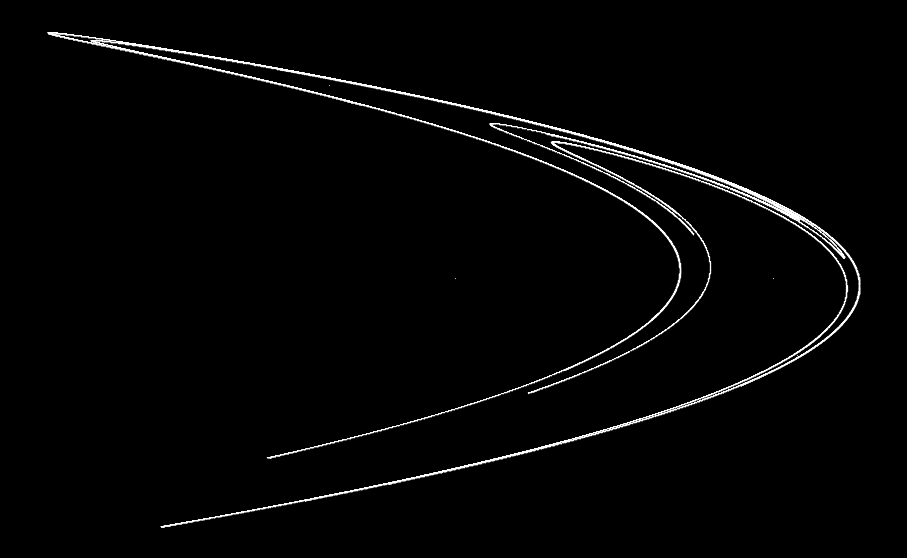

In [2]:
def henon_attractor(x, y, a=1.4, b=.3):
    x_next = 1 - a*x**2 + y
    y_next = b*x
    return x_next, y_next


steps = 100000
X = np.zeros(steps+1)
Y = np.zeros(steps+1)

X[0], Y[0] = 0, 0

for i in range(steps):
    x_next, y_next = henon_attractor(X[i], Y[i])
    X[i+1] = x_next
    Y[i+1] = y_next

plt.figure(figsize = (16,10))
plt.plot(X , Y, '^', color = 'white', alpha = 0.8, markersize = 0.3)
plt.axis('off')
plt.show()
plt.close()

We modify the equations of the Hénon attractor by making the parameter $a$ change slowly in time and add Gaussian noise. 

\begin{align*} x_{n+1} & = 1- ax_n^2 +by_n + \sigma W_n\sqrt{\Delta t} \\
y_{n+1} & = x_{n+1} + \sigma W_n\sqrt{\Delta t} \\
a_{n+1} & = a + \Delta t
\end{align*}
where $W_n$ is a normal random variable, $\Delta t>0$ is a small step size, and $\sigma$ is the noise intensity.

For fixed $b=0.3$, we let the parameter $a$ grow slowly and linearly in time, from $a=0$ to $a=1.4$, and also add the Gaussian noise.

In [3]:
def henon_attractor_noise(x, y, a=1.4, b=.3, sigma=1, delta_t = 1):
    w = np.random.normal(0,1)
    x_next = 1 - a*x**2 + b*y + sigma*w*np.sqrt(delta_t)
    y_next = x + sigma*w
    return x_next, y_next

In [4]:
steps = 100000
delta_t = 1.4/steps
a = 0 
X = np.zeros(steps+1)
Y = np.zeros(steps+1)
T = np.zeros(steps+1)

X[0], Y[0] = 0, 0

for i in range(steps):
    a = a + delta_t
    x_next, y_next = henon_attractor_noise(X[i], Y[i], a, sigma=.005)
    X[i+1] = x_next
    Y[i+1] = y_next
    T[i+1] = a

The following is the $x$-time series corresponding to the system defined above. The horizontal axis corresponds to the values of the parameter $a$.

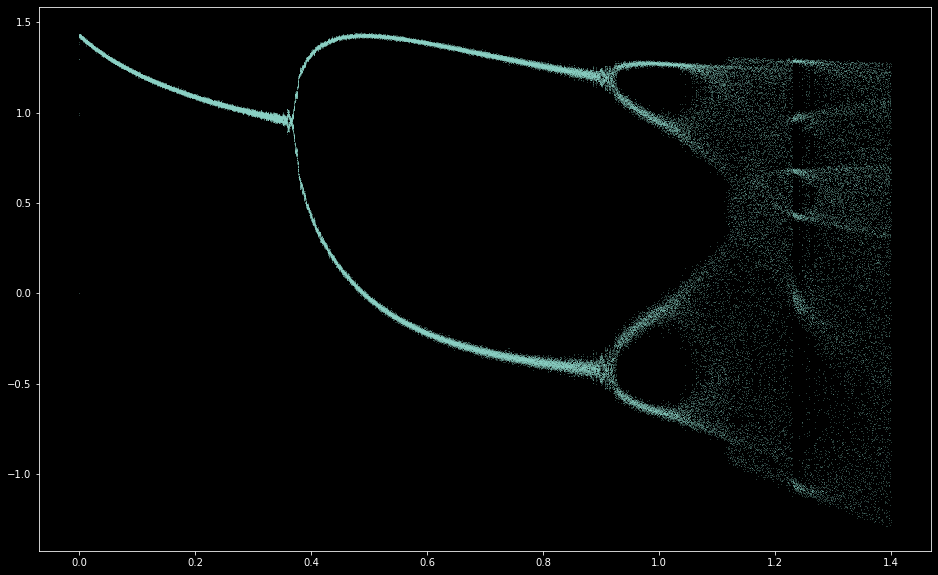

In [5]:
plt.figure(figsize = (16,10))
plt.plot(T,X, '*', alpha = 0.8, markersize = .1)
plt.show()

We generate $d=4$ realizations of the $x$-time series for each value of the parameter $b=0.27, b=0.28, b=0.29, b=0.3$. 

In [6]:
def henon_cloud(steps=100000, a_final = 1.4, b=[.27, .28, .29, .3], sigma=.005):
    delta_t = a_final/steps
    a = 0
    X = np.zeros((steps+1, 4))
    Y = np.zeros((steps+1, 4))
    t = np.zeros(steps+1)
    for i in range(steps):
        a = a + delta_t
        for j in range(4):
            X[i+1][j], Y[i+1][j] = henon_attractor_noise(X[i][j], Y[i][j], a, b[j], sigma, delta_t)
        t[i+1] = a
    return X, t

In [7]:
X,t = henon_cloud()

In [8]:
X.shape

(100001, 4)

For sliding windows $w=50$ we obtain a sequence of point cloud data sets $X_n$ of shape $(50, 4)$. 

In [9]:
X_clouds = np.lib.stride_tricks.sliding_window_view(X, window_shape = (50,4))

Next, for each cloud point $X_n$ we associate the corresponding Rips filtration and compute the persistence diagrams $P_1(X_n)$ of the first homology, their corresponding landscapes $\lambda_1(X_n)$, and their $L^1$ norm $||\lambda_1(X_n)||_1$. 

In [10]:
import gudhi as gd
import gudhi.representations
from gudhi.representations import Landscape
import scipy.integrate as integrate

In [19]:
norms = []
n = X_clouds.shape[0]-1
for i in range(n):
    print(i)
    alpha_complex = gd.AlphaComplex(points=X_clouds[i][0]).create_simplex_tree()
    persistence_diagram = alpha_complex.persistence()
    landscape = gd.representations.Landscape(num_landscapes=1, resolution=1000)
    l = landscape.fit_transform([alpha_complex.persistence_intervals_in_dimension(1)])
    y = l[0][:1000]
    l1_norm = integrate.simps(y, x = None)
    print(l1_norm)
    norms.append(l1_norm)
    
    

0
6.193664385850354e-05
1
6.193664385850354e-05
2
6.161238268550686e-05
3
6.293674547697428e-05
4
6.295036621346474e-05
5
6.291486819408653e-05
6
6.291486819408653e-05
7
6.291486819408653e-05
8
4.4004413045256046e-05
9
0.0003240320450064946
10
0.00036282143936602424
11
0.00036282143936602424
12
0.00030728395527891884
13
0.00031121514471998295
14
0.0003090264030991759
15
0.0002810383250582663
16
0.0002920657216398765
17
0.00031544518129714535
18
0.0002761827520569916
19
0.0002730034836381283
20
0.00027521726357791917
21
0.00024490403112960703
22
0.0002480722337707419
23
0.0002384225134713951
24
0.0002384225134713951
25
0.00024573855868657667
26
0.00024740201915779403
27
0.0002494661482017402
28
0.0001445024386013808
29
0.0001858229566172401
30
0.00024186718970781588
31
0.0003055974453192698
32
0.000289290576936375
33
0.00027054099564024586
34
0.0002021602524145782
35
0.00021435084000840775
36
0.00016324920157621543
37
0.00016324920157621543
38
0.00015888047759360214
39
0.000160195423947

0.00011204326872021013
313
0.00010905083974170206
314
0.0001422458007230442
315
0.0001616980634839471
316
0.00027709502810274695
317
0.0002624477031082923
318
0.0002791080864695985
319
0.0002624875013152454
320
0.0002837604246959527
321
0.00021749158586586181
322
0.0002805092234253017
323
0.0002822559313069606
324
0.00026707999572300994
325
0.00030020966451688175
326
0.00029199913927337574
327
0.0003417278762456377
328
0.00034081185735528085
329
0.00030302842550816977
330
0.00022033443053811423
331
0.00022033443053811423
332
0.00021744197749142943
333
0.00022640277205999634
334
0.0003345733927297732
335
0.00033381973290751843
336
0.00033396480028614634
337
0.0004289721104324069
338
0.0003596263011344532
339
0.0003692483558999202
340
0.0003178817107064925
341
0.0002868145608202736
342
0.00028500240467674314
343
0.00033293292249910773
344
0.0003560757209223438
345
0.000356953668656411
346
0.00031463204783297696
347
0.00032792857971207523
348
0.00034435462439887766
349
0.00038611047424201

0.0002362457680602284
623
0.0002589733469116861
624
0.0002770579792488597
625
0.00039625129529442186
626
0.0002769182939489024
627
0.00026076554584072786
628
0.0002680455230690784
629
0.0002665832789091723
630
0.0002517060676857136
631
0.00028777509694315423
632
0.00026177595122829444
633
0.00038601535165304454
634
0.00037673579578229987
635
0.00036898412310688237
636
0.0003329728965870911
637
0.00034162833012477
638
0.00035084184394990585
639
0.0004615090177607853
640
0.00047953772880869264
641
0.0005576339248520853
642
0.0005481774358296684
643
0.00045655499746577027
644
0.00041423836311746404
645
0.00040592802660704334
646
0.00039130075883471297
647
0.00020686919282163037
648
0.00021671622751516536
649
0.0002355985981522018
650
0.00023573361016905123
651
0.00023056622403397128
652
0.00023409378387965332
653
0.00023047231764470203
654
0.00022707627889506033
655
0.00019540161079975802
656
0.00019366940246582872
657
0.000195135618808871
658
0.0002090353208863671
659
0.00031861716595954

0.00027250517667929764
934
0.00029035943871529816
935
0.0003016340646660953
936
0.00028751590865299195
937
0.0003096881060796287
938
0.00029610195605618783
939
0.000366036381884744
940
0.0003660014088760125
941
0.0003572732334249431
942
0.0003540475046671211
943
0.0003556050955746879
944
0.00028032216406764055
945
0.00028032216406764055
946
0.0002815234939958869
947
0.0003520314856528451
948
0.000269247110467216
949
0.00022699359510564148
950
0.00022447244086346477
951
0.00025172564321211487
952
0.00027087435694708587
953
0.0002655741418327805
954
0.0002147455912022462
955
0.0002549530513587353
956
0.0002531731008503947
957
0.0002392483770126317
958
0.00026654272656623565
959
0.00026820228864120067
960
0.00022549255787871955
961
0.0002182903896929055
962
0.0002581909309292201
963
0.000271105330014886
964
0.0002610269659241291
965
0.00025083726008109323
966
0.00025582693308369626
967
0.00022925566294350363
968
0.0002261710086997022
969
0.0002261710086997022
970
0.0002570636175353516
971

0.0003832559877128725
1236
0.0003666064745742107
1237
0.00037373540474505197
1238
0.0002625156657146246
1239
0.00026936202516356843
1240
0.00033030583998113996
1241
0.0003367906024282369
1242
0.00031878375080946495
1243
0.0003389843648818232
1244
0.00030300992742209753
1245
0.00025598161953165554
1246
0.0002863706776511638
1247
0.0002863574799681646
1248
0.00030200492018081027
1249
0.0002968856479629183
1250
0.00029259200380020277
1251
0.00026416960715187047
1252
0.0002622283496042444
1253
0.0002681030996779978
1254
0.0002678025472080229
1255
0.0002637697665705604
1256
0.0002668470089540559
1257
0.00027295096411526017
1258
0.00028971189378671554
1259
0.00028971189378671554
1260
0.00027586912060677493
1261
0.0002857560768142222
1262
0.0002832305945715366
1263
0.00023358873761273647
1264
0.00023196129598127864
1265
0.00023878452770356988
1266
0.00023878452770356988
1267
0.00024849819936173973
1268
0.0002488110496346943
1269
0.00018972877138322133
1270
0.0001598825731469411
1271
0.0001607

0.0002824192846317227
1533
0.0002528744698531308
1534
0.00024954205552048903
1535
0.00024954205552048903
1536
0.000425187087399119
1537
0.0003666084379296561
1538
0.00033230278478235177
1539
0.00044634122059719676
1540
0.000432097394080569
1541
0.0004351328995665781
1542
0.00044377013190357965
1543
0.0004459565697733843
1544
0.00028075866962849305
1545
0.00045423090161730276
1546
0.0003780098184365079
1547
0.00038939740247693447
1548
0.0003826201190730275
1549
0.0003017448772119132
1550
0.00024243674184601198
1551
0.0002810359442660764
1552
0.0002647999416401687
1553
0.00025051192605521697
1554
0.0002228402440053429
1555
0.0002513715704630552
1556
0.00032177909043913926
1557
0.000322248375242896
1558
0.0003350719455639631
1559
0.0003211562610010448
1560
0.00032115982048994005
1561
0.00032544995672786165
1562
0.00024376523673461497
1563
0.0003491124634796691
1564
0.0003800385249456215
1565
0.00041227741188487913
1566
0.0004122790212299682
1567
0.00039905980821745965
1568
0.0003990598082

0.00014332109854745678
1832
0.0001466973827419787
1833
0.00019086638293719995
1834
0.00021495366352250085
1835
0.00022285140174669238
1836
0.00016891495185180185
1837
0.00016814245217457437
1838
0.00017368603688883605
1839
0.00017627986162915314
1840
0.00017626111283371333
1841
0.00017658758199151417
1842
0.00017739766299612307
1843
0.00016413471594240795
1844
0.00013162595364026397
1845
9.505115411186081e-05
1846
0.00010376745628335876
1847
0.0001052149037992041
1848
0.00010473880225003496
1849
0.00011276126317271797
1850
0.00010776679205079085
1851
0.00011558529455886741
1852
0.00011084690477468409
1853
0.00011154222404860951
1854
0.0001126253820911086
1855
0.00011144143109401498
1856
9.98646635100187e-05
1857
0.00014430769783602338
1858
0.00013872639010456368
1859
0.00012001738005217655
1860
0.00011504024171287032
1861
0.00013476782836243655
1862
0.00012145523772320539
1863
0.0001359761864500847
1864
0.00012318911161236567
1865
0.000145348057855293
1866
0.00015093891887192994
1867
0

0.0001491785519760177
2131
0.00015271157961720572
2132
0.0001564562244030535
2133
0.0002001457496832409
2134
0.0002623818072648262
2135
0.0003028458796691452
2136
0.0002249532419331112
2137
0.0002249532419331112
2138
0.0002956549263309845
2139
0.0003036894797569613
2140
0.0002833614283032077
2141
0.00027757656733584906
2142
0.0002737445709648103
2143
0.00024552856279663217
2144
0.0002590563912098557
2145
0.0002575202914452389
2146
0.00022994925023607689
2147
0.0001845041781537705
2148
0.00018555520571527393
2149
0.0001817705403892953
2150
0.00017434602443400378
2151
0.0002162924673933837
2152
0.00021627766187512002
2153
0.0003148685991960164
2154
0.00032549692828446643
2155
0.00027916443266860747
2156
0.0002801498672834895
2157
0.0002821190371954842
2158
0.0002809672194797915
2159
0.00038225067058277946
2160
0.0003695819470463723
2161
0.0003572227150857972
2162
0.00037811503277104103
2163
0.0003214792252137416
2164
0.0003373765029850256
2165
0.0003030993181917192
2166
0.000303079066184

0.0002189013740536027
2431
0.000267381291747345
2432
0.000267381291747345
2433
0.00026124778077328743
2434
0.00033064331683946936
2435
0.0003246191966437084
2436
0.00012604486373268115
2437
0.0001247473860072502
2438
0.0002111064512555291
2439
0.00022573398576809705
2440
0.0002271274370871927
2441
0.00023267448449754033
2442
0.0002372184951577583
2443
0.0003507987110048128
2444
0.0001690251585599155
2445
0.00016524381589152204
2446
0.0001830027214728383
2447
0.00017244860383578564
2448
0.00016616956064249087
2449
0.0001593338933614375
2450
0.00013534438604108064
2451
0.00016816667947565204
2452
0.00016816667947565204
2453
0.00016828873762143837
2454
0.0003485071787875399
2455
0.0002615057038811136
2456
0.00026001075146394904
2457
0.0002499058363345681
2458
0.0002499015362149357
2459
0.0002412878414353215
2460
0.00024129471265419875
2461
0.00019823627747702607
2462
0.0002009870984024063
2463
0.00021929411467628583
2464
0.00022084282820774673
2465
0.00024516308324545167
2466
0.0002246310

0.0001914955075401454
2731
0.00021889056002137166
2732
0.00019749497382530416
2733
0.00019770286963074284
2734
0.00018708903069928994
2735
0.00021268085958287187
2736
0.00021045101787328926
2737
0.00023746624004236007
2738
0.00019764135147859254
2739
0.00020235758251854565
2740
0.00019258546787015646
2741
0.00014378300667972172
2742
0.0001758326704427852
2743
0.00017667398161780846
2744
0.0001823708014138664
2745
0.00018680463845910158
2746
0.00017451806168060496
2747
0.00016331946134685163
2748
0.00016339088930395404
2749
0.00017622577553129772
2750
0.00023889345319779088
2751
0.00023696650921291315
2752
0.00020784523540248278
2753
0.00020784523540248278
2754
0.000239408359559447
2755
0.0002184691865173052
2756
0.00018060054964738606
2757
0.0002657252491390862
2758
0.0002657412968506812
2759
0.00025932903478561377
2760
0.0002578841908220985
2761
0.00025788497546064894
2762
0.0002662199601058984
2763
0.00023924184080635776
2764
0.0002310308456715408
2765
0.0002350443646502992
2766
0.00

9.591917506151537e-05
3029
9.576051173148042e-05
3030
8.404520955887497e-05
3031
8.712520411114935e-05
3032
9.142197234597093e-05
3033
9.110628584350137e-05
3034
8.354642229400492e-05
3035
0.00010384222134510576
3036
0.00010384222134510576
3037
0.00010387919940740855
3038
0.00010391013622136013
3039
0.00010062036238574829
3040
0.0001237970452566709
3041
0.00012259652195562587
3042
9.144161157296381e-05
3043
9.96792945744799e-05
3044
8.331102008326761e-05
3045
8.431195162799547e-05
3046
8.66427432569078e-05
3047
8.66427432569078e-05
3048
9.09062585965873e-05
3049
9.820510433258323e-05
3050
0.00011132998215260948
3051
9.958244075671704e-05
3052
9.801628151239958e-05
3053
0.00026370947381053816
3054
0.0002696077659076453
3055
0.00028233428288565606
3056
0.00026499065041327814
3057
0.0002529604668816821
3058
0.00018121791576631115
3059
0.00018938867112417684
3060
0.0001753025627204029
3061
0.0001803620780508755
3062
0.00023943347767383196
3063
0.00024409521023267402
3064
0.0002578021875435

0.00029401926832024674
3329
0.0002833539397474731
3330
0.00026627667972100563
3331
0.0002474910162195349
3332
0.00024300619512167984
3333
0.0002467800368760335
3334
0.00024953126736266217
3335
0.00023700859419400767
3336
0.00011916904852818113
3337
0.00011146100980209767
3338
0.00011345170269162075
3339
8.834242706336124e-05
3340
8.303163734618746e-05
3341
0.00010593330374122849
3342
0.00010214704009705019
3343
0.0001021498432887732
3344
9.308404727819802e-05
3345
9.865087077281205e-05
3346
0.00012176457689868917
3347
0.00012905785048521957
3348
0.00012903150526669455
3349
0.0001441043672570231
3350
0.00015991447501915662
3351
0.00016815454746289197
3352
0.00016724685122013913
3353
0.00018466522526617004
3354
0.0001937165560384244
3355
0.00023514574967622564
3356
0.00022097341071324278
3357
0.0003516378072937145
3358
0.0003544609673712336
3359
0.0003690007022010199
3360
0.00036995987432576776
3361
0.000300870939146971
3362
0.00030643554966009666
3363
0.00035160228092437443
3364
0.00035

0.00025689793374614135
3626
0.00023570906859852832
3627
0.0002537651341201709
3628
0.00025381671739471397
3629
0.0002201946168355499
3630
0.00023574505282837754
3631
0.00024137060833544937
3632
0.0002852356183362513
3633
0.0002429137456143993
3634
0.0002274666976474616
3635
0.00022588732744317842
3636
0.00023223565101000533
3637
0.0002334487562168487
3638
0.0002714650385047645
3639
0.000275583119239786
3640
0.0002483034686470893
3641
0.00024794087981555774
3642
0.00025641075549981835
3643
0.00025766160725013013
3644
0.0002581772083572754
3645
0.0002770537344943463
3646
0.0002731582278811211
3647
0.00027021113142906925
3648
0.0002649822291657646
3649
0.00027660027223475015
3650
0.0002457260667735863
3651
0.0002469888475017906
3652
0.00025200126465468897
3653
0.00023559302794847375
3654
0.00023970810724748096
3655
0.00022367581286754452
3656
0.0002088031017331585
3657
0.0002088031017331585
3658
0.00020964710961641656
3659
0.0002007130382351092
3660
0.00019212625767763556
3661
0.000181434

0.00012179817631663066
3924
0.0002038050512949935
3925
0.00021513005669247576
3926
0.00017187607150909994
3927
0.00016870464645774618
3928
0.00016818459608996421
3929
0.00016819909212782924
3930
0.00016805704861788033
3931
0.00016807345182053284
3932
0.00023561676878754923
3933
0.00023315933211236263
3934
0.00020798368343671693
3935
0.00020048417207645474
3936
0.00020822406027212346
3937
0.00021458233632828
3938
0.00016651629751300394
3939
0.0001742435995902453
3940
0.0002386244100267283
3941
0.0002733418025232659
3942
0.0002733285047816456
3943
0.0002737768927038817
3944
0.0002737768927038817
3945
0.0002789460050354371
3946
0.0002912409238632729
3947
0.00017409271134143035
3948
0.000147380089801342
3949
0.0001925833812218292
3950
0.0002135098548876806
3951
0.00018763476568941606
3952
0.0002636780133319223
3953
0.00022272008305690967
3954
0.00022565230846492872
3955
0.00021946244864222265
3956
0.0002131569506709427
3957
0.0002086355120182521
3958
0.00020229806623792338
3959
0.000229738

0.0001304091230905215
4221
0.00012586847726565127
4222
0.00011355275806379353
4223
0.00013449825722179281
4224
0.00013150077202688385
4225
0.00012983704321488208
4226
0.00013048281479044604
4227
0.00014709522700889345
4228
0.00014448486000491383
4229
0.0001706426398567501
4230
0.0001721044103884911
4231
0.00015436826794694666
4232
0.00015834565969351054
4233
0.00012269682366337843
4234
9.682227674842343e-05
4235
0.00015992054781972982
4236
0.00015613394353704684
4237
0.00013306299225026024
4238
0.00013353724445738552
4239
0.00021907154924332196
4240
0.0002239845639070669
4241
0.00022590473594536622
4242
0.00013353927649955192
4243
0.00013396651771729241
4244
0.0001266191244434955
4245
0.00010076544329625211
4246
9.787821222254545e-05
4247
0.00015163828149784245
4248
0.0001583599668010999
4249
0.00015754476346772477
4250
0.00015963308233610707
4251
0.00011927810992578522
4252
0.00012060515029734785
4253
0.00011876270743221097
4254
0.00010484895855239967
4255
0.00010665425449741072
4256


0.0001903599971130672
4519
0.0001905845578190999
4520
0.00028544660264939953
4521
0.0002887124458596298
4522
0.00026660377964190824
4523
0.00029786819529351347
4524
0.00029786819529351347
4525
0.0003034723558199449
4526
0.0003479775421059937
4527
0.00035041227773479467
4528
0.000262878505413441
4529
0.0002630452378024381
4530
0.00026442506079494074
4531
0.00026252795497169035
4532
0.0002510643007422462
4533
0.0002510643007422462
4534
0.0002575835628329599
4535
0.0002648941182631819
4536
0.0002648941182631819
4537
0.000273935514848048
4538
0.00026046349161708445
4539
0.0002565046235284586
4540
0.00028500284870368623
4541
0.0002444003683812759
4542
0.00035502613925085996
4543
0.00029805788546544295
4544
0.0002799231274251557
4545
0.00029114886486720706
4546
0.00028761604616562127
4547
0.0003044632735197537
4548
0.0003144692695186552
4549
0.0003145809771599682
4550
0.00019547596923942816
4551
0.00013919051057499838
4552
0.00013867867909216425
4553
0.0001279053621037698
4554
0.000128070495

0.00039461996793361116
4816
0.00037826831144283606
4817
0.000306893321570325
4818
0.0003091539262489003
4819
0.0003091539262489003
4820
0.00023581742897216398
4821
0.000232641029943993
4822
0.000273561868817686
4823
0.0002774789685603952
4824
0.0002795252185068862
4825
0.00028047296740051883
4826
0.00029282819773171026
4827
0.0002552268974134936
4828
0.00026892671506843356
4829
0.0002549542817641279
4830
0.0002549542817641279
4831
0.00022234413393980052
4832
0.00021077260034606468
4833
0.00022190742419354076
4834
0.0002312132083841663
4835
0.00023039732926806038
4836
0.0002076521691615798
4837
0.00017950868247852957
4838
0.00019752787941845992
4839
0.00018790807637464278
4840
0.00031167344482832993
4841
0.0003244891735530139
4842
0.0003814394124572813
4843
0.0003759348249322883
4844
0.0003658005840806097
4845
0.0003662681109623734
4846
0.0003390539405126337
4847
0.00034053126345410644
4848
0.0003332615998274184
4849
0.00019385081145397324
4850
0.00019385081145397324
4851
0.000180582845

0.00022690843268263056
5117
0.0002270831069446987
5118
0.000251734416956466
5119
0.00026235963140283663
5120
0.0004092917812852739
5121
0.00041192975022043916
5122
0.000199851225970211
5123
0.000199851225970211
5124
0.00019927199684327546
5125
0.00019915896347673053
5126
0.0001872523562687703
5127
0.00021206410988850003
5128
0.00021077157026927893
5129
0.00021077157026927893
5130
0.00020702218108127583
5131
0.00019529576598756472
5132
0.0001879361107448755
5133
0.00014593582874923
5134
0.00013593517921676613
5135
0.0002088472940855372
5136
0.00022145483565757775
5137
0.0002457809270010937
5138
0.0002552110728739622
5139
0.00022143804708570617
5140
0.00021979868932212922
5141
0.0002225409275022576
5142
0.00022946731523619985
5143
0.0002451998247769236
5144
0.0002473582594716638
5145
0.0004106975157743737
5146
0.0004125873697572887
5147
0.00023899747003696005
5148
0.00023548843085146855
5149
0.00024152199691511813
5150
0.00023192798280086057
5151
0.00023198594945385683
5152
0.00019871796

0.00025280181940598494
5416
0.00022602073533642148
5417
0.0002280125268534922
5418
0.00021797062637879118
5419
0.00025318736021921203
5420
0.00026936155859215324
5421
0.0002098778502971981
5422
0.00020275627756854297
5423
0.00019991088244358606
5424
0.0002909649663039327
5425
0.00029054738970908114
5426
0.00029054738970908114
5427
0.00029213292780408477
5428
0.0002923623536042458
5429
0.00027387519604485844
5430
0.00023192540748997643
5431
0.0002313167478312222
5432
0.00023137925684705207
5433
0.00014631322285560313
5434
0.0001458508475430947
5435
0.00014609968602043166
5436
0.0001629608571020356
5437
0.00026147399538229153
5438
0.00026147399538229153
5439
0.00020239236028835917
5440
0.00021115844075177647
5441
0.00022327822046580434
5442
0.00018653667080812376
5443
0.00020339343332973465
5444
0.00020686498645307611
5445
0.00020587196631759088
5446
0.00019814996482667328
5447
0.00019632604528393234
5448
0.00019789473976855013
5449
0.00020295953458700385
5450
0.00021004673310059618
5451

0.00015543711324484161
5714
0.0001644024441893488
5715
0.00018740313907072306
5716
0.00019934936333120703
5717
0.00022433785049995675
5718
0.00023184606777947587
5719
0.0002335429020094479
5720
0.00023470511939433446
5721
0.0002631606782894607
5722
0.00036792993052579733
5723
0.00034681790724251676
5724
0.0003308341382564554
5725
0.00033532824895328434
5726
0.00036957154324056003
5727
0.00036953648676527127
5728
0.00036775321405064685
5729
0.00037215967705181554
5730
0.00038655660302865574
5731
0.0002517186576382861
5732
0.0002822201350706075
5733
0.0002820119184736205
5734
0.0002820119184736205
5735
0.000281364669284504
5736
0.00020551532682398804
5737
0.00019483298422187968
5738
0.0001857863515704667
5739
0.00018407271657443046
5740
0.00025222758511481255
5741
0.00020742528675467926
5742
0.0002016053735212184
5743
0.00019141222911477966
5744
0.000205397397687014
5745
0.0002019257935287507
5746
0.00018926703879637902
5747
0.0003216809518567007
5748
0.000250171601456017
5749
0.00024464

0.00015633204033680296
6011
0.0001420038627165988
6012
0.00014307515688357682
6013
0.00013833785779405734
6014
0.00015314333569945134
6015
0.00015547178524403556
6016
0.00017150388971862038
6017
0.000142736245530963
6018
0.00014188180447842076
6019
0.00012857203443449657
6020
0.00019898067435574263
6021
0.00017630187264177608
6022
0.0001838002125022777
6023
0.00020941122630078497
6024
0.00016312098577808958
6025
0.00014896069365145898
6026
0.00010049200998285185
6027
0.00010226498683399863
6028
0.00011807984834595942
6029
0.00013947644599900626
6030
0.00012109370850060446
6031
0.00031516060718412794
6032
0.0003209648505562839
6033
0.00029859699926687046
6034
0.0002981548546406299
6035
0.00023798253236035445
6036
0.00023991298496477367
6037
0.0002472700675545195
6038
0.00024642618207851974
6039
0.0002465101675860353
6040
0.000263545856984942
6041
0.0002650357710344326
6042
0.0002712702936316034
6043
0.000294078450652558
6044
0.00029541136054628606
6045
0.0003729402943636529
6046
0.00029

0.00015917404856089702
6311
0.00012773062225825848
6312
0.0001351621246039911
6313
0.00013052845226155116
6314
0.00010622592047262929
6315
0.00011158855026425883
6316
0.0002516123084016275
6317
0.0002553514695830577
6318
0.00034098381745808527
6319
0.0003613999661560078
6320
0.0003005782761331674
6321
0.00029851855005645324
6322
0.00026424580549930845
6323
0.0002640163708047569
6324
0.00022536814145236283
6325
0.00021792000485161935
6326
0.00020370152183998776
6327
0.0002017302223047484
6328
0.000180546448748297
6329
0.00018020536085989778
6330
0.00019794781357654665
6331
0.00020156897294325591
6332
0.00020553231059271558
6333
0.00020553231059271558
6334
0.00020374023831718171
6335
0.00020375396725321745
6336
0.0002233837736189848
6337
0.0002233837736189848
6338
0.00023882926369203113
6339
0.00017527999251769496
6340
0.00017354481987430005
6341
0.00016972174507291679
6342
0.00016972174507291679
6343
0.00012659280162177183
6344
0.0001134652109142151
6345
0.000123102033704933
6346
0.0001

0.00015741100883327324
6609
0.00017091817350710204
6610
0.00018301425798253768
6611
0.000168967896820052
6612
0.0001646349766484314
6613
0.0002175207281085457
6614
0.00019904737073937975
6615
0.0002742757383688786
6616
0.00027486379740289136
6617
0.0004238444115825574
6618
0.000417277821819966
6619
0.0004286364105429451
6620
0.0004286364105429451
6621
0.0004297651333902666
6622
0.0004304175014632379
6623
0.00025193906368790387
6624
0.0002461074323341834
6625
0.0002461064028981929
6626
0.0002497978861053554
6627
0.000258096442460414
6628
0.0002619145399106985
6629
0.000285141913592078
6630
0.0003005884371191622
6631
0.0002926596420120225
6632
0.00023679965955506087
6633
0.0002345101541853974
6634
0.0002329685074731504
6635
0.00021632815395855953
6636
0.00022004716344600235
6637
0.00022234108634286808
6638
0.00024396283932269505
6639
0.00023847906529242294
6640
0.00018132901918150866
6641
0.0001812610551660995
6642
0.0001890908398057612
6643
0.0001904335179549373
6644
0.00019114092516483

0.00011108029388840425
6910
0.0001072600124183832
6911
0.00010269856881117517
6912
0.0001084227966377571
6913
9.58004200023869e-05
6914
0.00010140684572811346
6915
8.875868773049704e-05
6916
9.185435855137696e-05
6917
0.00010187458787515086
6918
0.00010151887554336199
6919
0.00010256979798439949
6920
0.00011205961595365595
6921
9.813223061931865e-05
6922
9.777972736900207e-05
6923
9.764080431597386e-05
6924
0.00020968167911578482
6925
0.00020395538923066077
6926
0.00022209387450350176
6927
0.00023287662928492563
6928
0.0002426602293890705
6929
0.00026946231006677487
6930
0.0002646169490610432
6931
0.00025719911652488637
6932
0.00023035852658444936
6933
0.00023035852658444936
6934
0.00025848140093256153
6935
0.00033806570252054534
6936
0.0003223806167341486
6937
0.00026967725474436337
6938
0.00025805115311297003
6939
0.0002523258550304882
6940
0.00024918729325597533
6941
0.0002845109980228144
6942
0.0002690677461204632
6943
0.0002351451568174233
6944
0.0001933980725828307
6945
0.0001658

0.00011450500272211862
7207
0.00011373656695386001
7208
0.0001012759656070493
7209
0.00010389153355773124
7210
0.00011654464143456395
7211
0.00010666540676458122
7212
0.00013092116370812417
7213
0.00013216882046187812
7214
0.00013011077201477805
7215
0.00013766032530683736
7216
0.00013766032530683736
7217
0.00013065933982229203
7218
0.00012940250386503992
7219
0.00017118294174951344
7220
0.00012781180239317653
7221
0.00010362629867506081
7222
0.00010482503964343393
7223
0.00010081060338026859
7224
0.00011632262589623197
7225
0.00011555564570621085
7226
0.00011536048023871645
7227
0.00011532879084868177
7228
0.00011536434757131997
7229
0.00011613284340133735
7230
0.00014693415742312078
7231
0.00013926975665050305
7232
0.0001315182603360744
7233
0.00013551527634759884
7234
0.00014288439529215746
7235
0.00018472926751388332
7236
0.00018226826370931025
7237
0.00018692486525752748
7238
0.00018692486525752748
7239
0.00020732248210934002
7240
0.00028326409150081173
7241
0.00028326409150081173

0.00024308054434374346
7507
0.00023547351743834108
7508
0.00021934620008867296
7509
0.00017190838815063806
7510
0.00015868517742786067
7511
0.0001593981581300963
7512
0.00012289968560721498
7513
0.00020433022999975355
7514
0.00020861615387509635
7515
0.0002163452848477878
7516
0.00018105700716555692
7517
0.00018435063044602019
7518
0.0001904120597657777
7519
0.0001911013743273667
7520
0.00025032518772999304
7521
0.00026806219938307354
7522
0.00025172239999936063
7523
0.00028485318785684104
7524
0.00023694227416972254
7525
0.000252529137417471
7526
0.00021664499406996387
7527
0.00021664499406996387
7528
0.00021791075695519523
7529
0.0002200491697059943
7530
0.00021335249814864526
7531
0.00019830013879067247
7532
0.00017883747073771662
7533
0.0001632413146130243
7534
0.00016353971005495082
7535
0.00016259376786288053
7536
0.0001607472058303101
7537
0.00015048778737924846
7538
0.00016860633152152607
7539
0.00016860633152152607
7540
0.0001914228612122394
7541
0.000247738559731681
7542
0.00

0.0003658164771244272
7806
0.0003706791051418017
7807
0.00036893151011471487
7808
0.00035359070916998953
7809
0.0002505677583578876
7810
0.0002515791113211064
7811
0.00018765644781011833
7812
0.00023868364872631247
7813
0.00024111665433484332
7814
0.0001649617430515679
7815
0.0001649617430515679
7816
0.0001817399871514608
7817
0.00013610622882695504
7818
0.00013610622882695504
7819
0.00017157604857627364
7820
0.00014271503066060054
7821
0.00019281044870528066
7822
0.0001912371574929409
7823
0.00020184516700035566
7824
0.00017881729628494136
7825
0.00017919584211033835
7826
0.00019536740797939438
7827
0.00020192884150681067
7828
0.00021152420981050278
7829
0.00022283307551160348
7830
0.00019618744635760654
7831
0.00019219312234872396
7832
0.00018091781683249048
7833
0.00018545096012310776
7834
0.00024432645059493864
7835
0.00024369397334644862
7836
0.0002348376654124471
7837
0.0002347918366909731
7838
0.00024161563827851588
7839
0.00024041602447090162
7840
0.00022283717025929346
7841
0.

0.00039239381781793945
8105
0.0004189679640752141
8106
0.0004119842901551063
8107
0.0004381236304099788
8108
0.00035056046939885234
8109
0.0002107862017708795
8110
0.00030599120612345953
8111
0.0003012461549850249
8112
0.0003014170734390833
8113
0.0002869438295322907
8114
0.0002204851613567368
8115
0.00021755399717023302
8116
0.00032357088755463105
8117
0.0002845943394016259
8118
0.00036041863772018936
8119
0.0003605805092756431
8120
0.0003605805092756431
8121
0.0003605840485159727
8122
0.00035894527092595176
8123
0.00027508843298439133
8124
0.0002803700280622961
8125
0.0002855283190331802
8126
0.0002877983137678211
8127
0.00036909930682987077
8128
0.0003690957675895411
8129
0.000361632614770914
8130
0.0003603861370575551
8131
0.0003617733659700301
8132
0.0005030997294259127
8133
0.0005023136610995536
8134
0.00026901777384597556
8135
0.0002708680417783633
8136
0.0002665789917412446
8137
0.00026359939489945325
8138
0.00025520763886328185
8139
0.00019685934230868576
8140
0.00019611923845

0.00013612316161829116
8402
0.00015896448652081137
8403
0.00016704972927700554
8404
0.00017133255256497195
8405
0.00019248647339131027
8406
0.00022402444915856678
8407
0.00022402444915856678
8408
0.00026547435113151316
8409
0.0002691807445735317
8410
0.00024075525876359705
8411
0.00021954820377782688
8412
0.00022058469368667002
8413
0.00022058469368667002
8414
0.00022199618054899608
8415
0.00022962830043954358
8416
0.0002586514476602436
8417
0.00024312599449266602
8418
0.0002434743534577694
8419
0.0002637500631833363
8420
0.00025961918762837307
8421
0.00024215958166352484
8422
0.0002516344843834325
8423
0.0003227960282110118
8424
0.0003227960282110118
8425
0.0003306393548410265
8426
0.0003245060764468212
8427
0.0003593816219489396
8428
0.0004423242244554271
8429
0.00037456847949897865
8430
0.0003830610710915388
8431
0.00037246719456337596
8432
0.0003512951900524337
8433
0.0003512951900524337
8434
0.0003436726468603079
8435
0.00034207806536639573
8436
0.0003484946880538797
8437
0.000258

0.00019077330511205412
8703
0.00019193806061974046
8704
0.00018323478153768388
8705
0.00017655919651012356
8706
0.00017128894420279832
8707
0.00024919751388074773
8708
0.000265038461731819
8709
0.0001975253118694609
8710
0.00019125595004099833
8711
0.000261764839430202
8712
0.0002561116300102781
8713
0.00024393404508572905
8714
0.00022383799508068788
8715
0.00022379390372312128
8716
0.00022121495201573834
8717
0.000224130520364617
8718
0.0002155805930928785
8719
0.00017497347945384125
8720
0.0001817498083575416
8721
0.00018316673150299063
8722
0.0003027837567849938
8723
0.00029767841516128833
8724
0.00029767569730314303
8725
0.00029767569730314303
8726
0.00019398052208797307
8727
0.00019123035767371662
8728
0.00018613677555721556
8729
0.00018613499809218165
8730
0.00018095341803705362
8731
0.00018451076563402377
8732
0.0001897850391734279
8733
0.00025241890261274704
8734
0.0002299032900153281
8735
0.0002783674613070886
8736
0.00029507477265762304
8737
0.0002803272711851265
8738
0.00028

0.00022784456525584495
9002
0.00021180479431837237
9003
0.00021510460557181923
9004
0.00021510460557181923
9005
0.00020793214086223315
9006
0.0002872471950418299
9007
0.0002933295062476422
9008
0.0002700621129484296
9009
0.00026995726162380246
9010
0.00028097425388124336
9011
0.0003115249504956112
9012
0.00028752791589347775
9013
0.00025866829715265744
9014
0.00025866829715265744
9015
0.0002503192913356873
9016
0.00024794787852800543
9017
0.0002247788079415957
9018
0.00020015179330916389
9019
0.00019224836751894275
9020
0.0001763820941541897
9021
0.000173240762635681
9022
0.0001945667082203448
9023
0.00019185020505794087
9024
0.0001514577305644838
9025
0.00014809661418351894
9026
0.00013897776700354632
9027
0.00013897776700354632
9028
0.00013461213678360969
9029
0.0001601791627343747
9030
0.00017773999793701324
9031
0.00018587135916122384
9032
0.00019165900549406227
9033
0.0002072914738537226
9034
0.0002145293851521809
9035
0.00025239543859299974
9036
0.00024988687606577336
9037
0.0002

0.00029370667491622476
9305
0.000305913038446782
9306
0.00024073896818766952
9307
0.0002583130015609074
9308
0.00024356794835315703
9309
0.0002845910016230683
9310
0.0002544081087262526
9311
0.0003559188145221446
9312
0.00043638308614281346
9313
0.00043625451417114394
9314
0.0004444984965584582
9315
0.00048735729073782314
9316
0.00047655150708930314
9317
0.00031485150615765236
9318
0.00031485150615765236
9319
0.000310330750412424
9320
0.0002401100337451693
9321
0.00024137010698155152
9322
0.0002089288986670051
9323
0.00021900680016674558
9324
0.00020964210229456123
9325
0.00020969951108579943
9326
0.00019404057877104734
9327
0.00020642028955480574
9328
0.00020642028955480574
9329
0.00024099279701480668
9330
0.00023698937304693395
9331
0.00023734748811308568
9332
0.0002477006830308964
9333
0.0002435899644480426
9334
0.0002915400688434123
9335
0.0002778555812448996
9336
0.0002714472869880945
9337
0.0002622599827767751
9338
0.00015591815183863553
9339
0.00015229740398663461
9340
0.0001644

0.00024243511681351312
9604
0.00024243511681351312
9605
0.0002817417704280163
9606
0.0003246036818008833
9607
0.0003246036818008833
9608
0.0003140515205193203
9609
0.0003125932414728083
9610
0.00030818233749642653
9611
0.0003120968337795823
9612
0.000330353182732688
9613
0.0003438185446605009
9614
0.00030355036095591986
9615
0.0002989645729888578
9616
0.00030919569846834735
9617
0.00031477828403952225
9618
0.00031477828403952225
9619
0.00033181661985067927
9620
0.00033203155942215784
9621
0.0003442743764436092
9622
0.00042420925833805916
9623
0.00038775468158916464
9624
0.0003900933683150669
9625
0.00037908934716023165
9626
0.0003930381132436473
9627
0.00038900738424858464
9628
0.0003903100272680026
9629
0.000363474795543145
9630
0.0003817395387558507
9631
0.0005111689605479816
9632
0.000509010252491774
9633
0.0004857917574559184
9634
0.0005216305470065276
9635
0.00041035332311518925
9636
0.0003887047106622905
9637
0.00020503727374955987
9638
0.00024552859597793276
9639
0.0002123275733

0.000169030615548874
9902
0.00018368338331922803
9903
0.0001780892610029782
9904
0.00017985875870766486
9905
0.00019060184957895283
9906
0.00018025602721992486
9907
0.00017573781007576084
9908
0.0001788980519325902
9909
0.00019435369610213953
9910
0.00019457342876381332
9911
0.00019387851672821526
9912
0.00020319677563677198
9913
0.00021273420350532258
9914
0.00020563500399505425
9915
0.00019738419163034586
9916
0.00020065837972412632
9917
0.00018604706788192098
9918
0.0001819746969522887
9919
0.00019612416882369368
9920
0.00019718116799279334
9921
0.0001821545328997679
9922
0.0002097491111568785
9923
0.0002145113400998564
9924
0.0002330050248138053
9925
0.00021842786531624838
9926
0.00021535509813019692
9927
0.0002122437231723295
9928
0.00020351311829842138
9929
0.00023053983198839223
9930
0.0002614173856038845
9931
0.00026536098220059903
9932
0.00026262316113470873
9933
0.0002209688355178712
9934
0.00030862062066167457
9935
0.00028934526468756065
9936
0.00030405660071571955
9937
0.00

0.00033146742842682446
10194
0.0003307024867957469
10195
0.0003307024867957469
10196
0.0003833350190405622
10197
0.0004779888848044403
10198
0.00035579003722068284
10199
0.00033912492487855715
10200
0.000351335083153949
10201
0.00038096973550689464
10202
0.0003900150447675476
10203
0.00031240919556807994
10204
0.000266993226818941
10205
0.0003124158533834436
10206
0.0003084659190685797
10207
0.0003224905914814187
10208
0.0003279178356284324
10209
0.00033542196606469447
10210
0.0003305259423321759
10211
0.0003127494764785534
10212
0.0003302334136419753
10213
0.00035565200622223847
10214
0.00037114712973463444
10215
0.00042580419760872675
10216
0.00041969927137869224
10217
0.0003185691996367212
10218
0.00036070010836293325
10219
0.0004096903544135987
10220
0.0004096903544135987
10221
0.0004108454710463973
10222
0.0003863659965676545
10223
0.0003861932671719486
10224
0.00037843759535332244
10225
0.00037843759535332244
10226
0.0003787016892712966
10227
0.0003842049958770359
10228
0.0003465

0.00013856983593719073
10485
0.00010910487485040907
10486
0.00010589172646797705
10487
0.00011824997400313121
10488
0.0001181424302381406
10489
0.00011498698571376659
10490
0.00011761273175833893
10491
0.00011706922733643311
10492
0.00012851633203090945
10493
0.00014642697042619866
10494
0.00013278264868653522
10495
0.00015376790217343992
10496
0.00018283772287841694
10497
0.00017528904899034539
10498
0.00017256534600263373
10499
0.00017503098485580244
10500
0.0001599713096778306
10501
0.0002737895596488817
10502
0.0002741186670627858
10503
0.0002762008904738701
10504
0.00029000065430878055
10505
0.0002844847517414883
10506
0.0002871241540622346
10507
0.00028166173183701785
10508
0.0002823891755709604
10509
0.0002848733844836821
10510
0.0002885481669858974
10511
0.0002741817610577198
10512
0.0002248535760951169
10513
0.00017706675643625543
10514
0.00023685310634478845
10515
0.0002428917243884155
10516
0.00023403294157947464
10517
0.0003726518570496423
10518
0.00030566819647665004
10519

0.00023369563862913923
10773
0.00028389107279797255
10774
0.00027242236240960057
10775
0.00035373407716880083
10776
0.0002831417498175871
10777
0.0003269413776874983
10778
0.0003277990417973244
10779
0.0002663497961291193
10780
0.0002737498404752602
10781
0.00037368491197986516
10782
0.000490931667331204
10783
0.00037257773365795266
10784
0.00038752906041204837
10785
0.00037910770298290876
10786
0.0003785318148672604
10787
0.0003785318148672604
10788
0.00037841769979579106
10789
0.0002833566272867851
10790
0.00027266192998025307
10791
0.0002538349799207735
10792
0.0002541023454802094
10793
0.00032220190884386257
10794
0.0003434136721574404
10795
0.000337204157623674
10796
0.0003189520938570385
10797
0.0003496617285277824
10798
0.00034480861702682595
10799
0.0005528409431762966
10800
0.0006343273009921484
10801
0.0007038194357179828
10802
0.0007137845703134902
10803
0.0007053200123201008
10804
0.0006784924891020844
10805
0.0006384158248353199
10806
0.0006247280872069975
10807
0.00060617

0.00018157732294598228
11066
0.00017961778771421948
11067
0.00021378567850261713
11068
0.00021161014444429503
11069
0.00021555649255214655
11070
0.0002068331846687965
11071
0.00016174866374569922
11072
0.00014686340605265722
11073
0.00015278088350602708
11074
0.0001425289985239763
11075
0.00014114902878924925
11076
0.00015084957927768603
11077
0.00016297521789352616
11078
0.00017028062248557993
11079
0.00014535724847191607
11080
0.00011885395664687967
11081
0.00011872981982842849
11082
0.0001295963595338733
11083
0.0001186609384309756
11084
0.00016039427180858417
11085
0.00016828147519238902
11086
0.0003078525884487384
11087
0.000310269761687473
11088
0.0003194030868878556
11089
0.00031478964758092194
11090
0.0003004586391088979
11091
0.00029680310414456433
11092
0.0002751886051260613
11093
0.00039817013013542445
11094
0.000278364397759335
11095
0.0002679047836764776
11096
0.00022303357072221502
11097
0.00019682057213869745
11098
0.00021235763250275377
11099
0.0003085001406599462
11100

0.0002912598604280224
11357
0.0002891436729815462
11358
0.0002891436729815462
11359
0.00023630857414034216
11360
0.0002363063705999602
11361
0.0002313877859592333
11362
0.00023168078149460498
11363
0.00023589290032111868
11364
0.0002882101026744423
11365
0.00026105602679270273
11366
0.00026105602679270273
11367
0.0003619720881835866
11368
0.0001882193819544655
11369
0.00018238390876317088
11370
0.00023255173381619027
11371
0.00023530777550419155
11372
0.00023656548171148683
11373
0.00023929619309903135
11374
0.00026213381350224685
11375
0.0002620286365351036
11376
0.0002585528023040677
11377
0.00024077011083890564
11378
0.0002395625950417478
11379
0.00025079799230466994
11380
0.00024463922670606045
11381
0.00024320509210056155
11382
0.00024814479690989994
11383
0.00024683719755940283
11384
0.00024147629698061563
11385
0.00024147629698061563
11386
0.00031836967983630714
11387
0.00033368112400050047
11388
0.00033368112400050047
11389
0.0001891376673587768
11390
0.000187419846468704
11391

0.0003809022381913032
11645
0.0003808563959556127
11646
0.00034913807826158133
11647
0.00039155058074457906
11648
0.0003379277357170931
11649
0.0004330681675652149
11650
0.00044356813722191274
11651
0.00044356813722191274
11652
0.00044641363198846985
11653
0.0004462388749109244
11654
0.0004462430097638192
11655
0.0002584673213150305
11656
0.00025634601313643396
11657
0.00025628154962471577
11658
0.00025351066475778374
11659
0.000256698213241166
11660
0.0002534533623285214
11661
0.00025901053153214046
11662
0.00024805874792463683
11663
0.00029796161339340683
11664
0.0002817603210858188
11665
0.00028830827305922115
11666
0.0002836714029819788
11667
0.0002809718261604359
11668
0.00027502621135132364
11669
0.00029980334326396306
11670
0.00038578552443412295
11671
0.00036023149253945516
11672
0.000348632668757243
11673
0.0003181642618467424
11674
0.0002433470244862413
11675
0.0002755696598907415
11676
0.00026902284243205326
11677
0.00024767760812180624
11678
0.0002479153270233221
11679
0.00

9.897204761610424e-05
11934
0.00010696330553482171
11935
0.00012289746956018502
11936
0.00012252066231525482
11937
0.00012239127325310478
11938
0.00012495231646746368
11939
0.0001403189865791283
11940
0.0001473175656801613
11941
0.00013497769586296127
11942
0.00014101954808245552
11943
0.00013602381429468
11944
0.00013510346633877418
11945
0.0001864812412079623
11946
0.00018177404923238602
11947
0.00018177649829142944
11948
0.00018374337893476328
11949
0.00019364185440276535
11950
0.00019364185440276535
11951
0.0001919213031632455
11952
0.00024832235683541775
11953
0.000261956210812104
11954
0.00026347997887922226
11955
0.00026687800093451436
11956
0.00026257730501891437
11957
0.0002791211561254059
11958
0.0002756571446807284
11959
0.00025612190746297466
11960
0.00023386808171584847
11961
0.0002650890366739196
11962
0.00025901842530644416
11963
0.00026856374389826285
11964
0.00027644948949348243
11965
0.000272829663410783
11966
0.00027107034005916636
11967
0.0002510723438759459
11968
0

0.0002935348320841187
12224
0.00030163116181569687
12225
0.00039370600883948434
12226
0.0005489467824296705
12227
0.0005274688888821488
12228
0.0005284383493937475
12229
0.0005112945591166859
12230
0.0005139708601703633
12231
0.00039179729979557984
12232
0.0004000010843301727
12233
0.00035555834136934746
12234
0.00035360632793135196
12235
0.0003368183386925467
12236
0.00035300259299934737
12237
0.00036573615991816055
12238
0.00040206882960502736
12239
0.0003867163744838463
12240
0.0003447957704722584
12241
0.00038244380469279016
12242
0.0003795629303384933
12243
0.00038638848462034086
12244
0.0003448943396314111
12245
0.00034496043252417257
12246
0.00034602372572476906
12247
0.0003405279417279353
12248
0.0003406302429514051
12249
0.0003406302429514051
12250
0.00033987064681820575
12251
0.00033987064681820575
12252
0.0003818824995495766
12253
0.00033873514112020683
12254
0.00026951064744371365
12255
0.0002701785019860818
12256
0.00025778610826443087
12257
0.0002574030142494683
12258
0.0

0.0003833435128267262
12514
0.0003332976336749111
12515
0.0003321819201625556
12516
0.0003728430224993388
12517
0.0003728473297908604
12518
0.000274734976885327
12519
0.0003112545765532392
12520
0.00030386418485296365
12521
0.00030215114749856156
12522
0.00023743257596749469
12523
0.00024280141508662198
12524
0.00023947787391564835
12525
0.00022072051175809785
12526
0.00022750426880479001
12527
0.0003102994706983964
12528
0.00029241334882190793
12529
0.0002993796156780323
12530
0.0003001122781471556
12531
0.00028891270898057623
12532
0.00028891270898057623
12533
0.00017658606484724612
12534
0.000180876855921823
12535
0.0001529633012988846
12536
0.00013866728494816837
12537
0.00013208752892084354
12538
0.00013742730960313658
12539
0.00012414553216423242
12540
0.00011795135519538355
12541
0.00011211937243698044
12542
0.00011882936022658574
12543
0.0001236148994168744
12544
0.00011630156178879854
12545
9.743205727843998e-05
12546
8.94531752799256e-05
12547
8.441844976566055e-05
12548
0.00

0.00025833139047681645
12801
0.0002654355597062715
12802
0.00023307060356711113
12803
0.0002489249074210761
12804
0.00031481290257685444
12805
0.0002831123302705589
12806
0.00026565526628906773
12807
0.00022664701359342368
12808
0.00019901539998874455
12809
0.0001575768818424757
12810
0.00015671737516731812
12811
0.0002853519953131996
12812
0.0003026487945690325
12813
0.00029375724728451634
12814
0.0003081662995649247
12815
0.0002885140297770558
12816
0.00031188342466510576
12817
0.00025132428697855126
12818
0.0002447537150020959
12819
0.0003766702984711683
12820
0.0003700359835522242
12821
0.00040502200710886997
12822
0.0004139185030591784
12823
0.0003976810525541456
12824
0.00040192099738320494
12825
0.00040192099738320494
12826
0.00039150899010502823
12827
0.0003886030775775001
12828
0.00037840487224977533
12829
0.00038678537765537583
12830
0.0003933224085195596
12831
0.0003870204199963743
12832
0.00039641101231600287
12833
0.0004039555285851322
12834
0.0003577410767638559
12835
0.0

0.00013294905616165046
13089
0.00013208254768376854
13090
0.00013208254768376854
13091
0.00012384860942413976
13092
0.00012384860942413976
13093
0.00015575036899816822
13094
0.00015401143043886282
13095
0.0001583377377923976
13096
0.00018265005919528254
13097
0.0001840916012637807
13098
0.00018493751765820125
13099
0.00020520574567146663
13100
0.0002071988623923953
13101
0.0002091728872563656
13102
0.00026694425738141736
13103
0.0002654144783329389
13104
0.0002654144783329389
13105
0.0002719944404440654
13106
0.00027175344833971004
13107
0.00024868867745352356
13108
0.00028378965279656117
13109
0.0004030637381762876
13110
0.00039305490217891886
13111
0.00039305490217891886
13112
0.00038590457277817104
13113
0.0003880869301085361
13114
0.00040267362035912056
13115
0.00040267362035912056
13116
0.0004025139555074359
13117
0.0004141561418687998
13118
0.0003918923784922087
13119
0.00037903124696916175
13120
0.0002902375224394495
13121
0.0002856585190079816
13122
0.0003026235198600167
13123


0.000437520378191081
13380
0.0004632161457724149
13381
0.0004633950837746477
13382
0.0004879063725371971
13383
0.00042864660166095774
13384
0.00037046659942231215
13385
0.0003819852544346698
13386
0.0003517692074097639
13387
0.0003352100498121728
13388
0.00035882032213645915
13389
0.00036519052576694137
13390
0.0003142605547727007
13391
0.0003098314929417104
13392
0.000303210547096595
13393
0.0004821090168134313
13394
0.00045621327383529815
13395
0.000450371900383815
13396
0.000450466053669844
13397
0.00034867254741594933
13398
0.00034318887023221135
13399
0.0003459564225895249
13400
0.0003413015603428139
13401
0.00036890198158562266
13402
0.0004132001693896262
13403
0.000418958065998367
13404
0.0003769250089400367
13405
0.0003949858671679023
13406
0.0004765889617992085
13407
0.00047684013867725373
13408
0.0004879599784776738
13409
0.00044353945423756565
13410
0.00033250716379601815
13411
0.00033108710174467647
13412
0.00029715408044728674
13413
0.00029166021867283473
13414
0.000289545

0.0001855040457218913
13670
0.00029333357988061185
13671
0.0003173592782848843
13672
0.000310408623735804
13673
0.00031032700215762244
13674
0.0001983183800123897
13675
0.0002284390420112512
13676
0.00027140983255616053
13677
0.00025773027140123424
13678
0.00022707968947788162
13679
0.00022785127643226507
13680
0.0002248944024976458
13681
0.00021665027107105225
13682
0.00020001423029876946
13683
0.0002043396011883069
13684
0.00020311590966708373
13685
0.0002026707646227412
13686
0.0001896997197721638
13687
0.00018318968027785054
13688
0.00020154140312039637
13689
0.00020154140312039637
13690
0.0002008046697591689
13691
0.00021362376901200896
13692
0.0002205144281765729
13693
0.00018940604135970387
13694
0.00019518820707941292
13695
0.0001722647128800552
13696
0.00017407646048699766
13697
0.0002501500202627463
13698
0.00025898757271386496
13699
0.00026286698765531783
13700
0.00028525167172427444
13701
0.00025869822055867774
13702
0.00025992017935749274
13703
0.0002781369987490383
13704


0.00019370612200032822
13959
0.00018767677445899385
13960
0.00026915064786330045
13961
0.00027419313958198523
13962
0.00027408213668827635
13963
0.0001586515690811019
13964
0.0001616095466260475
13965
0.00014706144649803509
13966
0.00015621273600524669
13967
0.00015531308190793356
13968
0.0001597285293805598
13969
0.00016254986528646057
13970
0.00018719517758741455
13971
0.00021647809088685973
13972
0.00021807519891510932
13973
0.0001841894280614799
13974
0.00019381774506616357
13975
0.00017895508406190634
13976
0.00026909184321679115
13977
0.00026938200992393513
13978
0.000267882443880288
13979
0.0001834443850052659
13980
0.0001890527347537497
13981
0.00020848351947951694
13982
0.000212425678148664
13983
0.000299327456642589
13984
0.000299414146998276
13985
0.000280583963223221
13986
0.0003185674995524452
13987
0.0002567546590823202
13988
0.00042092023084348173
13989
0.0004289983259414328
13990
0.0004289983259414328
13991
0.00042897007758260184
13992
0.00038379741249056965
13993
0.000

0.00043995013456552044
14251
0.0004366549038364201
14252
0.00041332681526350324
14253
0.0004108772911971273
14254
0.0003992524874716902
14255
0.00038625254524527554
14256
0.0003920976970050125
14257
0.00039473514890287566
14258
0.00039555661913082227
14259
0.0003314528691652732
14260
0.00032767534534084656
14261
0.00029804090374457924
14262
0.0002087988535664124
14263
0.00025136344810880386
14264
0.00024248664559589078
14265
0.00024129409798537746
14266
0.0002339087223464237
14267
0.00020085575703101516
14268
0.00020454990011750405
14269
0.00020454990011750405
14270
0.00020721530110703794
14271
0.0002058488299630694
14272
0.00018624054094980918
14273
0.00018330634925147377
14274
0.0001525683330816567
14275
0.00016460521460678063
14276
0.00016860895438177307
14277
0.00016184082392548948
14278
0.00015708897780447535
14279
0.00015158730214160496
14280
0.00015171671500844588
14281
0.00014041232475425766
14282
0.00013661671688576307
14283
0.00015049785339347362
14284
0.00016301527726539117


0.000639267766394579
14541
0.000639267766394579
14542
0.0007129521065974572
14543
0.0007296643673970283
14544
0.0006646433710316538
14545
0.0007900516849608064
14546
0.0007803666359141189
14547
0.0007499651870428346
14548
0.0007671476630391592
14549
0.0004459234130818422
14550
0.0004933363341467112
14551
0.0006469221837664734
14552
0.00048219902155522375
14553
0.00048219902155522375
14554
0.0005668810559798315
14555
0.0005668810559798315
14556
0.0005312995470068253
14557
0.0004813658568468823
14558
0.00048246308906384216
14559
0.00048246308906384216
14560
0.00045018998397930454
14561
0.00045018998397930454
14562
0.00046559253418840306
14563
0.00038766458819894476
14564
0.00040415432806934935
14565
0.000404133493729823
14566
0.00033553836495926406
14567
0.0003385151097763369
14568
0.00028387467617472265
14569
0.0003026382386506864
14570
0.00036481673536934816
14571
0.0002981974498784313
14572
0.0003061093968058968
14573
0.00030580363796234007
14574
0.0003039455424487698
14575
0.00034235

0.00028423937249320966
14830
0.00028423937249320966
14831
0.00022825226898194598
14832
0.00020473198401023312
14833
0.00020320392221712713
14834
0.0002658195105166979
14835
0.00026262952214509757
14836
0.00027471964999852114
14837
0.0002662584224239572
14838
0.00026706230530112497
14839
0.00028354998795553234
14840
0.0003071737850267969
14841
0.00030714353744386167
14842
0.0002824219218770729
14843
0.00029009353748610565
14844
0.0002921505850330213
14845
0.00026986925875953463
14846
0.0002856902418460038
14847
0.0002656984945524799
14848
0.0002724905868889492
14849
0.0002768950968262348
14850
0.00028605068818542974
14851
0.0003533715262981504
14852
0.0005062212295677706
14853
0.0005375709145764674
14854
0.0005374701603383874
14855
0.0005278564452699594
14856
0.0005185483362995627
14857
0.0006356756017213301
14858
0.0006548227875550701
14859
0.0004171878094032463
14860
0.0006325507689795838
14861
0.0006050346879454244
14862
0.0003028562222323353
14863
0.00027237885122409315
14864
0.0002

0.0003163964610902472
15118
0.0003090855684177407
15119
0.0003031300980098874
15120
0.00030300689187616003
15121
0.00031107792113654035
15122
0.0003006892147186668
15123
0.0001788597788098929
15124
0.00017375866774802093
15125
0.00020461695630819634
15126
0.00022094069331071966
15127
0.00022279265700919247
15128
0.00024260273402439467
15129
0.0002450546776319468
15130
0.0002450546776319468
15131
0.00022695985924608714
15132
0.0002582988536019444
15133
0.0002553411114149067
15134
0.00023780924379515067
15135
0.00028405561037302807
15136
0.00040179747797214365
15137
0.00038117860887393166
15138
0.0003807962539391644
15139
0.00037265855771369624
15140
0.0005659441707064064
15141
0.0005371833257315758
15142
0.0005603000209972252
15143
0.0005166462293633842
15144
0.0005090902664573112
15145
0.0003016512700215554
15146
0.00039172976410418596
15147
0.000389604270939868
15148
0.00043838947387438707
15149
0.00043040111507608556
15150
0.0004964734108891872
15151
0.000637970433557911
15152
0.0006

0.00020573070114093044
15408
0.0001979477991830537
15409
0.0001979477991830537
15410
0.00025844264966493275
15411
0.0002690688836181898
15412
0.0002963017301972714
15413
0.0003447757699876607
15414
0.00028361976693259115
15415
0.0002309080338559948
15416
0.00023406387030808196
15417
0.00027105075261329363
15418
0.0002666200335571334
15419
0.00032476659549082976
15420
0.00025880603742215363
15421
0.0002536740743654176
15422
0.00023720187551064763
15423
0.0002484397236678947
15424
0.0002444043765522594
15425
0.00023065392547359212
15426
0.0002224746344584561
15427
0.00022788370733490382
15428
0.00022730241675772574
15429
0.0002278889255035227
15430
0.0001771790202941548
15431
0.00013115296454362563
15432
0.00013115296454362563
15433
0.00013880689683498486
15434
0.0001575199254782991
15435
0.00014247360895362852
15436
0.00014300734687360117
15437
0.00014283260053614302
15438
8.494374348963182e-05
15439
8.495819702769719e-05
15440
0.00019439067644658306
15441
0.0002124774976102479
15442
0.

0.00035503745282040357
15696
0.00028385747784624835
15697
0.00027676767971155606
15698
0.0004772612213009304
15699
0.0005851909440473266
15700
0.0003269891202779598
15701
0.0003244997117992579
15702
0.0003245095842573129
15703
0.00031963628953636205
15704
0.00034207541031431194
15705
0.0003421209321087834
15706
0.0003442904926061326
15707
0.0003545542974510403
15708
0.0003820892090035969
15709
0.000397728364175744
15710
0.00045689956280975803
15711
0.00043379055808829404
15712
0.0003824311100280001
15713
0.00035578799198738805
15714
0.0003749834327906259
15715
0.0003582790172364593
15716
0.00039897654988776347
15717
0.00038990723573232146
15718
0.0003933355207702288
15719
0.0004091178938689099
15720
0.0004071268370197022
15721
0.00032595723897436415
15722
0.00033293845641641764
15723
0.0003077271233415667
15724
0.0003009463038664366
15725
0.0003009463038664366
15726
0.00031535126330594563
15727
0.0003153507883761364
15728
0.0003145818704185367
15729
0.0002770174292689144
15730
0.000263

0.0007461367346753256
15986
0.0007484775213740844
15987
0.0007526907508541503
15988
0.0006433049187297792
15989
0.0005720132484219774
15990
0.0005422560904584821
15991
0.0006247571263643837
15992
0.0004953389291769541
15993
0.00046423865332969645
15994
0.0004883819360339523
15995
0.00048122905854396857
15996
0.0004517408664762856
15997
0.00045405968954150504
15998
0.0006147771458596692
15999
0.0006911342442911203
16000
0.00034918291248595867
16001
0.0003233768873295689
16002
0.00033176733381973234
16003
0.00033509745991281396
16004
0.000356976125209853
16005
0.00032577132494843354
16006
0.00032085394340807227
16007
0.00032085394340807227
16008
0.0003005043296990847
16009
0.0002692226779370548
16010
0.00028369896079966355
16011
0.0002875224235038706
16012
0.0002802127356055797
16013
0.0002555651073990859
16014
0.00024708729253733637
16015
0.0003798207835621414
16016
0.0003289612326455873
16017
0.0002593970040765681
16018
0.00031084928849573905
16019
0.00038110970837825886
16020
0.000428

0.0002513289054883545
16276
0.0002415505601235162
16277
0.00023236524801915914
16278
0.00022029379424854103
16279
0.00018400540653885558
16280
0.00018368427643540602
16281
0.0001648915371295821
16282
0.00016467439887019936
16283
0.00015607697952393592
16284
0.00016588947264517377
16285
0.00017668641778629035
16286
0.00017666348180849772
16287
0.00017576721181478702
16288
0.00017578486019891645
16289
0.0001782359688312992
16290
0.0001574629233098176
16291
0.00014858144019338267
16292
0.00019332378174578014
16293
0.00022786276365628847
16294
0.0002490624174270626
16295
0.0002463162877864726
16296
0.00024299012504713565
16297
0.00022227458696383586
16298
0.00022243843160361517
16299
0.00020458346026750387
16300
0.00014192591868376667
16301
0.00014097749776004868
16302
0.00013810947399375018
16303
0.00013553629840296657
16304
0.00013070664437377823
16305
0.00012182129723291926
16306
0.00012251575010868734
16307
0.00012505678811201563
16308
0.00014166626554386506
16309
0.0001982981708724325

0.0006682896500765089
16565
0.000415592211096743
16566
0.00040918706770304
16567
0.000303351528473448
16568
0.0002962501817717985
16569
0.00029276204813775584
16570
0.00030732050996332355
16571
0.0003067906427444513
16572
0.0003912535157315492
16573
0.0004261547467819707
16574
0.00041657873938432885
16575
0.00042178707053689535
16576
0.00042178707053689535
16577
0.0004314173659987677
16578
0.0003947067742045206
16579
0.0003845809058125558
16580
0.00038447881293991265
16581
0.00037226572882331316
16582
0.0004285104861190834
16583
0.0004327649122995155
16584
0.0003802995952774746
16585
0.000364677312231163
16586
0.0003775997636403137
16587
0.00038366354909971276
16588
0.0003923472261877718
16589
0.0004023199543882719
16590
0.00039545669233539174
16591
0.00033129197847154657
16592
0.00032997901971967413
16593
0.0003722884244671094
16594
0.00037229367012587666
16595
0.00040305373348452453
16596
0.00040887203314777447
16597
0.000415357399002583
16598
0.0003873373624067913
16599
0.0003809353

0.00044201105329210176
16854
0.0004437604372057048
16855
0.00038634548206168556
16856
0.0003917455751368422
16857
0.0005232092704095998
16858
0.0007285194955003395
16859
0.0007494702335412392
16860
0.00073003823329757
16861
0.0007406618161458454
16862
0.0007681451296550008
16863
0.0007681451296550008
16864
0.0007301852347386906
16865
0.0006850945863379916
16866
0.0004328863618159145
16867
0.000432466107573537
16868
0.00039017202369086697
16869
0.00038278349786127416
16870
0.000460905768943298
16871
0.000363652426781913
16872
0.0004027929559586279
16873
0.00040804376600632843
16874
0.0004113764884771497
16875
0.0004113764884771497
16876
0.0002921954551784378
16877
0.0002730343860257282
16878
0.0002730343860257282
16879
0.00029880697076091776
16880
0.00027935301302578014
16881
0.0002844869897038278
16882
0.00029053662863224683
16883
0.0002785053866135091
16884
0.0003265073438626555
16885
0.00033624538658606887
16886
0.00033892778803711423
16887
0.000395584772636997
16888
0.00041706200319

0.0003658200512295401
17145
0.00039741465128562446
17146
0.00042442055836050535
17147
0.00042859304811588504
17148
0.0004272128315631223
17149
0.00032863396102642033
17150
0.00029278897117914984
17151
0.0003077978306779745
17152
0.00029833724928775377
17153
0.0003039814692690358
17154
0.00027470984055794203
17155
0.0002888938154275024
17156
0.0002987519401001368
17157
0.0002774165210324063
17158
0.0002522542927537215
17159
0.00025764919691283547
17160
0.00029225234659381995
17161
0.00016839101348156373
17162
0.0002983293342826969
17163
0.00031120931072542803
17164
0.00031181167883703183
17165
0.00028378438505518986
17166
0.0003093500955239138
17167
0.00030947125796099547
17168
0.00030775069866876924
17169
0.00030927593554317507
17170
0.0003115234871175789
17171
0.00032968816038624266
17172
0.0003311205273858872
17173
0.00033857081353255226
17174
0.0003380101203554171
17175
0.00035533291411263225
17176
0.0004041430247565739
17177
0.0004290969523335128
17178
0.0004011657519837682
17179
0

0.0002672527620623271
17434
0.0002688745547922398
17435
0.00044407663061807713
17436
0.00043271322406413914
17437
0.000416573613269759
17438
0.0004170665656757448
17439
0.0003477153675365255
17440
0.0003690446696988655
17441
0.00037141215160958415
17442
0.00044722575987506255
17443
0.0004466906614305691
17444
0.0004208602179901054
17445
0.00043864478245288295
17446
0.0005827734432165945
17447
0.0006202857304411081
17448
0.0006203344976817086
17449
0.00020477699954635133
17450
0.00025488906890343906
17451
0.00025488906890343906
17452
0.0002412189040410048
17453
0.0002656530081451629
17454
0.00029554410509209037
17455
0.00029544739618008955
17456
0.00041669616132465577
17457
0.00042280971380258465
17458
0.00042280971380258465
17459
0.0004992990473433441
17460
0.000524740745832711
17461
0.0004904112530332876
17462
0.00047167898472087353
17463
0.00047078011334665494
17464
0.0004887742574137721
17465
0.0004799712935101948
17466
0.00030795052730958335
17467
0.00027673395989058074
17468
0.000

0.0003850625330619934
17724
0.00038785984987002364
17725
0.00034286128409158345
17726
0.0003087350099334063
17727
0.0003454452652407313
17728
0.000355361487530425
17729
0.0003611839857967532
17730
0.0003656554013165095
17731
0.00026993936163825837
17732
0.00026211023717245927
17733
0.00026600983194624697
17734
0.00022742922318328684
17735
0.0002804795728690198
17736
0.0003301363055052168
17737
0.0003218240452586177
17738
0.0003180607724375357
17739
0.00035855626439639464
17740
0.00035361406536454736
17741
0.00035381000908721826
17742
0.00035381000908721826
17743
0.00035546302688518796
17744
0.0003202720052948873
17745
0.00031740194196234025
17746
0.00037196755159405766
17747
0.0003770295007037328
17748
0.00025604980948207545
17749
0.00026506833199053655
17750
0.00026029360441053045
17751
0.0002666698147939028
17752
0.00027753531212904335
17753
0.00030844651623336664
17754
0.0002748800054511154
17755
0.0002720957501796613
17756
0.0002758795335953324
17757
0.00023380893246421905
17758
0.

0.0002189217781869033
18015
0.0002091522721791441
18016
0.00022270419446329491
18017
0.0002115733499580342
18018
0.0002946099251036672
18019
0.0002927121778788074
18020
0.00030075968663378336
18021
0.00036234579269188433
18022
0.0003480688548583003
18023
0.0004019126906619898
18024
0.00033444290809625423
18025
0.00033361586313776937
18026
0.00036501496752961587
18027
0.00036466522251889477
18028
0.0003648822188411539
18029
0.0003812851880905296
18030
0.00035465319838453153
18031
0.0003182690017963747
18032
0.00031884673893166354
18033
0.00029524029007192985
18034
0.00028357284080421244
18035
0.0002062815977717704
18036
0.0002058431719839223
18037
0.0002422599961610193
18038
0.0003024340530443473
18039
0.00037485627054222276
18040
0.0004309820183189375
18041
0.0003117144703251235
18042
0.00039484914776169796
18043
0.0003399566242804949
18044
0.0003440298387517681
18045
0.0003471913117147609
18046
0.00034671466669255894
18047
0.0003059062185378203
18048
0.0004365362048154612
18049
0.0004

0.0004658181845550021
18305
0.0004674801377813538
18306
0.0007440868686657351
18307
0.0006044625242052857
18308
0.0004891638879689495
18309
0.0004994126405382885
18310
0.0004972781964036872
18311
0.00033027721311918335
18312
0.00033017710063353327
18313
0.00032403438759274117
18314
0.0002747064655246943
18315
0.0002871631872498508
18316
0.0002890697566737379
18317
0.000276773074172592
18318
0.00029830216847313927
18319
0.00030005510243895936
18320
0.00031527525621547836
18321
0.00029924956960993433
18322
0.0002988511843431067
18323
0.00026990311782293375
18324
0.0002703812952043153
18325
0.0002794588565410822
18326
0.00028775404057308773
18327
0.0002917589340182099
18328
0.0003219536758343765
18329
0.00034644053060734164
18330
0.0003777833634462862
18331
0.0003816016007110121
18332
0.0004386514806343726
18333
0.00043689485714368574
18334
0.0005191508606627227
18335
0.0005358161907888407
18336
0.0004998766678692876
18337
0.000469873379882412
18338
0.00033273138182866516
18339
0.00032634

0.00024387539726701408
18598
0.0002405790648680571
18599
0.0003783538006361392
18600
0.0003786060062416819
18601
0.0003393249385089293
18602
0.0003393249385089293
18603
0.00033666038797291765
18604
0.0004593580490591737
18605
0.0006212620283945204
18606
0.0005846465641326666
18607
0.00027141334416566436
18608
0.0003106791635847552
18609
0.00029109776059863186
18610
0.0003912722952906077
18611
0.00038276279928279786
18612
0.00044826880238414755
18613
0.0005318871395130327
18614
0.0003210399551815178
18615
0.0003210399551815178
18616
0.000300618217839139
18617
0.0003059198466023175
18618
0.00025702997378204164
18619
0.00025515044468952847
18620
0.00025180835568974064
18621
0.0002534027390300633
18622
0.00025181276480266523
18623
0.00031809165983559984
18624
0.00045354480439806775
18625
0.0004210338540362616
18626
0.000423019001303972
18627
0.0006200638840924322
18628
0.0006327218731267309
18629
0.0005914371546592813
18630
0.0005914371546592813
18631
0.00035166585349490255
18632
0.0003193

0.00038630294255859453
18890
0.00041054801004022695
18891
0.00031930389406259073
18892
0.0002900217301528751
18893
0.0003284809906203474
18894
0.00028941859055574607
18895
0.00029913687746697005
18896
0.00028474623216134283
18897
0.000250598062761436
18898
0.00021460150544633754
18899
0.00046181606176320424
18900
0.00048515266941194784
18901
0.00023214510372912713
18902
0.00019674661459329008
18903
0.00019724978115560145
18904
0.00020110216353678973
18905
0.00019843647146788862
18906
0.00021636559023743287
18907
0.0002002335644446319
18908
0.00020049028851892094
18909
0.0001982497508173758
18910
0.00019645329561097767
18911
0.0001962460911277419
18912
0.00017997350339436156
18913
0.00029677154460003367
18914
0.00030554379271234767
18915
0.0002062794450144471
18916
0.00022219666802457972
18917
0.00022445105090815816
18918
0.00023642782931444575
18919
0.0002155497755002587
18920
0.0003268193518117788
18921
0.0003718722356490209
18922
0.000351841606274674
18923
0.0002864738505565415
18924

0.00021901833055499808
19181
0.00021973843197511158
19182
0.00022392813490461637
19183
0.00025641716285915216
19184
0.00045587750252228674
19185
0.00044501560713319126
19186
0.0004444846824653279
19187
0.0004458467410254756
19188
0.0004457838531194196
19189
0.00059790679796088
19190
0.0005985192914168038
19191
0.0005989818212541707
19192
0.0005817801771582198
19193
0.0005004498691542191
19194
0.0005222012840128161
19195
0.00041018157302280143
19196
0.00038633551416733145
19197
0.00042231105655328596
19198
0.00042185141593892783
19199
0.00033400786367794545
19200
0.00033521568693660464
19201
0.0004808572129103147
19202
0.00047303932256188017
19203
0.0004635958632229139
19204
0.00043403100147648303
19205
0.00033622533330852005
19206
0.0004019958166739831
19207
0.00039664851479025447
19208
0.0002951965774412526
19209
0.00029692815497692497
19210
0.0004038798536278769
19211
0.00040504632167517364
19212
0.0003994939042440559
19213
0.00040109225989618023
19214
0.0003937921150905207
19215
0.0

0.0005324661177931903
19474
0.0005318038394199676
19475
0.0005351801126742602
19476
0.0005351801126742602
19477
0.0004685490223222704
19478
0.00039879052609170004
19479
0.00039879052609170004
19480
0.00041034368202411077
19481
0.0003549449779939243
19482
0.0003297685505411383
19483
0.0002937319386818289
19484
0.0002851596463062913
19485
0.00032783638543928566
19486
0.00036224902177000017
19487
0.0004102586624884833
19488
0.0005729713756403554
19489
0.0005851258879655993
19490
0.0005858978667201091
19491
0.0005759686038986367
19492
0.0005973328983790209
19493
0.0005767896757457799
19494
0.0005830144506578905
19495
0.0005563021244742964
19496
0.0005505127589050734
19497
0.0004911489065935119
19498
0.0004151184916485698
19499
0.0004149525727981328
19500
0.0004124270053032018
19501
0.000559489556696361
19502
0.0005816221565742735
19503
0.0004679271626413436
19504
0.00046836975155082104
19505
0.0004756737718488445
19506
0.0004517571407042869
19507
0.00037107594408753423
19508
0.000363388081

0.00034176271544002153
20058
0.00038428669107420195
20059
0.000501356958300254
20060
0.0004998150734612345
20061
0.0004920347110610662
20062
0.00048631685339386066
20063
0.00045390352154167407
20064
0.00043092663819562014
20065
0.0003398101258379428
20066
0.0003398101258379428
20067
0.0003859000182737992
20068
0.0003859027453649054
20069
0.0003605374764202751
20070
0.000357074899913088
20071
0.0004195938914629155
20072
0.0005004683440351039
20073
0.0004970388072424347
20074
0.00038456640101914056
20075
0.0002748069633960038
20076
0.00029662634323836707
20077
0.00029934588427258036
20078
0.00030081617572484383
20079
0.0002850032568873537
20080
0.00033250971738560734
20081
0.0005032766311988764
20082
0.0004597371654645825
20083
0.00044939870827907894
20084
0.00045353667233428107
20085
0.00045369334841465083
20086
0.00044201431752094786
20087
0.0004138016098107481
20088
0.000417594802804919
20089
0.0004282009361355342
20090
0.0004519792346442954
20091
0.0003961866634004145
20092
0.0004177

0.0004233210690247994
20350
0.0005257311455298609
20351
0.0005263288780735275
20352
0.0005620442408159706
20353
0.00039701010210011064
20354
0.0003606267258988069
20355
0.0003403921664973153
20356
0.000343187598125439
20357
0.00034551270154689823
20358
0.000346591719391414
20359
0.0003565152944854514
20360
0.00034145037112651345
20361
0.00046670547121050403
20362
0.00046857454477693225
20363
0.0004662580434231095
20364
0.0004459280895430155
20365
0.0004459280895430155
20366
0.0004462253203770375
20367
0.00044201747327481756
20368
0.00044201747327481756
20369
0.00044217154162394577
20370
0.00044217154162394577
20371
0.0005392651548863754
20372
0.0005783895885630168
20373
0.0005860073938933959
20374
0.0006071270342647028
20375
0.0006189961428489434
20376
0.00044282940145305683
20377
0.0004415977526018431
20378
0.00046522784765622735
20379
0.0004734077548251155
20380
0.0005285395461349218
20381
0.0005410348832478479
20382
0.0005440780644109659
20383
0.0005743781982066618
20384
0.000419645

0.0004234280949047034
20643
0.0004180239738946429
20644
0.0007782104373937489
20645
0.0007749201049688759
20646
0.0005803235845482556
20647
0.0005678634457984801
20648
0.000572375873286697
20649
0.0006664701862829726
20650
0.000617313290996073
20651
0.0006175822982722226
20652
0.0006356746392070218
20653
0.0008228905763392485
20654
0.0008234895392702676
20655
0.000996534942001758
20656
0.0011358407028585463
20657
0.0009628093124274484
20658
0.000990115812952346
20659
0.0009804883548913954
20660
0.0009664247767403202
20661
0.0007167688146308492
20662
0.0007430076943740904
20663
0.000738157814202184
20664
0.0005849950505910446
20665
0.0005768535944426518
20666
0.0005761015609587591
20667
0.0005767825759318301
20668
0.0005604241655073617
20669
0.0005669440719373823
20670
0.0005997964093190373
20671
0.0005997964093190373
20672
0.0005345265654313715
20673
0.0005345265654313715
20674
0.0004983372764960103
20675
0.0004983372764960103
20676
0.000496130506271702
20677
0.000481733268295422
20678

0.0004032424492052268
20934
0.0004148173711706653
20935
0.00030540823771923163
20936
0.00030231512416923094
20937
0.000302318883529687
20938
0.00029987338103084173
20939
0.0003014897863981979
20940
0.0003061390812473984
20941
0.00031210809738657836
20942
0.0003104971998763473
20943
0.00033442464751316905
20944
0.00033435161649106527
20945
0.00038441054997076377
20946
0.00038441054997076377
20947
0.0004128191709201702
20948
0.00041859622013455943
20949
0.0005323832367120071
20950
0.0005563970201531874
20951
0.0006830419079652794
20952
0.0005966788757664676
20953
0.0006973823012021942
20954
0.000690749073837982
20955
0.0007066775439133195
20956
0.0007166545274030016
20957
0.0007193438681284488
20958
0.000713515131847152
20959
0.0007248232188579347
20960
0.00043552941801576484
20961
0.00042274872800092395
20962
0.0006571110430368421
20963
0.0003330690905607587
20964
0.00031708936716561307
20965
0.00032191429213099823
20966
0.00032884000016145776
20967
0.00033612084604064805
20968
0.000330

0.00044078420283055427
21229
0.00041369813575596425
21230
0.0006913864286934485
21231
0.0006848758847373579
21232
0.000649409380010622
21233
0.0006356495841298798
21234
0.0006269465900446638
21235
0.0007156443281725069
21236
0.0007007189592980331
21237
0.0003172035309070029
21238
0.00025061816410871645
21239
0.0003339431731642604
21240
0.00023139075505070928
21241
0.00032494890441581067
21242
0.000610481191462471
21243
0.0006135893615638432
21244
0.0006130613851001074
21245
0.00038629771477810294
21246
0.00024228071055546228
21247
0.0002871748221855811
21248
0.0003392914901751348
21249
0.00019349100297760995
21250
0.00013060160516150743
21251
0.00012991207149161012
21252
0.0005792004467776267
21253
0.0006605625322992564
21254
0.0005021707011244314
21255
0.0005021800774479738
21256
0.0003809249560839458
21257
0.0003701503890053676
21258
0.0003704655233145649
21259
0.0003704655233145649
21260
0.0003809907251065084
21261
0.0003800171765753464
21262
0.00044844592363572905
21263
0.000438677

0.00043918048715390815
21520
0.0003735108302315148
21521
0.0003986698970646068
21522
0.000569736415488289
21523
0.0005536244534577819
21524
0.0006874820628874057
21525
0.000659211062352141
21526
0.000646638757990765
21527
0.0007361334584749498
21528
0.0007361334584749498
21529
0.0007051648517986765
21530
0.0007055250017898451
21531
0.0007020633796157409
21532
0.0007020573793459032
21533
0.0007173677497741516
21534
0.0005637208075902147
21535
0.0005705105593308043
21536
0.0005685410477969201
21537
0.0005492729866717595
21538
0.0006534617718361854
21539
0.0006527845132904148
21540
0.0006167937091723879
21541
0.0005904496261719691
21542
0.0006105805806761436
21543
0.0006245227369702398
21544
0.0006344907325055434
21545
0.0006344909872726904
21546
0.0007382695945212764
21547
0.0007359530545787643
21548
0.0006716509357916175
21549
0.0006717532595021813
21550
0.0007225314255051564
21551
0.0007222015169129661
21552
0.0007212935249348518
21553
0.0006071573218199443
21554
0.0007105827393461988


0.00046248117949735154
21813
0.00037846351018226666
21814
0.0005361385418427388
21815
0.0005103322565940128
21816
0.00041050673599971104
21817
0.000408648621793696
21818
0.0004270622349801933
21819
0.0004264321411535612
21820
0.00043406884742250816
21821
0.00047908693523907275
21822
0.0004109070231990587
21823
0.00047686232640687065
21824
0.0005562161921722186
21825
0.0005605306433051703
21826
0.0005264466017233184
21827
0.0005264466017233184
21828
0.0005264466017233184
21829
0.0005266529554492732
21830
0.0004832079918296107
21831
0.00048335003664596096
21832
0.0004948729371752383
21833
0.00029514234019246515
21834
0.0002951339632497066
21835
0.0002871522780465213
21836
0.0002756143231321232
21837
0.00022686869059368467
21838
0.00018797699663490787
21839
0.00019532531617954326
21840
0.0001927783119153189
21841
0.00028842043457500007
21842
0.00043261602868161875
21843
0.0004340312375058167
21844
0.0004341823826262236
21845
0.000435680248298866
21846
0.00046630435702481695
21847
0.000533

0.00014678006552084578
22106
0.00014593005248664882
22107
0.00013961336528541823
22108
0.00015774742898321103
22109
0.00012695001863819732
22110
0.00016453650858364193
22111
0.00014536450970910144
22112
0.0001813020202212012
22113
0.0001748228214856942
22114
0.00022438670240815475
22115
0.00022368490582980703
22116
0.00022961741870233796
22117
0.00023326255992551286
22118
0.00023454718112079286
22119
0.00023454718112079286
22120
0.00022678676887350833
22121
0.0002275759690804212
22122
0.00022759149271808811
22123
0.0001550333344802173
22124
0.0003306981680052715
22125
0.0003316112531464682
22126
0.00032857037071002955
22127
0.0006223541651902668
22128
0.0006288909572783998
22129
0.0006485891473092509
22130
0.000747228832760932
22131
0.0007292294616303982
22132
0.0007154402051348092
22133
0.0007154402051348092
22134
0.0007113243891966709
22135
0.0007096976490170257
22136
0.0007912613548370713
22137
0.001811243313482278
22138
0.0014951054251678606
22139
0.001584416467352412
22140
0.00158

0.00046221202702457495
22400
0.0002351993446555142
22401
0.0002342599989873825
22402
0.000338410749086439
22403
0.0007641107455236084
22404
0.0007574663959548589
22405
0.0007575011153565652
22406
0.0007575011153565652
22407
0.0007575691744494238
22408
0.0007865341872228287
22409
0.00047072486796461435
22410
0.0004720937898931729
22411
0.0005579073881472634
22412
0.0005579073881472634
22413
0.0004276845891076384
22414
0.0005217242166963433
22415
0.000502236789665239
22416
0.0004502493760018723
22417
0.000665418036203543
22418
0.0006656025425279553
22419
0.00042857430349214974
22420
0.00032721681926398344
22421
0.0002841029330385381
22422
0.00029902322860037733
22423
0.0002856731672528822
22424
0.00029853441414566176
22425
0.000532178006454177
22426
0.0007518560447946021
22427
0.0007449711110940304
22428
0.0005451137394412553
22429
0.0005451137394412553
22430
0.0004457917077587701
22431
0.00044575982572666646
22432
0.0004465733602159934
22433
0.00048437233510657124
22434
0.00048809936638

0.001043251694920413
22694
0.0007884316936424676
22695
0.0008149950573830188
22696
0.0009404975671482875
22697
0.00048497630557859034
22698
0.001091661116328231
22699
0.001116196562732936
22700
0.001010299732821711
22701
0.0010221907231972732
22702
0.0010227709109734756
22703
0.0010227709109734756
22704
0.0010310273960339987
22705
0.0011441584963394961
22706
0.0011532529117856262
22707
0.0009016801401712095
22708
0.000909998272744826
22709
0.0009354290395184136
22710
0.0007125938610452053
22711
0.00044968657770618484
22712
0.0003384077814319338
22713
0.00042567825797869713
22714
0.00030194745637229613
22715
0.00026228256426153926
22716
0.00026228256426153926
22717
0.00031079562057180797
22718
0.0003238826409444795
22719
0.00037276238205712276
22720
0.0003593646338347659
22721
0.00040392045428163623
22722
0.00041615815534642325
22723
0.000670641401130117
22724
0.000670641401130117
22725
0.0009978040731639035
22726
0.001016689471443065
22727
0.001016689471443065
22728
0.00101717432228335

0.0009545400484303034
22991
0.000824365620750102
22992
0.0006350790630610147
22993
0.0006433978222777192
22994
0.000720667413818929
22995
0.0006732431708619293
22996
0.000673106536748934
22997
0.0007920064951041504
22998
0.0007181172043379801
22999
0.0007245675861818661
23000
0.0010617257125689567
23001
0.0010617257125689567
23002
0.0010617257125689567
23003
0.0010617257125689567
23004
0.0009043061105132521
23005
0.0008256520000021967
23006
0.0006252959899327022
23007
0.000627613684407487
23008
0.0006648874390533961
23009
0.0006658298552616569
23010
0.000663792775561006
23011
0.0007188882695697375
23012
0.0006852672884195269
23013
0.0006948087976912853
23014
0.0007145423380413136
23015
0.0007145423380413136
23016
0.0006156218364859206
23017
0.0006170061921912861
23018
0.0005192490236336422
23019
0.0005245653617129158
23020
0.0010734221257639143
23021
0.0011083469510645815
23022
0.0006486600805210136
23023
0.000558626903409412
23024
0.0005465370482158164
23025
0.0005891399783350111
2302

0.0026004241496419512
23290
0.0015114870009830268
23291
0.002843277022155059
23292
0.002604478258826308
23293
0.0023822200342445087
23294
0.003109167858424736
23295
0.00214821218777491
23296
0.0023488638617182316
23297
0.001055035854924268
23298
0.0008047712741825089
23299
0.0008061405705975986
23300
0.0007875219273003394
23301
0.0012737474131788828
23302
0.000986424513882554
23303
0.0009683456220777967
23304
0.001063580590240322
23305
0.0010636521174298699
23306
0.0011960705660946259
23307
0.0012000355471271343
23308
0.0002628920008863647
23309
0.00029200766646067576
23310
0.0002910236234463266
23311
0.000571501974445025
23312
0.0005973518763319069
23313
0.0006224444862184768
23314
0.0006004687109511014
23315
0.0006004687109511014
23316
0.0006004687109511014
23317
0.0006004687109511014
23318
0.0005799188085467388
23319
0.0005801849129507155
23320
0.0007530307876328418
23321
0.0007528388223006769
23322
0.0007736932114067685
23323
0.0007491649095025085
23324
0.0007514817744078034
23325


0.00020958696754637084
23583
0.00020461764534120968
23584
0.000184950322865023
23585
0.00022260060837719163
23586
0.00022008083298394364
23587
0.00020322522173429382
23588
0.00017866003257898451
23589
0.00018241827216986656
23590
0.0001839981704335031
23591
0.00017564600032887398
23592
0.00018606896888578856
23593
0.0001553992730988707
23594
0.0001548931736931554
23595
0.0001581504228011411
23596
0.00012389888088152823
23597
0.00012800106630721748
23598
0.00012071628308120667
23599
0.00010785381158024328
23600
9.708621341050669e-05
23601
0.00011696863494286675
23602
0.0001195374865470628
23603
0.00012294714784932332
23604
0.0001326488103691918
23605
0.00011456065207291155
23606
9.698921492772367e-05
23607
9.663279639398321e-05
23608
9.700208199479033e-05
23609
8.447093640370423e-05
23610
0.0001644206299909555
23611
0.0001630164146646449
23612
0.0002549096341556585
23613
0.00021941421603328967
23614
0.00025405648104547365
23615
0.00024403079207019798
23616
0.00024404413230614543
23617
0

0.0005103793619103861
23874
0.0005104738273922744
23875
0.00048823462255456973
23876
0.0006565942238684606
23877
0.0006591781385610047
23878
0.0007584928246809962
23879
0.0007602299870807384
23880
0.0007550389810241745
23881
0.0006539627363590506
23882
0.0010067598239078227
23883
0.0010492869887700465
23884
0.000511286168594063
23885
0.0005347168127384607
23886
0.0005321933292651713
23887
0.0005202160154331115
23888
0.0009317086416541577
23889
0.000923561453386544
23890
0.0009310951100736744
23891
0.0010142596304037975
23892
0.0009751567314185689
23893
0.0008694105659857796
23894
0.0008760894923079224
23895
0.0008795003740694971
23896
0.0008795003740694971
23897
0.0008721140659400865
23898
0.0009196927115651378
23899
0.00029461758474659755
23900
0.00025417103705804254
23901
0.0005574433657374461
23902
0.0005559610266867125
23903
0.00018465141022939015
23904
0.00018815042704091128
23905
0.00016552296905935452
23906
0.00031349899410993803
23907
0.00031330980376777375
23908
0.000216423534

0.0006411239911946762
24167
0.0006417511842755186
24168
0.0005650595412816397
24169
0.0011236689716105416
24170
0.0008613066078499942
24171
0.00041187573616264085
24172
0.00042789405812548463
24173
0.00044083992151974327
24174
0.00039957565155994326
24175
0.0003995754968906506
24176
0.0003995754968906506
24177
0.0003889438519218752
24178
0.0003889438519218752
24179
0.00038923160829131096
24180
0.00041363299112438654
24181
0.00034273189398913926
24182
0.00027234169542414985
24183
0.0002722470068590739
24184
0.0004384515693037975
24185
0.00045776001803468863
24186
0.00044285643720824757
24187
0.0004283313466778183
24188
0.0003848973924182294
24189
0.00038596166674640916
24190
0.00039896949730421104
24191
0.00039589142184283204
24192
0.00041143614295893575
24193
0.0004115231551422552
24194
0.0004604125514784405
24195
0.000445727813981089
24196
0.0005298705665212542
24197
0.0004503364531388432
24198
0.00041614898257580504
24199
0.00044805632658817513
24200
0.0004489312372107219
24201
0.000

0.0009373449977484295
24465
0.0008370644052514697
24466
0.0011507811838461493
24467
0.0012140594092973668
24468
0.0010428384540486367
24469
0.0006805597288233902
24470
0.0006888371690280659
24471
0.0006903961058703618
24472
0.000615039596789083
24473
0.0010810875240269036
24474
0.0010801273891363988
24475
0.0010536397812251853
24476
0.0011027044839481178
24477
0.0011364180931342073
24478
0.0013882049499754799
24479
0.0006007725609541031
24480
0.0005987253680772359
24481
0.0008518368502106509
24482
0.0008456861861034382
24483
0.0006585423598594453
24484
0.0005119734215939454
24485
0.00041195270365764397
24486
0.0003033240593851468
24487
0.000311607456380922
24488
0.00030367922427988417
24489
0.00027638691069903067
24490
0.0002734420280227676
24491
0.0004234670758558463
24492
0.0003998966838602063
24493
0.000387212479969937
24494
0.000387212479969937
24495
0.000387212479969937
24496
0.00039082698263698924
24497
0.0004101236565077217
24498
0.0004037023565512709
24499
0.0003988806128742570

0.00020146820549854882
24759
0.00019789661422209317
24760
0.00030158071051051725
24761
0.0002916481414613525
24762
0.00022612654650736147
24763
0.00033674211014698817
24764
0.00044824246679606205
24765
0.000447537302731561
24766
0.00044487567865388137
24767
0.00040264235866367914
24768
0.00041229320343765945
24769
0.000411128952656818
24770
0.0005675055755738756
24771
0.00045318125486499113
24772
0.000466084352499641
24773
0.0004787238794947847
24774
0.0005134351144237988
24775
0.0004964502280294306
24776
0.0004361309904833098
24777
0.0004361309904833098
24778
0.0005358418255108788
24779
0.0005395896156444063
24780
0.0005436905508648001
24781
0.0005545433253719424
24782
0.0005388457503372733
24783
0.0005403326483548035
24784
0.0005262543255830006
24785
0.0005269065697907539
24786
0.000527363683790204
24787
0.0005577434489335443
24788
0.0005373783365203579
24789
0.0005301820581733978
24790
0.0005257494771299571
24791
0.0006149093350954804
24792
0.0005437863903801465
24793
0.000489185156

0.0003618743348805406
25052
0.0003618797714831001
25053
0.00036189025068517717
25054
0.00035745835917422856
25055
0.0003543342766046077
25056
0.0004495988725462767
25057
0.0004169631057191251
25058
0.000414124651215003
25059
0.000414124651215003
25060
0.00040269061241392565
25061
0.0002032561738412462
25062
0.00019941044750808662
25063
0.00019927415805064572
25064
0.00020328203819915884
25065
0.00021465232580309519
25066
0.0003533660506516277
25067
0.00048797275955146955
25068
0.00040506455148160567
25069
0.0007129923988189299
25070
0.0011115649404370704
25071
0.0011121051464131901
25072
0.0011135757656946966
25073
0.001110978563569993
25074
0.0011126430592754886
25075
0.0011031303137857046
25076
0.0014811990630778065
25077
0.0014818142236076993
25078
0.0014918254379886443
25079
0.001203261290822892
25080
0.00120316745312447
25081
0.0014454753771624865
25082
0.0023364436890780634
25083
0.0031463968215352674
25084
0.0031461428853333403
25085
0.0031681630454110984
25086
0.003444926428343

0.0002979947584530313
25345
0.0004692841896506973
25346
0.0004266519661684725
25347
0.0003369162307238228
25348
0.0003019133743995526
25349
0.00021616860280976972
25350
0.0002710720037485712
25351
0.0002710720037485712
25352
0.0001633380548328548
25353
0.00015191857198922646
25354
9.243981534920411e-05
25355
9.09813080799392e-05
25356
0.00012508068053720983
25357
0.00012414074762990575
25358
7.322090864743089e-05
25359
7.138114104127514e-05
25360
6.503852274238411e-05
25361
6.91089141732981e-05
25362
0.00010431451096465208
25363
0.00010252396072688384
25364
9.19563378838126e-05
25365
9.170318271363257e-05
25366
9.14921814687676e-05
25367
9.71607132993053e-05
25368
9.772231706971622e-05
25369
8.87140624362049e-05
25370
8.304806593750462e-05
25371
8.32861124013443e-05
25372
8.341393588365926e-05
25373
0.00011031990658455112
25374
0.00013040625869452493
25375
0.0001304172318102927
25376
0.0001425520539175203
25377
0.00013177544588806824
25378
0.00011459027556602678
25379
0.000195028415836

0.0009934750529536468
25638
0.001684533892604539
25639
0.0016800901147047277
25640
0.0016800901147047277
25641
0.0016731439722239777
25642
0.0016729904266127998
25643
0.001662660110240047
25644
0.0017780510672152426
25645
0.002673676962697026
25646
0.0026752222542423014
25647
0.003002943129501163
25648
0.005095152269271964
25649
0.0045703431790324696
25650
0.0035893669396959713
25651
0.002609624007116646
25652
0.003137259139934104
25653
0.0035741859229675528
25654
0.0035739300425534745
25655
0.0025780580927891638
25656
0.002578471945250193
25657
0.0025668254499628903
25658
0.003064698392167409
25659
0.003076672730512646
25660
0.0030768504957041417
25661
0.0030747283848947906
25662
0.003057051120714518
25663
0.003086194020870883
25664
0.0031290938990752417
25665
0.0031288885641659594
25666
0.003216892635227219
25667
0.003216892635227219
25668
0.003211575935485253
25669
0.003211575935485253
25670
0.0031824258091100533
25671
0.003169883343852152
25672
0.0033401825775643307
25673
0.0034361

0.0010716363078619399
25935
0.0010716363078619399
25936
0.0011024352537003985
25937
0.0010991801711869324
25938
0.0010480793045493405
25939
0.0010493468680924582
25940
0.0010494538028064547
25941
0.001049802250483384
25942
0.0008489040568296557
25943
0.0010026839531245323
25944
0.0009128170559623819
25945
0.0002970931454802378
25946
0.000286027046579641
25947
0.00027880394713556057
25948
0.00035358778570329825
25949
0.000375354808612103
25950
0.00037663295491009605
25951
0.000421120764954841
25952
0.00042035073431745233
25953
0.0003623066534127657
25954
0.00035499018578482347
25955
0.00034849918282421133
25956
0.0004610932048439116
25957
0.00041841547422036816
25958
0.00020517669108685235
25959
0.00015135838378815432
25960
0.00015135838378815432
25961
0.00015247266247222347
25962
0.00015247266247222347
25963
0.0001729047008173045
25964
0.00016295700239637537
25965
0.000159320665599012
25966
0.00015854626185664655
25967
0.00015134344752339951
25968
0.00014047167151722735
25969
8.9898367

0.0001562270436920014
26227
0.00013606061248287447
26228
0.0001260425727376621
26229
0.00012674298810704175
26230
0.00013055780722556344
26231
0.00015221330563015457
26232
0.0001673039299352489
26233
0.0003015988695868089
26234
0.00030157137531226097
26235
0.00021733048384683064
26236
0.00022003679938333565
26237
0.0002200517051749423
26238
0.0002353115088525178
26239
0.0002353115088525178
26240
0.00020013777837675202
26241
0.0001882406564840036
26242
0.00019083785645515597
26243
0.0002439708660828785
26244
0.00023815183893679666
26245
0.0004442666511239324
26246
0.0006013697530611865
26247
0.0006297247713635189
26248
0.0006231342483394382
26249
0.0006281315930180669
26250
0.0006578741236728265
26251
0.0006578741236728265
26252
0.0006315718314151002
26253
0.0006174676354085588
26254
0.0005826500750137056
26255
0.000667662569060295
26256
0.0006734670492828293
26257
0.0005724708910866086
26258
0.0005805570361278708
26259
0.00046808850213863354
26260
0.00048191209676807714
26261
0.0003162

6.224707186437627e-05
26517
4.325504323741938e-05
26518
4.2890105976374626e-05
26519
5.062258778649289e-05
26520
5.062258778649289e-05
26521
5.062258778649289e-05
26522
5.0016412102817274e-05
26523
5.024993610329676e-05
26524
7.946968842547066e-05
26525
4.038827841325391e-05
26526
4.430352707686708e-05
26527
4.123610140047996e-05
26528
4.230711460795331e-05
26529
4.613860038920796e-05
26530
5.3349367058380104e-05
26531
3.75171112389712e-05
26532
3.799695826795612e-05
26533
3.7430606359703935e-05
26534
3.74070120053154e-05
26535
3.647354068987031e-05
26536
3.652069273579354e-05
26537
3.295062086740483e-05
26538
1.7944842292552095e-05
26539
1.376146499786467e-05
26540
1.376146499786467e-05
26541
1.376146499786467e-05
26542
0.00020907418334332008
26543
0.00020907418334332008
26544
0.0002086393842292665
26545
0.0004232138580377967
26546
0.0003883636983424359
26547
0.0002221647465011659
26548
0.0002221647465011659
26549
0.00023377634096181796
26550
0.00023377634096181796
26551
0.00024669641

0.00012275573383584767
26808
0.00010412216196748852
26809
0.00010426335034900475
26810
7.16404590017822e-05
26811
7.162678083156383e-05
26812
7.162678083156383e-05
26813
7.162678083156383e-05
26814
4.270266588806417e-05
26815
4.189967895090851e-05
26816
4.183723181918678e-05
26817
4.183723181918678e-05
26818
4.18548131069654e-05
26819
4.234200487169479e-05
26820
4.058455473115043e-05
26821
4.058455473115043e-05
26822
4.058455473115043e-05
26823
4.058455473115043e-05
26824
3.2943531820384266e-05
26825
3.29739969485361e-05
26826
3.29739969485361e-05
26827
3.29739969485361e-05
26828
3.247102600773766e-05
26829
3.5173315722544954e-05
26830
3.5166882352247455e-05
26831
3.507094337387521e-05
26832
3.507094337387521e-05
26833
3.514204753437261e-05
26834
3.514151126263892e-05
26835
3.514151126263892e-05
26836
3.1114923749768586e-05
26837
3.1114923749768586e-05
26838
3.413894573257733e-05
26839
2.8821007851017997e-05
26840
4.842145298718676e-05
26841
5.596455035587185e-05
26842
5.71125912604359

0.0004889372969494104
27101
0.0004889372969494104
27102
0.0005164388703397374
27103
0.0006269886980329205
27104
0.00062398767213396
27105
0.0006643893548069044
27106
0.0006747641309411993
27107
0.0006747641309411993
27108
0.0006602707819227613
27109
0.0006135173677599865
27110
0.0006140323630350158
27111
0.0006256019311657864
27112
0.0008688598042118954
27113
0.0008758685690784916
27114
0.0004752361803882912
27115
0.00047522292832677946
27116
0.00048557858560865707
27117
0.000390911656469048
27118
0.00039061089365225463
27119
0.0003695025479759616
27120
0.00039442954716489457
27121
0.0004037202943887167
27122
0.00047466349103685566
27123
0.0008900711899945768
27124
0.0008900711899945768
27125
0.0005756117258476638
27126
0.0005756117258476638
27127
0.00046139785974222246
27128
0.0004671770017027733
27129
0.0004671425124909833
27130
0.00047809544013120773
27131
0.00047809544013120773
27132
0.0004898075053591312
27133
0.000490890442683708
27134
0.0004860935986864987
27135
0.00036050484643

0.00015594108492388803
27400
0.00016809593486946523
27401
0.00017439131226416776
27402
0.00016714754842735833
27403
0.00016714754842735833
27404
0.00016714754842735833
27405
0.000164143576488127
27406
0.000164143576488127
27407
0.00016312638940848328
27408
0.00016351769639805761
27409
0.0001634886140574916
27410
0.00018780766407443204
27411
0.00021489075836849604
27412
0.0003109472885202582
27413
0.0003425073500432942
27414
0.000358675824461993
27415
0.0003516809362368213
27416
0.0003710793963337721
27417
0.00029926834664129574
27418
0.00029926834664129574
27419
0.00028321568275544107
27420
0.00028321568275544107
27421
0.0003866714355963861
27422
0.0005452195853644376
27423
0.00048629947105886557
27424
0.00048505219725779124
27425
0.00048489190074765056
27426
0.0003205570685539415
27427
0.0003405725935049748
27428
0.0003568836806000768
27429
0.0003567371896405719
27430
0.0003190659089640122
27431
0.0003190967941315163
27432
0.0002830032875275672
27433
0.00022005203525495478
27434
0.000

7.998162667846127e-05
27694
7.656074075175952e-05
27695
7.561615609162437e-05
27696
7.637466998548473e-05
27697
7.040317544762394e-05
27698
7.496576141426623e-05
27699
7.450150152696027e-05
27700
7.048939865862587e-05
27701
7.348182260643613e-05
27702
7.379503228570186e-05
27703
7.353724933396431e-05
27704
7.037308651001196e-05
27705
5.64100467574747e-05
27706
5.627588826729015e-05
27707
7.323668806255308e-05
27708
7.323668806255308e-05
27709
8.404430929641438e-05
27710
8.791940229375137e-05
27711
8.753478319669502e-05
27712
0.00010392348721079249
27713
0.00010382567107936221
27714
0.00010362731032119705
27715
0.00010359815699735342
27716
0.0001077343195613214
27717
0.00010773812253344035
27718
0.00012269406450242794
27719
0.00022258751828917002
27720
0.00024265525193921053
27721
0.00024272939803136081
27722
0.000244372607263788
27723
0.000244372607263788
27724
0.000244372607263788
27725
0.0002704676525740987
27726
0.0002704676525740987
27727
0.0002707754360797273
27728
0.0002698710574

0.00027981342039419966
27993
0.0002798320483846736
27994
0.00025969637718953944
27995
0.00025969637718953944
27996
0.0002583752240866723
27997
0.00026275689125601604
27998
0.00024882092624278475
27999
0.000244439259073441
28000
0.000244439259073441
28001
0.0002444858172999315
28002
0.00019934740335798476
28003
0.00019863989175944411
28004
0.0001964151740880873
28005
0.0001949701059180306
28006
0.0001949701059180306
28007
0.0001960535731443925
28008
0.00012800162895205408
28009
0.00012753030869763835
28010
0.00012690038308953993
28011
0.00012653390583242197
28012
0.00012616854473387128
28013
0.0001355628654006503
28014
0.00026422520006453014
28015
0.0002535746613305248
28016
0.0002536708653765853
28017
0.00025340242240677623
28018
0.00026128529328217837
28019
0.00031785114880608114
28020
0.000253532879629285
28021
0.0002518129763049114
28022
0.0006405376099113683
28023
0.0006397986393054696
28024
0.0006442506091023031
28025
0.0006539043870669817
28026
0.0004874389044730895
28027
0.00048

5.618204494994733e-05
28286
5.667292410431513e-05
28287
4.475778685104322e-05
28288
0.00015195112741852454
28289
0.00017549756574233657
28290
0.00012299959226179735
28291
0.00012838920098571038
28292
0.00013410933387169886
28293
0.00011069817667684377
28294
0.00027002466840191563
28295
0.0002706102784102097
28296
0.00025491718662023534
28297
0.00033280655405188916
28298
0.00033561889718888935
28299
0.00032584914724562456
28300
0.0003318688544890028
28301
0.0009159747244508488
28302
0.0009159747244508488
28303
0.0009171302095374606
28304
0.0009171302095374606
28305
0.0009171302095374606
28306
0.0009171302095374606
28307
0.000917691573275895
28308
0.0008980789471793875
28309
0.000620658100648736
28310
0.000620658100648736
28311
0.0002716979887812329
28312
0.0002495231204906794
28313
0.0002495231204906794
28314
0.00016622268750104624
28315
0.0005775169524931502
28316
0.0006351660116289052
28317
0.0006375575611414057
28318
0.0007747546834344185
28319
0.0007778709039783072
28320
0.000789384

7.750302360757237e-05
28592
7.750302360757237e-05
28593
7.318029565414652e-05
28594
7.318029565414652e-05
28595
6.27187022901045e-05
28596
6.27187022901045e-05
28597
6.417345099659918e-05
28598
6.417345099659918e-05
28599
6.614233399494064e-05
28600
6.614233399494064e-05
28601
6.614233399494064e-05
28602
6.445187668755938e-05
28603
6.445187668755938e-05
28604
6.445187668755938e-05
28605
6.445187668755938e-05
28606
6.445187668755938e-05
28607
6.445187668755938e-05
28608
3.931037619006258e-05
28609
3.931037619006258e-05
28610
7.212905438809925e-05
28611
6.695137161923562e-05
28612
0.00012712883203707984
28613
0.00012499508274077545
28614
0.00012499508274077545
28615
0.00012499508274077545
28616
0.00012501056511778012
28617
0.00012500250254828614
28618
0.00012289246968090936
28619
0.00012289246968090936
28620
0.00012776487377755166
28621
0.0001421042451618662
28622
0.00013386096645547364
28623
0.00013386096645547364
28624
0.0001217978487122033
28625
0.0001217978487122033
28626
0.000121797

0.00020635485487932408
28885
0.000192327530660603
28886
0.00019996671996722068
28887
0.00019996671996722068
28888
0.00021415715460690443
28889
0.00021415715460690443
28890
0.00021415715460690443
28891
0.00026262112313612173
28892
0.0002779241249431126
28893
0.00026305231649317564
28894
0.00026241123345337663
28895
0.00026182281655754986
28896
0.00032427774752748006
28897
0.00032427774752748006
28898
0.00027178561753788154
28899
0.00021872080565460823
28900
0.0002029878432210835
28901
0.00018271101485364236
28902
0.00013952039635375897
28903
0.00014180113588635094
28904
0.0001346786612350234
28905
0.00013306264703106613
28906
6.581080550885578e-05
28907
5.780330625348871e-05
28908
9.483751182845272e-05
28909
9.594475635938225e-05
28910
9.594475635938225e-05
28911
9.330967629689404e-05
28912
0.00019327843439221034
28913
0.00019327843439221034
28914
0.00019327843439221034
28915
0.0001948132338604334
28916
0.0001948132338604334
28917
0.00019479388752338445
28918
0.00018188541398541996
2891

0.00018985428991293038
29180
0.0001886037697945837
29181
0.0001886037697945837
29182
0.00023252952474305392
29183
0.00023455512247861295
29184
0.00019683739382449946
29185
0.00019683739382449946
29186
0.00019683739382449946
29187
0.00019683739382449946
29188
0.00019661895489634114
29189
0.00017595067623097483
29190
0.00017595067623097483
29191
0.00017595067623097483
29192
0.00017690851027460285
29193
0.00017690851027460285
29194
0.00017687540386444753
29195
0.00017687540386444753
29196
0.00017687540386444753
29197
0.0001768976939522732
29198
0.0001356186917684552
29199
0.00013559574508401653
29200
0.000319276773798655
29201
0.00031652519496994265
29202
0.00031652519496994265
29203
0.00031652519496994265
29204
0.00031652519496994265
29205
0.0002671566136839281
29206
0.0002671566136839281
29207
0.0002744406309798872
29208
0.0002744406309798872
29209
0.000274493048488304
29210
0.00021811091895315536
29211
0.00019314405486661117
29212
0.00015569404537585092
29213
0.00015666213739853183
292

0.00025199985061348935
29471
0.0001967958557495149
29472
0.0001967958557495149
29473
0.0001956534773370024
29474
0.00019567282965926873
29475
0.00019396001879933141
29476
0.0001915356105151281
29477
0.0002001426625438455
29478
0.00021864111195115464
29479
0.0004158609041095034
29480
0.000397761662603913
29481
0.000397761662603913
29482
0.00039965565330033045
29483
0.00040080763353827624
29484
0.00040165314802481525
29485
0.0003830477831364904
29486
0.0003830477831364904
29487
0.0003827376021040628
29488
0.0003827376021040628
29489
0.0003840113005871066
29490
0.0007055547728678684
29491
0.0006973530728610186
29492
0.0006973530728610186
29493
0.0006318758794936468
29494
0.0006438186690064184
29495
0.0009610227534602753
29496
0.0005666367267656821
29497
0.0005652493276704387
29498
0.0008649739905168653
29499
0.0008652861563364009
29500
0.000936749540845258
29501
0.0009359886288934039
29502
0.00096724048464199
29503
0.0009663780695643959
29504
0.00171419788486041
29505
0.001713844813376511

0.0025699303123403036
29769
0.0025678675482938185
29770
0.0014003687778979279
29771
0.001398042844862176
29772
0.0013446817327984364
29773
0.0013446590312310822
29774
0.0013512168703480884
29775
0.0013512168703480884
29776
0.0013446590312310822
29777
0.0013443469008326534
29778
0.0013443469008326534
29779
0.0013420855756678027
29780
0.0009622347986834878
29781
0.0009603069676901593
29782
0.0009200888339163634
29783
0.000792687971583181
29784
0.0005196030270196604
29785
0.0005287881662617137
29786
0.0005185017781723812
29787
0.0005918462611631403
29788
0.0005994280785214574
29789
0.0006030610735548268
29790
0.0005406992261931942
29791
0.0005412146427032333
29792
0.0005384315595490964
29793
0.0005442899131078341
29794
0.0005460408036233006
29795
0.0005430571155244792
29796
0.0005428951841864677
29797
0.0005430849988865642
29798
0.0005667354987013674
29799
0.0005667354987013674
29800
0.0005665738380362701
29801
0.0005674089166530245
29802
0.00036582959257228055
29803
0.0003658732257525193

0.00042387222044088814
30090
0.0005283197176720278
30091
0.0005283693109271213
30092
0.0005286420983967637
30093
0.0004485944196381334
30094
0.0005689810887845457
30095
0.0005707705450027557
30096
0.0005832670843430361
30097
0.0005827850669701101
30098
0.0005827850669701101
30099
0.000584722155493931
30100
0.0005235991641755794
30101
0.0005261239982176669
30102
0.0004754577954776521
30103
0.0003865114172178141
30104
0.00046190808340986286
30105
0.0003846487280309105
30106
0.000180995816237162
30107
0.00017988536805159651
30108
0.00018676925561420115
30109
0.00019329745607699541
30110
0.0002886059951540668
30111
0.00029750439232346384
30112
0.0003211320836520113
30113
0.0003211320836520113
30114
0.00032295751919942284
30115
0.00032481249166090855
30116
0.00041861868675953693
30117
0.0003744935744423695
30118
0.00029724681179534355
30119
0.00031459323181870063
30120
0.00022551576773353267
30121
0.00022388179729432737
30122
0.00023267490506645764
30123
0.00023284740527986113
30124
0.00024

0.0005947079511154967
30383
0.0006380526270119972
30384
0.000658058078669192
30385
0.000655978014314043
30386
0.0010985556817279937
30387
0.0010985556817279937
30388
0.0010929669337250197
30389
0.0010929669337250197
30390
0.0010765243916500376
30391
0.0010765243916500376
30392
0.0010765243916500376
30393
0.0010765243916500376
30394
0.0010486730635293603
30395
0.0010486730635293603
30396
0.0010765243916500376
30397
0.0010720962497602284
30398
0.0010721010842540137
30399
0.0010721010842540137
30400
0.0010721010842540137
30401
0.0011155762383754369
30402
0.0017252639502685976
30403
0.0019157152337617022
30404
0.0019198243654259873
30405
0.0019420605945838427
30406
0.0019199750837843432
30407
0.0018140322399375678
30408
0.0017609347493595588
30409
0.0016857753107262638
30410
0.0016878042921725442
30411
0.0016878042921725442
30412
0.0016857753107262638
30413
0.0018425044845131416
30414
0.0018530754159639558
30415
0.0018759806466170596
30416
0.00265553450955378
30417
0.002656687535138912
304

0.0009347948138625627
30675
0.0009343379765073875
30676
0.0008571874380573005
30677
0.0008627082280156926
30678
0.0005510515802332734
30679
0.0005299607458153505
30680
0.0005861507068822262
30681
0.0005847629794492281
30682
0.0005923284053432013
30683
0.0005852453134790585
30684
0.0007562758254952643
30685
0.0007530670174846618
30686
0.00020791272608439233
30687
0.00020767106770980688
30688
0.00026734781337408925
30689
0.0002720548183782788
30690
0.00026502817663068485
30691
0.00026502817663068485
30692
0.0003203275920115702
30693
0.0003203980882686508
30694
0.00030022106306345207
30695
0.00030374052610786527
30696
0.0003116797594405317
30697
0.0003107150013616283
30698
0.0002932604620628029
30699
0.00030519365797891966
30700
0.00030567414940478084
30701
0.00031107389708837123
30702
0.0003111449155297325
30703
0.0002691857656686592
30704
0.0003679493506507473
30705
0.0003582266407308289
30706
0.0002744295142821598
30707
0.0002717660992506839
30708
0.0002774682435186015
30709
0.00028615

0.0008945262000844714
30969
0.00090945561176776
30970
0.00090945561176776
30971
0.0008306810272770626
30972
0.0008318045127750277
30973
0.0007257401705440842
30974
0.0006330670628902032
30975
0.0006330670628902032
30976
0.0006627820558721032
30977
0.000609369315416966
30978
0.0007991281788161784
30979
0.0006686386869923587
30980
0.0006523569326289418
30981
0.0006459084995157784
30982
0.0006455683751819685
30983
0.0006458186161532777
30984
0.000454197089913577
30985
0.0004261196347199042
30986
0.00032310557653612246
30987
0.00032622992181462375
30988
0.0004466109690769093
30989
0.00044564177382853216
30990
0.0004441575373448794
30991
0.0004581931052471481
30992
0.00038468334883707303
30993
0.00038249890144498674
30994
0.0003134711131871888
30995
0.0003095582242371486
30996
0.0003105961500694273
30997
0.000312476640247595
30998
0.00023224285463438446
30999
0.00022945608914010055
31000
0.0002484360052104943
31001
0.0002529218836950603
31002
0.0004002721228827184
31003
0.000396349069326615

0.0010160889479009854
31262
0.0010699037909876702
31263
0.0010699037909876702
31264
0.0010699037909876702
31265
0.0010806534736287417
31266
0.0010806534736287417
31267
0.0010767920633293771
31268
0.0008970767887610395
31269
0.0009243577883807709
31270
0.0008750375581318361
31271
0.0008750375581318361
31272
0.0006262657889940529
31273
0.0006098327027457569
31274
0.000771328421067969
31275
0.0007649378910262594
31276
0.0010035782602566842
31277
0.0010060747330466835
31278
0.0009659462419275633
31279
0.0009561924783958261
31280
0.000997324747558867
31281
0.001005609163326909
31282
0.0010228952615575352
31283
0.0010275624259109145
31284
0.0008259826336676517
31285
0.0008256033744437414
31286
0.0008193755866603728
31287
0.0008262183153659136
31288
0.0007435855837954662
31289
0.0007347591069062743
31290
0.0007267612707406865
31291
0.0007267612707406865
31292
0.0007367357851094312
31293
0.0007505529146120229
31294
0.0007497919257178912
31295
0.0007366264136931185
31296
0.0007366264136931185
3

0.00033231037475425036
31563
0.0003282916888262702
31564
0.0007995528019928986
31565
0.0007995528019928986
31566
0.0006089665595718115
31567
0.0006175430795175629
31568
0.0006495807856568651
31569
0.0006350139646473976
31570
0.0006545470620930021
31571
0.0006518954101026223
31572
0.0007125462596522514
31573
0.0007258663904296165
31574
0.0007067690563537701
31575
0.0007355819073224259
31576
0.0007563095557994051
31577
0.0007358328758022845
31578
0.0006553985496598697
31579
0.0005767393211485907
31580
0.0005796699298081335
31581
0.0005927009618620014
31582
0.0007990220116929673
31583
0.0008208758449686584
31584
0.0008139229810977242
31585
0.0007644900558980755
31586
0.0006793070672243923
31587
0.0006781540073429316
31588
0.0007341699790965725
31589
0.0007348208099902161
31590
0.0007099144670812442
31591
0.0007095651168959592
31592
0.0006337732638702815
31593
0.0006325576539300238
31594
0.0006333927343560819
31595
0.0006366037501015998
31596
0.0008470850308953143
31597
0.00090242896531102

0.0003614912008928795
31870
0.00041652454030615766
31871
0.00039163471845005094
31872
0.0005001470366608319
31873
0.0005009160677604895
31874
0.000764846675784387
31875
0.0007830549362368935
31876
0.0005229327579306333
31877
0.0005207805982913053
31878
0.0003558514067985427
31879
0.00036083329614430674
31880
0.0003008502002262654
31881
0.0003224085405520743
31882
0.00038594621244879187
31883
0.0004446348329868356
31884
0.0004369014150279247
31885
0.0004379515593930122
31886
0.0005379258528640251
31887
0.0005086655575610714
31888
0.0004986125098576428
31889
0.0005910973894873429
31890
0.0005465687187210733
31891
0.0005383388438254222
31892
0.00045475913668650245
31893
0.0004538952586678099
31894
0.0004571649887654845
31895
0.00046335183495144775
31896
0.00036882397751705965
31897
0.00036751472221573735
31898
0.00036751472221573735
31899
0.00037607897950113733
31900
0.00039053787551544133
31901
0.00039386821377804373
31902
0.00038307292184532076
31903
0.0003976259032199664
31904
0.000398

0.0009829835443330747
32163
0.000990522985263958
32164
0.000990522985263958
32165
0.000991907718601176
32166
0.0005364853341548068
32167
0.0005359291576352088
32168
0.00041777533807659374
32169
0.00041891578709630833
32170
0.000417978760333549
32171
0.00042291591542018307
32172
0.0004240140183525429
32173
0.0004237454723099775
32174
0.0005772480744879122
32175
0.0005754390504232606
32176
0.0005305744422688316
32177
0.0005283346070596417
32178
0.0006617788786733263
32179
0.0006530545449536737
32180
0.0001586377468674981
32181
0.00015356344578266922
32182
0.0004525413886418569
32183
0.0005369842555352491
32184
0.00045318381010628117
32185
0.00046778812227647347
32186
0.0003177365840777735
32187
0.0003033557798391225
32188
0.000607928407793719
32189
0.000607928407793719
32190
0.0005822838122901443
32191
0.00057159567933717
32192
0.0006294552420064468
32193
0.0006304393295779925
32194
0.0006298246166245388
32195
0.0006405475074530831
32196
0.0010300094557789917
32197
0.0010198416878216287


0.0006937250939165331
32456
0.0009812764402278604
32457
0.0009833830505019004
32458
0.000635655202561526
32459
0.000635655202561526
32460
0.0012339405773643308
32461
0.0012561616385978272
32462
0.0018651945471647444
32463
0.001829252771307258
32464
0.0013277394948989745
32465
0.001367139830539876
32466
0.0009295226056229862
32467
0.0009128949862364647
32468
0.0009222691927025424
32469
0.000920819466365546
32470
0.000816370284954049
32471
0.0007657541804377501
32472
0.0004854386510812945
32473
0.0004512203726525122
32474
0.0004297588012522048
32475
0.00042786387407219007
32476
0.0007840684753842034
32477
0.0008341666499506745
32478
0.0007586784607563707
32479
0.0007839509941401311
32480
0.00043053754238935266
32481
0.00043053754238935266
32482
0.0007455008724376666
32483
0.0007008236330329471
32484
0.0007008236330329471
32485
0.0007008236330329471
32486
0.0007008236330329471
32487
0.0006977467014817411
32488
0.0006228459692744016
32489
0.0006228459692744016
32490
0.0005368860745910322
3

0.000528753070986966
32760
0.0007360072814091224
32761
0.0007302470242103537
32762
0.0006607461510604781
32763
0.0006607461510604781
32764
0.0004850742915145075
32765
0.0004620768629580267
32766
0.0002916550169375149
32767
0.0003292794889846292
32768
0.0002769394368708412
32769
0.00024667396314950377
32770
0.00027828822318958787
32771
0.0002751059828855084
32772
0.0002990271585346857
32773
0.0002989751847275773
32774
0.00031568217070969596
32775
0.00035835133739502357
32776
0.00033720548881452215
32777
0.000336319285224053
32778
0.0005902036511838492
32779
0.0005902036511838492
32780
0.0012719715948592014
32781
0.001347786995542919
32782
0.0012287673288898233
32783
0.0012157749319904702
32784
0.0012393397633606315
32785
0.0012367666841173264
32786
0.0010518413076670394
32787
0.001202227649163867
32788
0.001027484727856932
32789
0.0010181680555689928
32790
0.0007681169715078238
32791
0.000778390470330773
32792
0.0008595751381945917
32793
0.000848603250590881
32794
0.0008533677946359111


0.0002779011697704778
33055
0.0002779011697704778
33056
0.00043623582824159004
33057
0.0004318937435003926
33058
0.0005717518863860052
33059
0.0005762195622121485
33060
0.0005357708220904594
33061
0.0005365313845354681
33062
0.00031161644532011365
33063
0.00031161644532011365
33064
0.0004025725385511833
33065
0.0004025725385511833
33066
0.00028375352289244455
33067
0.0002844811042343866
33068
0.0002613739954762905
33069
0.00026668816826455095
33070
0.00026265079133928556
33071
0.0002626435981793554
33072
0.0002654241145750479
33073
0.00026548789892694825
33074
0.0002626687039089585
33075
0.0002656865852243813
33076
0.00020336482992551437
33077
0.00019979296235634648
33078
0.00024080610516972128
33079
0.0002445653696989411
33080
0.0003550263212808841
33081
0.0003463039508803243
33082
0.0003536634908465511
33083
0.00034244360322914193
33084
0.00033417382562568474
33085
0.00033417382562568474
33086
0.00034397472031691986
33087
0.00035229343679710597
33088
0.00050915391919316
33089
0.00052

0.0005185766194729705
33347
0.000516987694385646
33348
0.00034284243465244776
33349
0.0003385240017742278
33350
0.0003451038121788534
33351
0.0003692918734370822
33352
0.0008093262904805703
33353
0.0007853987848483151
33354
0.0007855176443848595
33355
0.0008335080761087977
33356
0.000833309214504643
33357
0.0007788272041731635
33358
0.0007294422730569736
33359
0.0007294422730569736
33360
0.0008333174336887887
33361
0.0008686951733109841
33362
0.0008530817305285488
33363
0.0008406662925192292
33364
0.0008407979621467211
33365
0.0008522962514321188
33366
0.0008270064694161672
33367
0.0008241356395097243
33368
0.000828896411992158
33369
0.000828896411992158
33370
0.0005324657968638683
33371
0.0005351128215895897
33372
0.0004989007669816098
33373
0.00044412724750898916
33374
0.0003721364384465421
33375
0.0003782907664367023
33376
0.0006141205133079273
33377
0.0006593421221689395
33378
0.0005247761322943246
33379
0.00045803658942030606
33380
0.000630526851944685
33381
0.0006433010759785304


0.00012757210179980335
33640
0.00012510990463588547
33641
0.00012510990463588547
33642
0.00011998774877196922
33643
0.00010467818432256359
33644
0.00011393097409033499
33645
0.0001348291506449379
33646
0.00014544618359384803
33647
0.0001602059634382923
33648
0.0003178166215052972
33649
0.00029921347028421505
33650
0.0004531631426640818
33651
0.00045610016968827946
33652
0.0007612244418977722
33653
0.0007609061184778004
33654
0.0007609370098641519
33655
0.0007459434103537606
33656
0.0007463444818180323
33657
0.0007302160889270196
33658
0.0007514772913833292
33659
0.000746063127202597
33660
0.00013599385097093762
33661
0.00013313611512932337
33662
0.000131414318712009
33663
0.00014467772291498385
33664
0.0001578206619966034
33665
0.00015768889315650092
33666
0.00031941833776860575
33667
0.00031759181896507326
33668
0.00022143386450525728
33669
0.0002160426978546548
33670
0.00022769544488261383
33671
0.00022813674227356316
33672
0.00023371988051436112
33673
0.0002571223892124482
33674
0.0

0.0007275476439953624
33934
0.0005768766786339488
33935
0.0006038980328105185
33936
0.0005716556600498815
33937
0.0005683237433690267
33938
0.0007184385134662753
33939
0.0007200089914991093
33940
0.0006989567515882216
33941
0.0006989567515882216
33942
0.0003376830703931564
33943
0.0003356600339581883
33944
0.0003619954154647442
33945
0.0004062043026385142
33946
0.00040562272014771166
33947
0.0003961328634726542
33948
0.00013803925580857128
33949
0.00013909087649140658
33950
0.00014348062965635072
33951
0.00014307441085197127
33952
0.00034248344367189136
33953
0.00034604402117755526
33954
0.00034495821913945905
33955
0.00035583489709626963
33956
0.00025995801954166795
33957
0.0002551909940001996
33958
0.00023488835188308958
33959
0.00024719722959933954
33960
0.0002455674217333192
33961
0.0002420745100010075
33962
0.00017642748125985304
33963
0.00017424216768609964
33964
0.0001930915447245354
33965
0.00018408884804760082
33966
0.00017637643075963622
33967
0.00016843653625686842
33968
0.0

0.00043053286333860527
34227
0.00043515951264654713
34228
0.000377339834785036
34229
0.0003810851710475596
34230
0.00038417807137081165
34231
0.00038417807137081165
34232
0.00032163778286011907
34233
0.00031652428242417166
34234
0.00027236466163239756
34235
0.0002834639621344059
34236
0.0002885423189125955
34237
0.00028413153471561165
34238
0.00032440139164504483
34239
0.00032471210966201255
34240
0.0003190265779701521
34241
0.00033320576645565024
34242
0.0003449823564204756
34243
0.0003620632722113273
34244
0.00034406660248527285
34245
0.0003358993172706917
34246
0.000329875373328851
34247
0.0003301721567036339
34248
0.0003240664425266497
34249
0.0003277058606810999
34250
0.0008438260346392593
34251
0.000869544339483791
34252
0.0008828938185489164
34253
0.0008848134020037874
34254
0.00048460935277866787
34255
0.00045335989337628405
34256
0.00046621745318866216
34257
0.0004807418173907931
34258
0.00035284009205849997
34259
0.00035555636736330913
34260
0.0003305169533710306
34261
0.0003

0.0010098148066112558
34520
0.0010044831390400085
34521
0.001022275648155568
34522
0.0010016039109426544
34523
0.0010182890043677866
34524
0.0010350543323033642
34525
0.0010544304936235807
34526
0.0005285489799150111
34527
0.0005279681917520256
34528
0.0002824009119687079
34529
0.00027850414928579467
34530
0.0003726162836779449
34531
0.0003726162836779449
34532
0.00022144095373966986
34533
0.00022188295063776974
34534
0.00018062098589079596
34535
0.00016638905706193452
34536
0.00015387542138968545
34537
0.00015414184388005424
34538
0.0001778449252489459
34539
0.0001778449252489459
34540
0.0001331126988261482
34541
0.0001273888487379653
34542
0.000297009406027654
34543
0.00029439845829080425
34544
0.00028731812801853545
34545
0.0002873273404882683
34546
0.00026266019231562193
34547
0.00025627482123856556
34548
0.00027004836481508564
34549
0.00027165618379993995
34550
0.0002749110105304025
34551
0.0002862579781057059
34552
0.0002660417935696809
34553
0.0002633180791397468
34554
0.0002563

0.0021336607751003232
34815
0.002131575301752292
34816
0.0016387618327942033
34817
0.0016311547164505544
34818
0.0015295492755256373
34819
0.0015013651920461842
34820
0.0013044295236017847
34821
0.0013044838235395533
34822
0.0014625871071915336
34823
0.0014609914253890994
34824
0.001498836680721114
34825
0.0015220867232778098
34826
0.0017199410377833505
34827
0.0017201075694027808
34828
0.0017282753921312331
34829
0.0017224082810901457
34830
0.0012216273916872173
34831
0.0012216273916872173
34832
0.0007867229480125735
34833
0.0007866277883568185
34834
0.0010098115775000836
34835
0.0010231844757258113
34836
0.0010159173356971947
34837
0.0010176848402856306
34838
0.001073834293341226
34839
0.0010964160978408379
34840
0.0010513443514370445
34841
0.0010461371217372986
34842
0.0008630572224789162
34843
0.0008647637091115179
34844
0.0010580723465275857
34845
0.0010580723465275857
34846
0.0013503738320165535
34847
0.001350265320390436
34848
0.0013553395784897167
34849
0.0013553395784897167
34

0.0002783640841183377
35110
0.00021253037545464003
35111
0.00021318653245965555
35112
0.00021318653245965555
35113
0.00022086317758240366
35114
0.00024066600807691712
35115
0.0002305002210002058
35116
0.00022651135165535768
35117
0.000261638944645984
35118
0.0002525760564329585
35119
0.0003571150756433723
35120
0.0002817302019294205
35121
0.0003084685744386738
35122
0.0003084685744386738
35123
0.0003435076174194815
35124
0.00031907582451972825
35125
0.00022739471444783294
35126
0.00023124796303595823
35127
0.0002364919177955409
35128
0.0003629344307098866
35129
0.0003629344307098866
35130
0.0003794037447403703
35131
0.0003671922098532674
35132
0.00031483231930829294
35133
0.0003468175106222799
35134
0.0003492015284265339
35135
0.00041038942388593166
35136
0.0005116201280874291
35137
0.000500378660683551
35138
0.0004945073264431118
35139
0.0004608853602823272
35140
0.0005162680771570157
35141
0.0005149596202964594
35142
0.0003928687630778636
35143
0.0003877466195272423
35144
0.000392903

0.0008161448555679276
35406
0.0008401754154778581
35407
0.000836255207864576
35408
0.0008404335052200831
35409
0.0008499551049910595
35410
0.0010335092422260642
35411
0.0010378829209567904
35412
0.0014047863843960242
35413
0.00142575654849652
35414
0.000671536172574115
35415
0.0006426872004204465
35416
0.000713684264464104
35417
0.0
35418
0.0
35419
0.0
35420
0.0
35421
0.0
35422
0.0
35423
0.0
35424
0.0
35425
0.0
35426
0.0
35427
0.0
35428
0.0
35429
0.0
35430
0.0
35431
0.0
35432
0.0
35433
0.0
35434
0.0
35435
0.000656344578568281
35436
0.0005802900670307366
35437
0.0005992662194198606
35438
0.00046495887155841503
35439
0.00040172356534880395
35440
0.0004374520983203587
35441
0.0004426881395372478
35442
0.00043521520088698015
35443
0.00043332536821695766
35444
0.0002975829476088428
35445
0.0002975829476088428
35446
0.0002206124758211073
35447
0.000214861061146192
35448
0.0003033774923055868
35449
0.0003033774923055868
35450
0.0003223812949137627
35451
0.000314730697765867
35452
0.0003011023

0.0005109548425728409
35718
0.000510972959237976
35719
0.0005159154346525668
35720
0.0003928297935890505
35721
0.0003966296811103539
35722
0.00046117546912446516
35723
0.0004508348144721567
35724
0.00045174941832210264
35725
0.0004525309314571572
35726
0.0005136955654261449
35727
0.0005137876880486604
35728
0.0005137876880486604
35729
0.0005311392260396978
35730
0.0004780852204141137
35731
0.0004780852204141137
35732
0.00032646553350244243
35733
0.00035064705686658766
35734
0.00034587391260157337
35735
0.00034587391260157337
35736
0.0003459121433796011
35737
0.00032383840791560116
35738
0.0003407141802143489
35739
0.0003136038908610454
35740
0.00028574144500225044
35741
0.00026972937391062194
35742
0.00043373618662794226
35743
0.0003945654672671598
35744
0.0004227996052038298
35745
0.0004227960498305139
35746
0.0002910955913478206
35747
0.000279667080123075
35748
0.0003088707794657341
35749
0.00034968406667392854
35750
0.00034948920607541826
35751
0.0003257163998880066
35752
0.00031668

0.0006069120191738394
36026
0.0011625939371367568
36027
0.0011310583324485866
36028
0.0008445684552414894
36029
0.0008451728445184723
36030
0.0008463388151288173
36031
0.0008402517222039602
36032
0.0008402517222039602
36033
0.0008290180873484569
36034
0.0006242474810977238
36035
0.0006242474810977238
36036
0.0006196862052549265
36037
0.0006212472031158916
36038
0.0005868891252871973
36039
0.000584423102697889
36040
0.000588653913096968
36041
0.0005827972816797035
36042
0.0005055617887169586
36043
0.0005057671298029331
36044
0.0004897996305269877
36045
0.0004944774311488141
36046
0.000491900923900394
36047
0.0004926127929672573
36048
0.0005101424544996381
36049
0.0005190160747652628
36050
0.0007952655040558904
36051
0.0007943102173585409
36052
0.0009520016612004108
36053
0.0009816809521831355
36054
0.0010067545773079565
36055
0.0010280396800410583
36056
0.001006293702412043
36057
0.001006293702412043
36058
0.0010463206189208183
36059
0.0010463780368431912
36060
0.0009328424286094593
360

0.000601519813589344
36318
0.0005251060244389947
36319
0.0005366227827771204
36320
0.0009310270329883943
36321
0.0009712541872796812
36322
0.0006455594277223444
36323
0.0006352812202322076
36324
0.0003280793134938144
36325
0.00032767531052106083
36326
0.00032453038568379454
36327
0.0003321999951158054
36328
0.00035333973169781837
36329
0.00035591456902649084
36330
0.00047034969640166074
36331
0.00047381904843404714
36332
0.00045181391565654626
36333
0.00045295159873126486
36334
0.0004507434326551436
36335
0.0004555239550273623
36336
0.00043009807081482754
36337
0.00043009807081482754
36338
0.00046161549323213283
36339
0.00045786125335840874
36340
0.00044514220048175917
36341
0.0004464741647708238
36342
0.0004464741647708238
36343
0.0004464741647708238
36344
0.0005401069803026411
36345
0.0005324142020422814
36346
0.0005554394322194334
36347
0.0005382975900175579
36348
0.0006339682438616091
36349
0.0006299770485828516
36350
0.0007220287754771829
36351
0.0007226270050415304
36352
0.000626

0.00026180886209921893
36636
0.00026180886209921893
36637
0.000270285949902042
36638
0.0002971498411059471
36639
0.0002984547305308879
36640
0.0003150570672445895
36641
0.00031594517876843857
36642
0.0002449892155703515
36643
0.0002471262827155872
36644
0.00024811827827590386
36645
0.0002462597507612364
36646
0.0003205193324199675
36647
0.00035488455868162464
36648
0.0005235173779801725
36649
0.0005235106172986478
36650
0.0008848085817693997
36651
0.0008915104450395674
36652
0.0005579768991407106
36653
0.0005677739749769945
36654
0.0009519622099811269
36655
0.0009369878252143895
36656
0.0007381951084572354
36657
0.0007418514878607127
36658
0.0007130897175714221
36659
0.0007344197227317974
36660
0.0007020696623865083
36661
0.0007065100782841893
36662
0.0007212135542420085
36663
0.0007123848324134874
36664
0.0007045328694648713
36665
0.0007090946236927981
36666
0.0006571186345420421
36667
0.0006723055866683392
36668
0.0006719258321278099
36669
0.0006698841007353698
36670
0.00081065129890

0.0004395155307806387
36929
0.00043992426277841005
36930
0.0004192350923600164
36931
0.0004185351749014454
36932
0.0003943931233570414
36933
0.0003954780383793645
36934
0.0003948748475990186
36935
0.000392797551326343
36936
0.00040466431601842
36937
0.0004044574460676949
36938
0.0007741725361519027
36939
0.0007852046044513343
36940
0.0008604075246732704
36941
0.0008683619565576867
36942
0.0010377612795309155
36943
0.0010313242559672417
36944
0.001020695069704994
36945
0.001020695069704994
36946
0.0009949069115002894
36947
0.0009936896923108827
36948
0.0008066591361735858
36949
0.0009282864635030003
36950
0.000993220359711905
36951
0.0009007775959619564
36952
0.0008481669822884732
36953
0.0008599053622363276
36954
0.0007019416131857213
36955
0.0007001087092270731
36956
0.0007428443434764503
36957
0.0008056671476008357
36958
0.000902885341522058
36959
0.0009014853435661132
36960
0.001457347067136468
36961
0.0014087739224343068
36962
0.0012057434491458436
36963
0.001192441524457223
36964


0.0005830712289015209
37231
0.0005650691879214671
37232
0.0005960375956567295
37233
0.0005890532474397995
37234
0.000513076973802295
37235
0.0005244329070122978
37236
0.0005878978876691348
37237
0.0005820037479480428
37238
0.000591649767765302
37239
0.0005901366232598461
37240
0.0006005848773739091
37241
0.0006061733435136364
37242
0.0006260798769590369
37243
0.0006288740937326074
37244
0.0005967511902240829
37245
0.0005981773228112149
37246
0.000960278117197814
37247
0.0009600429280898658
37248
0.0007835451585650311
37249
0.0008059490912030998
37250
0.0008059490912030998
37251
0.0008323454480990631
37252
0.0008350782115390735
37253
0.0005948814220640832
37254
0.0003672294781136539
37255
0.00036718206533418313
37256
0.0005948274245836189
37257
0.0005960716025860021
37258
0.0007769792598893208
37259
0.0007869659933491165
37260
0.0006530467985957018
37261
0.0006560987894712121
37262
0.000393441059781019
37263
0.00041443944752395616
37264
0.00047541474492592185
37265
0.0004741593420034137

0.0004541482807707718
37523
0.00044411650454066363
37524
0.0005729726829756115
37525
0.00057438776640068
37526
0.0003923818190160179
37527
0.00037899352811334005
37528
0.0004914037323186026
37529
0.0005172431633570818
37530
0.0005804712360801221
37531
0.000532301918373962
37532
0.0005630383826029032
37533
0.0005589899712220631
37534
0.00042590897785893577
37535
0.0004295369935548907
37536
0.0004990138273578095
37537
0.0005211851503355585
37538
0.0008030343150775561
37539
0.0008036491484790144
37540
0.0008368710910712714
37541
0.0008496543063008832
37542
0.000630290102531913
37543
0.0005969517872430136
37544
0.00045217693189669787
37545
0.0004749564498267174
37546
0.0005665930310694512
37547
0.000566179086527888
37548
0.0004457038736545519
37549
0.00043314705255742623
37550
0.0006517467328146392
37551
0.0006514083936137031
37552
0.0006076949856067076
37553
0.0005994590250849519
37554
0.0005764893141794302
37555
0.0005753083001823116
37556
0.0006381960609985523
37557
0.000660587150737281

0.0003250503118497186
37817
0.0003963275071937891
37818
0.0004198703630136307
37819
0.0004247979005851751
37820
0.00038106015685292666
37821
0.00038330949424587076
37822
0.00047204250777640235
37823
0.0004408499751009837
37824
0.0005134792980805204
37825
0.0005163882861287841
37826
0.0004922282779653647
37827
0.0004971190589653294
37828
0.0004981643217809514
37829
0.0004947297571115245
37830
0.0004947297571115245
37831
0.0004953865024187851
37832
0.0005240696530417941
37833
0.0005187988375330847
37834
0.0006467429428000286
37835
0.0006327225574871006
37836
0.0007240945316758731
37837
0.0007481903518776998
37838
0.0005867051137927879
37839
0.0005794800168393858
37840
0.0006660445440831595
37841
0.0006667565730393283
37842
0.0006458399004320605
37843
0.0006555460055740279
37844
0.00039799256642474793
37845
0.0003835383802060096
37846
0.0008341091011355399
37847
0.0008311513073901523
37848
0.0008104518441790789
37849
0.0008099464854935532
37850
0.0008530302429487554
37851
0.00085537281654

0.00038483663172209147
38110
0.00038489398452509337
38111
0.00037584400243848427
38112
0.0005188181028316652
38113
0.0005192287716279684
38114
0.0004999943103127341
38115
0.0005064647132453206
38116
0.0005396577175402383
38117
0.0005396577175402383
38118
0.0005296231002811259
38119
0.0005348314550745314
38120
0.0005316140237707549
38121
0.0005334046858827725
38122
0.0003891115272059345
38123
0.00038952695286051695
38124
0.00043726177885412967
38125
0.00045038726121500813
38126
0.00043292481949549734
38127
0.00045573373459934695
38128
0.0003517560332237569
38129
0.00033701489800754664
38130
0.0003361700628704645
38131
0.00032226894823832094
38132
0.0009231592845055229
38133
0.0008861320591414963
38134
0.0008861320591414963
38135
0.0008981127964924448
38136
0.0009062901223149705
38137
0.0008918392902003878
38138
0.0008918392902003878
38139
0.00085482778976468
38140
0.0004566158959455987
38141
0.00045485076755473957
38142
0.00041315130420966516
38143
0.0004131209808634903
38144
0.00041312

0.0006474076156103079
38402
0.000556313022644517
38403
0.000556313022644517
38404
0.00028441388128015526
38405
0.0002835693300659334
38406
0.0004353597415402968
38407
0.0004524700173350874
38408
0.0003302339818445839
38409
0.0002467383580460908
38410
0.00025210988578718376
38411
0.00026051143603651945
38412
0.0004428331966432602
38413
0.0004260890553898757
38414
0.0005576295784687056
38415
0.0005615380795406536
38416
0.0006664294928765258
38417
0.0006579588542666696
38418
0.000658221601527827
38419
0.0006706944965265561
38420
0.0006039339127584077
38421
0.0006042462477819708
38422
0.0007027380152222601
38423
0.0006995178381952196
38424
0.0005659078645701964
38425
0.0005736743574318809
38426
0.0005683278373157985
38427
0.0005683382304775641
38428
0.0003933754138919608
38429
0.0003931763911572194
38430
0.00039862463796632255
38431
0.000408597739015271
38432
0.0004155709889119034
38433
0.00040750272234717016
38434
0.000600356619407854
38435
0.0005986311762803014
38436
0.000604307761534573

0.00048303789101498653
38696
0.0004839448748379165
38697
0.00046486730834113257
38698
0.000518476414170363
38699
0.0005129381511884562
38700
0.00039368586865097603
38701
0.0004143411619375616
38702
0.0006813963281562828
38703
0.0006644244951052551
38704
0.0007099053135307222
38705
0.0007035711918816321
38706
0.0003758979778854153
38707
0.0003793496863164078
38708
0.0003879118950180424
38709
0.0003879118950180424
38710
0.0003936890639090548
38711
0.0003936647827668536
38712
0.0003949013737946972
38713
0.00039739719469403126
38714
0.0006327378026788692
38715
0.0006372367286985084
38716
0.0006372367286985084
38717
0.0006328375049782825
38718
0.0006283867781659181
38719
0.0006424301472814561
38720
0.0005953882394261402
38721
0.0006112224585613122
38722
0.0005924531962264953
38723
0.0005996402821087785
38724
0.000575707941256719
38725
0.000575707941256719
38726
0.0006465008687056492
38727
0.0006164373899706921
38728
0.0005573227099544836
38729
0.0005538288142192938
38730
0.00076507618902879

0.0007318040038628506
38989
0.000732612236785444
38990
0.0007609638785418406
38991
0.000757227356424375
38992
0.0007505154354028557
38993
0.0007872835193367732
38994
0.0008004724788515231
38995
0.0008004724788515231
38996
0.0008004724788515231
38997
0.0008116059506997873
38998
0.0007507850351997382
38999
0.0007507850351997382
39000
0.0007090879317137388
39001
0.0008086442850570981
39002
0.0008509846409167883
39003
0.0008509846409167883
39004
0.000683740274322113
39005
0.0006882434386750223
39006
0.0006882434386750223
39007
0.0006882434386750223
39008
0.0005764534875223622
39009
0.0005905391659911778
39010
0.0005316297673962754
39011
0.0005364125735968256
39012
0.0005182163748138982
39013
0.0004835559396279913
39014
0.0005198582075133797
39015
0.0005198582075133797
39016
0.0005198582075133797
39017
0.0005029091235934779
39018
0.0004870064763797421
39019
0.00048026708997799884
39020
0.00042774569767053424
39021
0.00043662162782612973
39022
0.000505805933734332
39023
0.0004409269217115428

0.0002607712364179107
39279
0.0002480409981692255
39280
0.00017831716721952799
39281
0.0001746609746729962
39282
0.00019963192644225738
39283
0.00020330257265263358
39284
0.00046431286266890754
39285
0.00046672174599761803
39286
0.0007477282038439574
39287
0.0006306711391057065
39288
0.0006634131349365223
39289
0.0006603250410702876
39290
0.0006997150561690574
39291
0.0007088008183333829
39292
0.0006720209210462006
39293
0.000676237977379837
39294
0.0010730527911042534
39295
0.0010730527911042534
39296
0.0009648630989128816
39297
0.0009637968910092844
39298
0.0009109384132111715
39299
0.0009101277926123789
39300
0.000882505583738066
39301
0.0008647234618690962
39302
0.0007161525635985438
39303
0.0007183279331708765
39304
0.0004673111931158338
39305
0.00045917349665017715
39306
0.0011097972623478887
39307
0.0011102871098573278
39308
0.0003788367616746571
39309
0.00037887371169521643
39310
0.0004005869330322822
39311
0.0004066119713285608
39312
0.000361147964491584
39313
0.00037222124293

0.0007274464052315627
39573
0.0007248260674515319
39574
0.0007158647515082278
39575
0.0006820059467532443
39576
0.0006448495276497167
39577
0.0006466403459066826
39578
0.0005579487429923856
39579
0.0005584773676939302
39580
0.0004848926643525229
39581
0.00047979254771682
39582
0.000502292590533494
39583
0.0005065589810581316
39584
0.00048722545538975535
39585
0.0004907223115829094
39586
0.0005009255253137014
39587
0.000500984292228172
39588
0.000491954817793579
39589
0.0004915538772304041
39590
0.00047630045893206615
39591
0.0004786038814168893
39592
0.0005179704938028575
39593
0.0005113259958740218
39594
0.0004406136186795233
39595
0.00044040900625240653
39596
0.0003285582839804084
39597
0.00033102643640888423
39598
0.0002272344440381073
39599
0.00022514279091815815
39600
0.00032656463417341577
39601
0.00032674167397538496
39602
0.0004781862393950163
39603
0.00048309910404735327
39604
0.0004890765150536372
39605
0.0004841513578372302
39606
0.0006881309414858191
39607
0.000686740231173

0.00016506112021716555
39867
0.00015837029807577754
39868
0.00015914731772578454
39869
0.00017722789118865633
39870
0.0001888419283767991
39871
0.00016327536436132873
39872
0.00025444122263896146
39873
0.00024101698118577096
39874
0.00023627224215482865
39875
0.00024893386132917623
39876
0.00025015201603197085
39877
0.00023990654174425708
39878
0.0002398735337833559
39879
0.00024027343771874165
39880
0.00023955825725361504
39881
0.00023960179705522798
39882
0.000553660161455779
39883
0.0005571682658599802
39884
0.0003646971063599055
39885
0.00037436831248635713
39886
0.0003190271113803548
39887
0.00036823080295495696
39888
0.00036324384871187494
39889
0.00039393915129501677
39890
0.0004895943164635885
39891
0.0004998762396034439
39892
0.00043639262785823444
39893
0.0004363614811756883
39894
0.00043761570495772683
39895
0.00043798043018653877
39896
0.0005348562558175801
39897
0.0005105697332900193
39898
0.0005051234579391371
39899
0.00043767915347240287
39900
0.0005099056423048912
39901

0.00038285763713906775
40161
0.00038318988490203097
40162
0.00045409478240294885
40163
0.00044660931056431265
40164
0.0003512931890862845
40165
0.00035828929372333415
40166
0.00030432680738432373
40167
0.00030432680738432373
40168
0.0001977660165905811
40169
0.00019877950841226195
40170
0.00021699147586856903
40171
0.00021914869326721852
40172
0.0002185795245924932
40173
0.00021729960074869865
40174
0.0002347323842472727
40175
0.00023692380287448577
40176
0.00023338434325348306
40177
0.000233214746659781
40178
0.00026492525479889385
40179
0.0002666357826821258
40180
0.00014668325294024133
40181
0.00014903706407228204
40182
0.00012798018429149418
40183
0.00012776800758583628
40184
0.0001293501396647165
40185
0.00020720109569652336
40186
0.00020034122181468062
40187
0.00019401717096608227
40188
0.00019308909675129027
40189
0.00018888335061058867
40190
0.0002889962234383267
40191
0.0002944863057173072
40192
0.0002965780017105397
40193
0.0002953944951522383
40194
0.00035761924147296743
401

0.0004495562231497229
40450
0.0004102441637645523
40451
0.00043195558217499965
40452
0.00044047373408073417
40453
0.0004383820151725294
40454
0.00045692335113016274
40455
0.0004678984263855264
40456
0.0005156691668947909
40457
0.000519060306949851
40458
0.00043354784931334963
40459
0.00042730264349551155
40460
0.00045005563812550804
40461
0.0004346347718930167
40462
0.00024766605217822757
40463
0.00026537282745215345
40464
0.00036518646532872237
40465
0.0003658026260242368
40466
0.00044576087324636033
40467
0.00048119063529497195
40468
0.00045769819938276906
40469
0.00045746196349825724
40470
0.0
40471
0.0
40472
0.0
40473
0.0
40474
0.0
40475
0.0
40476
0.0
40477
0.0003914027388162531
40478
0.0003716287979958641
40479
0.00032902666667082066
40480
0.0003248605788546394
40481
0.00034895235851126243
40482
0.00036912101337811435
40483
0.0003634351772828605
40484
0.0003726547818447411
40485
0.0003723064116416859
40486
0.0005027219111293576
40487
0.0005137996068634937
40488
0.00036015084846082

0.000418047494249353
40749
0.00039472638506404166
40750
0.00037586715856156795
40751
0.0004298386330969176
40752
0.00045861655313218325
40753
0.000439858121377661
40754
0.00044826307999298296
40755
0.0004000588575752581
40756
0.0004739404440418793
40757
0.0004743662877829888
40758
0.0006578616997871661
40759
0.0006601132443784178
40760
0.00042471982303939656
40761
0.0004356877196768365
40762
0.0005406691149723919
40763
0.0005253228304443282
40764
0.0006461748275507262
40765
0.0006626821273468121
40766
0.0006628022747731138
40767
0.0006628022747731138
40768
0.0006199445240900511
40769
0.000984234405006641
40770
0.0009486138173966813
40771
0.0009345951188201474
40772
0.0014459624611319348
40773
0.001380178129002553
40774
0.001352393736527692
40775
0.0011241558218408317
40776
0.001188265807378617
40777
0.001188265807378617
40778
0.0012015957340960305
40779
0.0012069108044426725
40780
0.0012790722736684586
40781
0.0012858341037888625
40782
0.0013804623964163106
40783
0.0013716321543803336


0.000293422732856113
41045
0.0003271816200632207
41046
0.00028646035899468916
41047
0.00024492562099790485
41048
0.00024492562099790485
41049
0.00024392464891308488
41050
0.00024392464891308488
41051
0.0002480064750698524
41052
0.0002697614359407322
41053
0.0002700633698705168
41054
0.00025768191789116304
41055
0.0002562905103264046
41056
0.00026127104414841316
41057
0.00026546903187075707
41058
0.00028080474124010516
41059
0.00029531414717872426
41060
0.00031639912727134074
41061
0.0003150312245824267
41062
0.0003129850185754313
41063
0.00031775055619745967
41064
0.00036795680180741426
41065
0.00036795680180741426
41066
0.00037104193651423765
41067
0.00036871098969506045
41068
0.0003492560901317516
41069
0.00035000600550976895
41070
0.0003760993144196163
41071
0.0003731559106083657
41072
0.00037108683983574155
41073
0.0003619110054227418
41074
0.00029130039096807376
41075
0.0002887330486247596
41076
0.0002715672703933005
41077
0.0002710722050808948
41078
0.000313056658466581
41079
0.0

0.0006232121841745728
41339
0.0006437882732455087
41340
0.0005076959238691306
41341
0.0005073832574090483
41342
0.0006449557257427976
41343
0.0006431182622331203
41344
0.0006431182622331203
41345
0.0005891649908073259
41346
0.0008057518582126067
41347
0.0008014482765411178
41348
0.0007038644067279999
41349
0.0007054778123176495
41350
0.0007067654245263336
41351
0.0007153821288673538
41352
0.0005796547560321016
41353
0.0005796547560321016
41354
0.0005653217537352857
41355
0.0005632025085320693
41356
0.0005976352344210109
41357
0.0005972418572283996
41358
0.000607813400881412
41359
0.0005946868928178331
41360
0.0005946868928178331
41361
0.0005970917623271408
41362
0.0006448679070775879
41363
0.0006566937716315693
41364
0.000676608481096074
41365
0.000662701562866226
41366
0.0007954792583694304
41367
0.0007954287450753139
41368
0.0008218902551874042
41369
0.0007921031805809242
41370
0.0005493295261635863
41371
0.0005428234146948811
41372
0.0004774860717164315
41373
0.00048775099922857956


0.00044221453460401635
41632
0.0004988996349189762
41633
0.0004552189725415999
41634
0.0005236963893656247
41635
0.0005244147126780382
41636
0.0004836375094415412
41637
0.000500544175006394
41638
0.0005814796041386144
41639
0.0005877008265648098
41640
0.0005643858429494084
41641
0.0005932421647558223
41642
0.0005820500424000145
41643
0.00057835048600953
41644
0.0007037229988162006
41645
0.0007187265099234387
41646
0.0007167672345472848
41647
0.0006986002393599952
41648
0.0006669710875227766
41649
0.0006675524241031489
41650
0.0004946425078458384
41651
0.0004922508275518212
41652
0.00047275168397057743
41653
0.0004602009712029332
41654
0.0004602009712029332
41655
0.0004437698121111675
41656
0.0004816694383681314
41657
0.0003774077776251941
41658
0.00034679388918329966
41659
0.0003567270043215235
41660
0.00048197569113229006
41661
0.00046575064614583103
41662
0.00046388869835876445
41663
0.00045783845958072413
41664
0.00041836002213080283
41665
0.00041836002213080283
41666
0.000480472975

0.00043484664096293037
41930
0.0003181767101392278
41931
0.0003181767101392278
41932
0.0003566195015892824
41933
0.0003254871237429647
41934
0.00039449321538994643
41935
0.00036406095089214143
41936
0.0003910770273222674
41937
0.0005071287056683334
41938
0.00035006261351224144
41939
0.00035006261351224144
41940
0.000360700428694484
41941
0.00032445146304807565
41942
0.0003123570329415772
41943
0.0003123570329415772
41944
0.00031916950902598614
41945
0.00032290145463451575
41946
0.0003166662862255531
41947
0.00029340119763727356
41948
0.0003018814175582359
41949
0.0003250319355629475
41950
0.0002749022029400722
41951
0.00023376607007133136
41952
0.000304155869068483
41953
0.00033321935406231505
41954
0.0003500690599295413
41955
0.0003450240117083273
41956
0.00034493379134487603
41957
0.0003454344564257774
41958
0.00042708887073388154
41959
0.00042708887073388154
41960
0.0004975705703010359
41961
0.0004974393007545542
41962
0.0004027818326436201
41963
0.00041887399565294193
41964
0.00037

0.000455983013591327
42223
0.0004660769821433334
42224
0.0004594360413216225
42225
0.0004815084553011774
42226
0.00046979054340565255
42227
0.0004974886153060927
42228
0.0005478834473755924
42229
0.000972213602855267
42230
0.0009684077093878973
42231
0.0009656656341568612
42232
0.0009356354560629308
42233
0.0007759250210952712
42234
0.0008043838524005322
42235
0.0008363716089509714
42236
0.0008243583598973278
42237
0.000207552018918104
42238
0.00019917177935076296
42239
0.00018674474298905166
42240
0.00017728973535966727
42241
0.00017744060005320798
42242
0.00018339634681975787
42243
0.00014006767091407236
42244
0.0002194867762511569
42245
0.00021938078882118985
42246
0.00023391386525803485
42247
0.00023335344697825993
42248
0.000241202000318782
42249
0.0002601164956850571
42250
0.00022958651208617654
42251
0.00022382696416617794
42252
0.0003024869323691539
42253
0.0003130215387816836
42254
0.0001946051328778812
42255
0.00019727681783245093
42256
0.00021134932482790665
42257
0.00022487

0.0005692035223747068
42516
0.000644971366191437
42517
0.0006459452535602005
42518
0.0006461608118547447
42519
0.0006282646680483213
42520
0.0009062306195347235
42521
0.000884939862064462
42522
0.0006700916673028536
42523
0.0006924216241541804
42524
0.0006204666032549074
42525
0.000607957925725871
42526
0.0006039374394420774
42527
0.0006018932294350119
42528
0.0008605473838972605
42529
0.0008823722375334234
42530
0.0008855850719228406
42531
0.0008640900532781969
42532
0.0007611763498314645
42533
0.0007611763498314645
42534
0.0008547611761548774
42535
0.0008711951561114742
42536
0.0008003434201859579
42537
0.0008204513294954278
42538
0.0008302563075923436
42539
0.0008308498784249049
42540
0.0006562718347010206
42541
0.0006317191708266095
42542
0.0006070295255821215
42543
0.0006058176834427338
42544
0.0007370941915387301
42545
0.0007349232825235939
42546
0.0007662876964714387
42547
0.0007617788262840225
42548
0.0007043059739255777
42549
0.0007032593078490082
42550
0.0007249073250700098
4

0.00045918225230106175
42809
0.0004606700081615404
42810
0.00039568125150753913
42811
0.0003985132597432707
42812
0.00048573828852624607
42813
0.00048573828852624607
42814
0.0005204424329992716
42815
0.0005204424329992716
42816
0.0005786766473437211
42817
0.0005776361756698608
42818
0.0005730102376773302
42819
0.0005684593466540993
42820
0.000584458842345976
42821
0.0005930068175547256
42822
0.0006138232830806294
42823
0.0006134344857581272
42824
0.0006020649513226797
42825
0.0005982999006589259
42826
0.0006084218331787765
42827
0.0005961305565535448
42828
0.0005961305565535448
42829
0.0005961305565535448
42830
0.00036886614770356024
42831
0.00036135261343722626
42832
0.0003425464382842617
42833
0.00035082595140269304
42834
0.0003368910042642357
42835
0.0003359893606894463
42836
0.0003708754508489321
42837
0.00039279993294481476
42838
0.00033071137240317836
42839
0.00033496736510679813
42840
0.00032479511676572796
42841
0.0003191943188397606
42842
0.00041729607557705183
42843
0.0004040

0.0004408132408419116
43100
0.0003954319846756467
43101
0.0004094663803170046
43102
0.000431533801309559
43103
0.00042614308124135715
43104
0.0004881458904804277
43105
0.0005352337691537735
43106
0.0007005936344607102
43107
0.0007018667567505984
43108
0.0006295708156019267
43109
0.0006277267407005182
43110
0.000819773699262879
43111
0.000819773699262879
43112
0.0006251464151646226
43113
0.0006251212712507161
43114
0.0006251068187358948
43115
0.0006279113968147403
43116
0.00037522009222582317
43117
0.0003406675758901857
43118
0.00032928238433169144
43119
0.00032565703642274956
43120
0.00029726348802744986
43121
0.0002952924844181187
43122
0.00023082551465886198
43123
0.00023051261731391151
43124
0.00019990901916474074
43125
0.00020063182781615257
43126
0.0001998790513094716
43127
0.00020775945546484554
43128
0.00014879934722479527
43129
0.00014888796617539547
43130
0.00015429258966522905
43131
0.00015502602074476238
43132
0.00016525111465972255
43133
0.00016702874209042858
43134
0.00028

0.00035975358878937737
43396
0.00035994630338612025
43397
0.00036087138481077783
43398
0.0003620537223140768
43399
0.0003427102693373843
43400
0.0006655526881121816
43401
0.0006632582605897517
43402
0.0006467348255288874
43403
0.000623914935334823
43404
0.00033319648333234747
43405
0.00033301040423979627
43406
0.00039092149805817475
43407
0.0003964037559154598
43408
0.0003039290335491652
43409
0.00030624248398082853
43410
0.0003237962163020022
43411
0.00033248751373879723
43412
0.0004288254637647243
43413
0.00038432282789630163
43414
0.0003968593253026775
43415
0.00036635289161381855
43416
0.0004364223827285309
43417
0.00042697325470017266
43418
0.00043511908997401015
43419
0.00044231864638983513
43420
0.00044045095711911004
43421
0.00044165531399301236
43422
0.0003719199968072628
43423
0.00037776838543518833
43424
0.0003792618232517219
43425
0.00037911863424755173
43426
0.000349081821497907
43427
0.0003446736080783617
43428
0.0003726606195953933
43429
0.00037110207537132767
43430
0.00

0.0006302115709899889
43688
0.0009204520783497722
43689
0.0009480123845902926
43690
0.0009283310306934516
43691
0.001016923853889338
43692
0.0011652394408045801
43693
0.0011385008535261187
43694
0.0010472097110994926
43695
0.0010483938627592455
43696
0.0009399877356343928
43697
0.0009609332542234951
43698
0.0008364162026952008
43699
0.0008497094191055377
43700
0.0008497094191055377
43701
0.0007988612558712085
43702
0.0007158312948351392
43703
0.0006847395609442775
43704
0.0006820787071302062
43705
0.0006954982337924183
43706
0.0005456084856376724
43707
0.0005456084856376724
43708
0.0004739060487169537
43709
0.0004916089151764608
43710
0.0004706387294135661
43711
0.0004276981964179041
43712
0.0005456408475975112
43713
0.0005525753204167587
43714
0.0005394858656435273
43715
0.0005312100794113753
43716
0.0005323110929582018
43717
0.0005289006931787487
43718
0.0005035688872756861
43719
0.0004950600275313102
43720
0.0004185471821306586
43721
0.00041917420717162916
43722
0.000530199597927108

0.0005999474682705989
43985
0.0005999474682705989
43986
0.0008010631080563131
43987
0.0007918107545989692
43988
0.0008672185325149869
43989
0.0007678728952063467
43990
0.0007581277778711927
43991
0.0007559703379895841
43992
0.0011715726094618795
43993
0.0011715726094618795
43994
0.0008175733971251619
43995
0.0008179541931211329
43996
0.0007742911126996557
43997
0.0007887349333874472
43998
0.000735302807137245
43999
0.0007767961550256979
44000
0.0007767961550256979
44001
0.0007702568050015423
44002
0.0007611584749150952
44003
0.0007731084308861085
44004
0.0007859101661060711
44005
0.0007767381868588534
44006
0.000763657845049443
44007
0.0007466010477646724
44008
0.0007032447270416747
44009
0.0007123764875269709
44010
0.000853178427120709
44011
0.0008440645104805375
44012
0.0004695678958634947
44013
0.000431841808470599
44014
0.0006631663042810344
44015
0.0006660733516207064
44016
0.0004567432015118181
44017
0.00043998948260143863
44018
0.0002910075554950757
44019
0.00029288833124292707


0.00048419420552730873
44278
0.0004792722173207549
44279
0.0004717055664704923
44280
0.00042551923483473577
44281
0.0004257404954643977
44282
0.0004739989888038752
44283
0.00046788966796423566
44284
0.00045480583179988675
44285
0.00040650846604486094
44286
0.00038348343997374515
44287
0.0003830218846955191
44288
0.00040791114084007783
44289
0.0004246798706976607
44290
0.0006290008693671457
44291
0.0006280458155716617
44292
0.0006280458155716617
44293
0.0006188898895823887
44294
0.0006446858657074834
44295
0.0006369365669754213
44296
0.000522844622058628
44297
0.0005243949942627302
44298
0.00039485242639060794
44299
0.00039745930249515877
44300
0.00034688363754283523
44301
0.00034688363754283523
44302
0.00034650246292294515
44303
0.00034682385665449507
44304
0.00033776513536487774
44305
0.00036892486189501106
44306
0.00028023207559837527
44307
0.00025393769156388453
44308
0.0005478875517435187
44309
0.0005299071827095287
44310
0.0005403857688258942
44311
0.0005363598776315087
44312
0.00

0.0004435236352861016
44569
0.0004482421817050874
44570
0.00044190134598832146
44571
0.0004421812592001926
44572
0.0004236646066467896
44573
0.00042043829204499873
44574
0.00041459076461662484
44575
0.00041435333730316783
44576
0.0008328453587687258
44577
0.000849106612938966
44578
0.0008715524370887579
44579
0.0008715637950581497
44580
0.0007745038178380994
44581
0.0007782244304011496
44582
0.0008081483969976773
44583
0.0007889542852942824
44584
0.00046372797811228283
44585
0.0004872619014333319
44586
0.0004098903124495866
44587
0.00041380318549579903
44588
0.00033900099235765574
44589
0.0003355896224799152
44590
0.0003616230907242455
44591
0.00033310111815734543
44592
0.00032656783212347103
44593
0.00032476146431186745
44594
0.0002818799050207973
44595
0.00029464293913907235
44596
0.0002941023138914767
44597
0.00028110772997362176
44598
0.0002671769320460432
44599
0.0003516121183267046
44600
0.0004076082053497704
44601
0.00040651279155338484
44602
0.0004678130468289785
44603
0.000456

0.0007390676556224611
44885
0.0007377708740245471
44886
0.000860070944139533
44887
0.0008598595918731105
44888
0.0008609916167133132
44889
0.0008590640244019797
44890
0.0007405095565457021
44891
0.0007041000896849594
44892
0.00044551445000135594
44893
0.0005108197357773155
44894
0.0006775511483054646
44895
0.0006777006150361344
44896
0.0007591654348124662
44897
0.000762957357145541
44898
0.0006606910488992751
44899
0.0006721193849235341
44900
0.0007211130805337754
44901
0.0007166854732982572
44902
0.0005377038994971099
44903
0.0004727557233665535
44904
0.00046874288137624273
44905
0.0004285486712796277
44906
0.0004465284511088327
44907
0.0004470768960049438
44908
0.0003947478726471759
44909
0.00040479563571368623
44910
0.00039613118547018655
44911
0.0004061078567819446
44912
0.00038148933882593383
44913
0.00037098510116920154
44914
0.0005921604391917318
44915
0.0005650410772167423
44916
0.0005471485818115875
44917
0.0005438898619541754
44918
0.0005544765685857646
44919
0.00056703129305

0.0003646968555862172
45179
0.0003626268813772131
45180
0.0004356997568202854
45181
0.00045493510545566683
45182
0.000321622882326628
45183
0.00030965287357150376
45184
0.00036092529804756276
45185
0.0003623282510885884
45186
0.00043541312661106283
45187
0.0004235007162345062
45188
0.0004005582774982788
45189
0.00040881290990632123
45190
0.0007237286789345111
45191
0.0006839374332536111
45192
0.0004936926746172416
45193
0.0004459927179093037
45194
0.0004734991045855113
45195
0.0005547755566981254
45196
0.0005538859753803727
45197
0.0005804973858562718
45198
0.0007577016843970238
45199
0.0007940776903517725
45200
0.0007855642703760005
45201
0.0007558083603006035
45202
0.0007985851837667768
45203
0.0007965622750761884
45204
0.0007965622750761884
45205
0.0008006291900309087
45206
0.0007293670490092477
45207
0.0007664943400410517
45208
0.0010448402870316359
45209
0.0010349862208755543
45210
0.0009804241057403962
45211
0.0009158806096898507
45212
0.0006780593727584464
45213
0.00069816112993

0.0005849393636820795
45473
0.0005849259803129564
45474
0.0004859241995648929
45475
0.0004830846050498079
45476
0.0003120277645967173
45477
0.00032045011158555423
45478
0.00030578916489273455
45479
0.0003019334044280886
45480
0.0003003731331108172
45481
0.00030042325549141353
45482
0.0002572159611293683
45483
0.00025663755125174785
45484
0.00022783932125193702
45485
0.0002642722998050805
45486
0.0003725538986932788
45487
0.0003391035435372319
45488
0.0003409726149018509
45489
0.0003419916924985623
45490
0.0002731548046174479
45491
0.00026101934388374014
45492
0.00033948208081415983
45493
0.00033865253247965466
45494
0.0003375912022850751
45495
0.00033675326672372906
45496
0.00020622937326940897
45497
0.00020616308138356442
45498
0.00019638941751853425
45499
0.00021157188344222692
45500
0.0002728599282987115
45501
0.0002696909020082315
45502
0.0002791434958576759
45503
0.0002791434958576759
45504
0.0002677844101944869
45505
0.00028068684568049177
45506
0.000266624037581919
45507
0.00024

0.0006536031672980801
45770
0.000544139572475669
45771
0.0005448510261946367
45772
0.0006449525251602796
45773
0.0006449525251602796
45774
0.0006974003128846039
45775
0.000699951958299845
45776
0.0010172670302493613
45777
0.0010679574515306738
45778
0.0010273759503673589
45779
0.0009780678212080688
45780
0.0009708302760264285
45781
0.0009928720999147981
45782
0.0009928614064945375
45783
0.0009928614064945375
45784
0.0008230099582639596
45785
0.000817411116716384
45786
0.0007676309568786803
45787
0.0007033521714375733
45788
0.0005665870616410176
45789
0.0005670273569642002
45790
0.0008351800112656301
45791
0.0008418594774481871
45792
0.0008291979999207255
45793
0.0008873052279514226
45794
0.0009291500444788323
45795
0.0009293774090016344
45796
0.0018141576349296855
45797
0.0018120281926585083
45798
0.0005392490695434027
45799
0.0005439874816502186
45800
0.0005906041678803113
45801
0.0005906041678803113
45802
0.0006104398865192219
45803
0.0006143890163402028
45804
0.0005131956229615385
4

0.0006189746971256185
46067
0.0006175937922103289
46068
0.0005314542347075332
46069
0.0006360305829115169
46070
0.0006360305829115169
46071
0.0006360305829115169
46072
0.0006415531629536532
46073
0.0006443360893394093
46074
0.0005443927486396442
46075
0.0005039796113932245
46076
0.0007312683497099688
46077
0.0006963644658011844
46078
0.0004616428451890896
46079
0.0004528121056759299
46080
0.00035111250177655547
46081
0.0003765519244694101
46082
0.0003754632144397435
46083
0.00034819447263200544
46084
0.00040398172249093734
46085
0.00040743402325009833
46086
0.00043071157772740315
46087
0.00044272024537361223
46088
0.0006635571122358259
46089
0.0006536713452546937
46090
0.0006949579711674761
46091
0.000755504544449818
46092
0.0008127130400875745
46093
0.0007737546802920573
46094
0.0007718781382952183
46095
0.0007656749731707735
46096
0.0006344614876467842
46097
0.000619246494857383
46098
0.0004931881123988528
46099
0.0004949721756770619
46100
0.000500767159868156
46101
0.000510445473105

0.0009268035378432595
46360
0.0009657897292527107
46361
0.0009452332306394858
46362
0.0010858529865359274
46363
0.0010743580637412164
46364
0.0012219481114762844
46365
0.0011651327521406594
46366
0.0014804099725611447
46367
0.001477050670539255
46368
0.0011470722124482535
46369
0.0011462951064783193
46370
0.0010947891114769682
46371
0.0010947891114769682
46372
0.0009606885503763083
46373
0.000967697397344561
46374
0.00032969377480628536
46375
0.000352554055990488
46376
0.0008286675958073373
46377
0.0008345835201203171
46378
0.0008573960874730649
46379
0.0008084648937916522
46380
0.0006946028167115057
46381
0.0006848744802844033
46382
0.0006720061628188129
46383
0.0006050442321310661
46384
0.0007635446354835663
46385
0.0007635446354835663
46386
0.0006457998161061309
46387
0.0007231034344782237
46388
0.0006005486574157484
46389
0.0005953829903445735
46390
0.0005811028854927277
46391
0.0005901953667122639
46392
0.0005534953820833897
46393
0.0005598370720533556
46394
0.0006458703493918974


0.0005846713939330713
46656
0.00048701456186992436
46657
0.0004861000060503944
46658
0.0004293613775230153
46659
0.00043433138318268674
46660
0.00042210264359798994
46661
0.00041522972325452455
46662
0.00041275675093230756
46663
0.00045389894534293034
46664
0.0005996998356230705
46665
0.0006106831855581061
46666
0.00041162506236144564
46667
0.0004073878373415643
46668
0.0004353626693604327
46669
0.00038623030941064017
46670
0.00040506864528192795
46671
0.00040667511989104556
46672
0.0004016934811224732
46673
0.00041762454078543473
46674
0.0002819488530625843
46675
0.00028946457018674474
46676
0.00029898988630233084
46677
0.0002653890606683601
46678
0.00036946878694115446
46679
0.0003768028906476601
46680
0.00033545463824107284
46681
0.000337329358422589
46682
0.00034262208158751946
46683
0.0003470663274370664
46684
0.000344522113884444
46685
0.0003392773685946408
46686
0.0003400872848991617
46687
0.00034972244563841713
46688
0.0002289716450699931
46689
0.00023469213005068728
46690
0.00

0.0004560780098449246
46950
0.0003890768655461827
46951
0.0003890768655461827
46952
0.00039335707548173284
46953
0.0003939213218427355
46954
0.00040223763141051914
46955
0.00037861266935469907
46956
0.0006618252722873241
46957
0.0006034139935450184
46958
0.0006034107736798941
46959
0.0006873808418215239
46960
0.0006909187396340049
46961
0.000722975881465806
46962
0.0009763610675552773
46963
0.0010098837722253445
46964
0.001360379709052756
46965
0.0013633220024062418
46966
0.0006315036991672158
46967
0.0006609005635127465
46968
0.0006822270325510594
46969
0.0007810742923614935
46970
0.0008689443505439095
46971
0.0009075869503960287
46972
0.0008405799024564184
46973
0.0008429342081771047
46974
0.0009888854565988806
46975
0.0010494763552031496
46976
0.0007706528566113558
46977
0.0006486883334676302
46978
0.0005435873747897235
46979
0.0005578648106628317
46980
0.00034550898325980806
46981
0.00033120744243115744
46982
0.0004014965577053198
46983
0.0004014965577053198
46984
0.000451530995435

0.00042475249469237894
47243
0.00037596316620059045
47244
0.0003775357953252211
47245
0.00037919659196693396
47246
0.0003836341832038353
47247
0.0003820510136170509
47248
0.0006674937473260083
47249
0.0006674842314390904
47250
0.0004500777784740913
47251
0.00045329450617385866
47252
0.0005078663039429958
47253
0.0005049560334299698
47254
0.0005388064129978247
47255
0.000521977646747045
47256
0.00037131285154430615
47257
0.000367471073966049
47258
0.0003795838400406122
47259
0.00037772775557503316
47260
0.0003734556884530793
47261
0.0003595165320485918
47262
0.0005312323608021051
47263
0.000543980777536941
47264
0.0004655407790606033
47265
0.0004672159354956046
47266
0.0005339863265212586
47267
0.0005420743612663823
47268
0.0005563821422331664
47269
0.0005469486162359431
47270
0.0005429033379690103
47271
0.0005392898017818463
47272
0.00117958570931005
47273
0.001182178381158555
47274
0.0005812117539146404
47275
0.0005940924958855696
47276
0.0005874198199518529
47277
0.000596460410354200

0.0010910555118613995
47539
0.0010907939796708053
47540
0.0009996607182605232
47541
0.0009986542354151681
47542
0.0009186455375395409
47543
0.0009186455375395409
47544
0.0010116291546871379
47545
0.0010079516423611662
47546
0.0010079704795538178
47547
0.001007955412942193
47548
0.0008894999614498313
47549
0.0008893674880843511
47550
0.0008479212828985653
47551
0.0008446746667693122
47552
0.0008594938591709306
47553
0.0008593890529335253
47554
0.0008608401430776506
47555
0.0008592324181839042
47556
0.0009401247040862187
47557
0.0009325705906778279
47558
0.0008677086733667452
47559
0.0008053262333916685
47560
0.0006669972105722508
47561
0.000656051494818062
47562
0.0007084723625632976
47563
0.0007301909757018824
47564
0.0005123864420985669
47565
0.0005144696024001494
47566
0.0005032536850340767
47567
0.0005033249759275792
47568
0.000603291750645267
47569
0.0005997962626345195
47570
0.0005997962626345195
47571
0.000612333240585021
47572
0.0006181782865129472
47573
0.0006088300247023203
47

0.0008139128445000092
47832
0.0012194566967842558
47833
0.0010595447943593623
47834
0.0010595447943593623
47835
0.0010595447943593623
47836
0.0009006259581387202
47837
0.0009039097732920941
47838
0.0007843844574415678
47839
0.0007844282589473723
47840
0.0008203373983760267
47841
0.0008232535450238192
47842
0.0006942408024095245
47843
0.0007246504630440404
47844
0.00043275777978534635
47845
0.00041551455784192903
47846
0.0006355719882692023
47847
0.0006314215090741605
47848
0.0006844150595289622
47849
0.0007150583812490706
47850
0.0006901737432997805
47851
0.0006787887604758297
47852
0.0005757205272065671
47853
0.0005737791302545067
47854
0.001089780613893834
47855
0.0010870723903093024
47856
0.0006965484793219882
47857
0.0006952895209219871
47858
0.0004633734812459881
47859
0.0004735232753908588
47860
0.0004796113511916981
47861
0.00046946070915485967
47862
0.00039799941865570863
47863
0.0003823015404856912
47864
0.0003549587787095016
47865
0.00039526435561177314
47866
0.00058631568418

0.0008525600531029849
48124
0.001142555483780693
48125
0.001142555483780693
48126
0.001142555483780693
48127
0.0012490989025211775
48128
0.0010470667563493828
48129
0.0010470667563493828
48130
0.0010549289980491298
48131
0.0010306999930745876
48132
0.0010474410808022185
48133
0.0010458411283061012
48134
0.0010140505120302794
48135
0.0010285734709144531
48136
0.0008986391732733763
48137
0.0009797789750447072
48138
0.0007602189620564482
48139
0.0007046856363528474
48140
0.0006508960851312447
48141
0.000582087231990791
48142
0.0004896874355177241
48143
0.0004900830202407521
48144
0.0006051946926843758
48145
0.000595916477781733
48146
0.0005982503258612746
48147
0.000599202658948071
48148
0.0007642716119306014
48149
0.0007628103288117677
48150
0.0008236106426704258
48151
0.0008236106426704258
48152
0.0006005864200593122
48153
0.0006004912957526701
48154
0.00026186043022658417
48155
0.00026179017351968297
48156
0.0002481290420094995
48157
0.0002481290420094995
48158
0.00020934991902072517
4

0.0009938213159061938
48421
0.0009916581744876742
48422
0.0009414633130700704
48423
0.0009347251847814855
48424
0.0008988684212537527
48425
0.0008576535178632882
48426
0.0008216071793708923
48427
0.0008585728198023444
48428
0.0009016140225664044
48429
0.0009016140225664044
48430
0.0009444775875634681
48431
0.0009854911696914042
48432
0.0013496742384430894
48433
0.0012752089911674737
48434
0.0012397589265027752
48435
0.0012073248144216578
48436
0.0013095976654905388
48437
0.0013232468974645722
48438
0.0008389465039257449
48439
0.0008477043018217249
48440
0.0008372145412344685
48441
0.000817830880565805
48442
0.000478848255489557
48443
0.000477049791525389
48444
0.0005619382703441792
48445
0.0005648232721485915
48446
0.0005749205190330685
48447
0.0005753588808559546
48448
0.0003883597623051509
48449
0.00036973172068682753
48450
0.00030806494114572573
48451
0.00031178296128682605
48452
0.00031612383815762097
48453
0.00030632234374527507
48454
0.0004889202726731022
48455
0.0004765912230663

0.0005866109281379696
48715
0.0005859510153975102
48716
0.0006300766536766365
48717
0.0006264016097988863
48718
0.0005988574227787294
48719
0.0006086205330520299
48720
0.0006190872611403964
48721
0.00061173060904403
48722
0.0005993618135641165
48723
0.0005963101645293822
48724
0.0005963101645293822
48725
0.0006045509753480648
48726
0.0011345972748107928
48727
0.0011089314977212699
48728
0.0010316352642285676
48729
0.001033160138444893
48730
0.0010059098051553178
48731
0.0010116118598528974
48732
0.000420477883348872
48733
0.0004182766761031501
48734
0.0004084075711224843
48735
0.00039956456210799235
48736
0.00039966595850420564
48737
0.0004907103835821909
48738
0.0004382289340806432
48739
0.0004493434248033685
48740
0.00041419291783128723
48741
0.00040754323590090386
48742
0.0007230894862879796
48743
0.0007886619918734512
48744
0.0007934860111646564
48745
0.0011663963200769995
48746
0.000872244244553451
48747
0.000875101945614584
48748
0.0008780628995561629
48749
0.000866623123273577
4

0.0008268130192608291
49010
0.0007908310013757662
49011
0.0007810480952301942
49012
0.0007576145180686663
49013
0.0007576145180686663
49014
0.0002504815102750604
49015
0.00026034165461853064
49016
0.0002603826955236864
49017
0.00025157132043084795
49018
0.00037247438626969925
49019
0.0003724282426234964
49020
0.00019354380642431292
49021
0.00019872796009633753
49022
0.00017697837366516234
49023
0.00017708299149485042
49024
0.00017438217993086513
49025
0.00015579552241907804
49026
0.00016490395128601257
49027
0.00015690076491552238
49028
9.759818054439032e-05
49029
9.633839955371699e-05
49030
9.1866102680433e-05
49031
8.989642200402348e-05
49032
0.00023265995108101497
49033
0.00023268091627080492
49034
0.0002412599874968931
49035
0.00024261574738968417
49036
0.0001367749204453918
49037
0.00013847477275122957
49038
0.00013536309140254
49039
0.0001324359174088985
49040
9.36043526869714e-05
49041
9.66916469999757e-05
49042
0.00011751577920445618
49043
0.00011672712379629241
49044
0.0001187

0.0011058284045606364
49305
0.001118979023572904
49306
0.0011304858559895343
49307
0.0011223428337962687
49308
0.001149278802291835
49309
0.001181799684368372
49310
0.0010332165959820285
49311
0.0010186269764972532
49312
0.0009875953722365048
49313
0.0009783787901454057
49314
0.001046652610630289
49315
0.0010105286667588614
49316
0.0010111581572854699
49317
0.0010357749621947609
49318
0.0010383365213575146
49319
0.0010430341102226164
49320
0.0009881924155817506
49321
0.0009787796324543122
49322
0.0008791107337784823
49323
0.0008780857718820942
49324
0.0008797951022975619
49325
0.0008571256461270775
49326
0.0008491408295362677
49327
0.0008626984825499271
49328
0.001358621913177827
49329
0.0013989204202376911
49330
0.0014246422303543145
49331
0.0013951502096876372
49332
0.0012337241596757822
49333
0.001258485882226072
49334
0.001265032597756749
49335
0.0012709110336247816
49336
0.001448397100646979
49337
0.0014889470286839552
49338
0.0014926264757306117
49339
0.0014926264757306117
49340


0.0004229196699954628
49599
0.0004355682338789025
49600
0.00040130875924672096
49601
0.00045824068589335167
49602
0.00045550799109263067
49603
0.00043173031088914723
49604
0.0004205462446433919
49605
0.00044107933615993716
49606
0.0005016235174084081
49607
0.0005016235174084081
49608
0.0003674620223165358
49609
0.00034252146724262494
49610
0.00048221680550764403
49611
0.0004956893056465317
49612
0.0005978864516650378
49613
0.0005929667690709728
49614
0.0005207350207074304
49615
0.0005701804511033622
49616
0.0011318813866203921
49617
0.001145651880663834
49618
0.0010565964240465198
49619
0.001061062583704957
49620
0.0010581602998616629
49621
0.0010405688866942486
49622
0.0008580881853538513
49623
0.0008550475700945609
49624
0.0011610331432333962
49625
0.0011085453815938963
49626
0.001109928989464615
49627
0.0011054957793764136
49628
0.0010980003274320583
49629
0.0010981921963259976
49630
0.0012962525537025817
49631
0.0013235828978874853
49632
0.0018396102170434192
49633
0.00182761257613

0.00030446707577042693
49891
0.0003317281044773391
49892
0.00038335769008302086
49893
0.0003851715744002958
49894
0.00038702838982997595
49895
0.00038702838982997595
49896
0.00044609911414329875
49897
0.0004575908627174022
49898
0.0005224913922563406
49899
0.000514226250494231
49900
0.000515254076640206
49901
0.0005152845726987959
49902
0.000515275698780055
49903
0.0005153783305202848
49904
0.0006880548883834369
49905
0.0006561674543953583
49906
0.0005519635550822393
49907
0.0007155677298534115
49908
0.0006877965476614031
49909
0.00068801666734895
49910
0.0005333646282584126
49911
0.0005465466044959129
49912
0.0004810637402201216
49913
0.0004767434844828998
49914
0.0004864702061919531
49915
0.0006577489882847008
49916
0.0006311554783080531
49917
0.0006313032032517483
49918
0.0005206256265928667
49919
0.000517688592933821
49920
0.00046079131238879235
49921
0.0004416509918592938
49922
0.0004048564879927165
49923
0.0003359190227315697
49924
0.0003413638430541342
49925
0.000345234256615770

0.0013914372106679672
50188
0.0013592264472155864
50189
0.0013601926386079951
50190
0.001500731186029703
50191
0.0015242894795020898
50192
0.0015239767639077515
50193
0.0015194149863413163
50194
0.0014227537016556057
50195
0.0014281406369147183
50196
0.001263970960749153
50197
0.0012993806166353289
50198
0.0014502873463734906
50199
0.001465142563747894
50200
0.0020635911412578726
50201
0.002020912156208857
50202
0.002020907914751131
50203
0.001998709108454783
50204
0.0022622628027884973
50205
0.0022732570397469842
50206
0.002203473193976631
50207
0.0021608640218087516
50208
0.002069558287258293
50209
0.002063631737436925
50210
0.001260173465705681
50211
0.001265760031504226
50212
0.0013464356742542176
50213
0.0013092255949970928
50214
0.0012864293468935108
50215
0.0012314037564327253
50216
0.0011785399128997026
50217
0.0011791156569655099
50218
0.0013830939536350487
50219
0.0013827336497579837
50220
0.0014431275472306883
50221
0.0014676515765477747
50222
0.001492135406271349
50223
0.00

0.0006418713259215139
50486
0.0009783184930114693
50487
0.0009791916791801263
50488
0.0009789464643749207
50489
0.0009789464643749207
50490
0.0009816591831850305
50491
0.0010022976392954303
50492
0.00045076637157755623
50493
0.00043977767796788623
50494
0.0005587337063531481
50495
0.0005339468757050167
50496
0.0004633076238063606
50497
0.0004806212146486906
50498
0.0004805732802011709
50499
0.0004731140284709554
50500
0.00041146093771801456
50501
0.0004038300316288826
50502
0.0002741992447937797
50503
0.00027444296795077673
50504
0.00032176820651054965
50505
0.0003816236246685109
50506
0.0005571075011740729
50507
0.0005406120725585912
50508
0.0005595548502045209
50509
0.000541479974451537
50510
0.0005516620887347088
50511
0.0005530475750927796
50512
0.0003162640850286058
50513
0.00032162170321496376
50514
0.00030786044268058254
50515
0.00030786044268058254
50516
0.00031133072141511695
50517
0.00031133072141511695
50518
0.0003139452979886039
50519
0.00031607267579114833
50520
0.00031649

0.0005309294570469671
50779
0.0005296745157735524
50780
0.000418764563602796
50781
0.0004901024835365691
50782
0.00047478393294853174
50783
0.0004916347041005139
50784
0.0004895873568468574
50785
0.0004594729104385442
50786
0.0006641190568495976
50787
0.0006463546058796221
50788
0.00048664840342237846
50789
0.0006405745158196818
50790
0.0007849491151985005
50791
0.0007366553000992975
50792
0.0007488291440632094
50793
0.0007560054154518209
50794
0.0006529888241423538
50795
0.0006841150048336546
50796
0.0006895241023787786
50797
0.0007219153213344024
50798
0.0007238570421638987
50799
0.0007574939857906404
50800
0.0007197004312434594
50801
0.0007318756995939482
50802
0.000674475914642838
50803
0.0006560829366061934
50804
0.0007263499133797282
50805
0.0007196472972266352
50806
0.0008397550400310322
50807
0.0008295446477854645
50808
0.0008438162411621003
50809
0.0006769516371412849
50810
0.0006008997319076597
50811
0.0005973516090984911
50812
0.00046616439648791404
50813
0.00046520732293789

0.0013779263395937529
51076
0.0012289356421216976
51077
0.0012846915871672375
51078
0.0014728458655145092
51079
0.0014474464173877815
51080
0.0014851458746700545
51081
0.001504300756146673
51082
0.001219398677078186
51083
0.001219398677078186
51084
0.0012784158000466329
51085
0.00124587188648943
51086
0.0015794320213509837
51087
0.0015601548192938296
51088
0.0017384597795545081
51089
0.0017421537875225064
51090
0.0004699530130543637
51091
0.0004771489239157229
51092
0.0004792448390730198
51093
0.0004749000710504051
51094
0.0004977666226732843
51095
0.0005079865263938046
51096
0.00039901837833549385
51097
0.00038931356316033143
51098
0.0004803795963175367
51099
0.00047346359675838834
51100
0.0004728619179876273
51101
0.0004728619179876273
51102
0.00047780801140032933
51103
0.00047790285265247417
51104
0.0003089047813348831
51105
0.000320573533939552
51106
0.0004642267733357258
51107
0.00047344423725305027
51108
0.0004700633808725844
51109
0.00046795763663443686
51110
0.00045088057557701

0.0002895210781140173
51370
0.00026141911017183415
51371
0.00029322593279496414
51372
0.0004507642420606463
51373
0.00044622002904637446
51374
0.0005160516448423603
51375
0.0005160516448423603
51376
0.0005334833043800833
51377
0.000543836568650115
51378
0.0005578876734808088
51379
0.0005294994515956154
51380
0.0
51381
0.0
51382
0.0
51383
0.0
51384
0.0
51385
0.0
51386
0.0
51387
0.0
51388
0.0
51389
0.0
51390
0.0
51391
0.0
51392
0.0
51393
0.0
51394
0.0
51395
0.0
51396
0.0
51397
0.0
51398
0.0
51399
0.0
51400
0.0004970114930976464
51401
0.0005278063634389448
51402
0.0007773225616671842
51403
0.0007773225616671842
51404
0.0007936798094835485
51405
0.000792620168641248
51406
0.0006538786196837859
51407
0.0006450554713199583
51408
0.0006459247468742534
51409
0.000621610301161995
51410
0.0007722609405941219
51411
0.0007536061891241852
51412
0.0007536061891241852
51413
0.0007536061891241852
51414
0.0006263746411890005
51415
0.0006212132713190944
51416
0.0007225025636270008
51417
0.00071175927408

0.00044483249645217027
51677
0.0004550146792583602
51678
0.00037993333188767424
51679
0.0003839677161718066
51680
0.0003826635240545886
51681
0.0004950690587391552
51682
0.000469093356957694
51683
0.0006059635605293215
51684
0.0005740419910754351
51685
0.000616520612141551
51686
0.0007242797995930762
51687
0.000721423613819862
51688
0.0007057126529891419
51689
0.0007035058627608609
51690
0.0007917715054787352
51691
0.0007892565220336385
51692
0.0006359099858574776
51693
0.0006408628750948893
51694
0.0006468946222965253
51695
0.000579623435355385
51696
0.0007819300763216402
51697
0.0007837155774080963
51698
0.0007969983077252922
51699
0.0007565918717316186
51700
0.0008497107366045326
51701
0.0006699156189776894
51702
0.0006554440625297416
51703
0.0006554440625297416
51704
0.0005819408335256565
51705
0.0005819408335256565
51706
0.0005027576192111334
51707
0.0005269797382531176
51708
0.0002388719895551194
51709
0.00023802117953466837
51710
0.00031782514387206665
51711
0.000317363499837751

0.0004791898777225303
51974
0.0005094130229782294
51975
0.000489655995996367
51976
0.0004458900152492718
51977
0.00048059499249215626
51978
0.00042790484597436635
51979
0.0004276368973043417
51980
0.0006138507089067018
51981
0.0005590282986369618
51982
0.0005605714265967227
51983
0.0005511808325782558
51984
0.0005359166722986061
51985
0.0005370681227885789
51986
0.0006419303283055724
51987
0.0006410667588907007
51988
0.0004958155749439075
51989
0.0004963376906507776
51990
0.0005492476940681534
51991
0.0005917466622423309
51992
0.0005958070750211077
51993
0.0006029970841802557
51994
0.0003818973199032325
51995
0.0003711913705105376
51996
0.0003227156194887693
51997
0.00032704763537860445
51998
0.0006526840159337918
51999
0.0006552660904607866
52000
0.00047249786270761124
52001
0.0004769000435781156
52002
0.0005153790312327618
52003
0.0005008608759733351
52004
0.00047946412231007556
52005
0.0004999410080710121
52006
0.0004081733993978161
52007
0.00040448849846131166
52008
0.0004251316599

0.0004641349191480207
52270
0.0005108403021967766
52271
0.0005010500166874446
52272
0.0005056128698737837
52273
0.0005006021182755838
52274
0.0005715162581786183
52275
0.000587381025549175
52276
0.0006209180388178322
52277
0.0006591507366341014
52278
0.0007357591528221893
52279
0.0007338915361352269
52280
0.0008078536156016575
52281
0.000806529681699664
52282
0.0009517337654191104
52283
0.0009545521806568888
52284
0.000885263073142278
52285
0.0008867687754773129
52286
0.000571557064665823
52287
0.0005706306160423933
52288
0.0005479912136499449
52289
0.0005487310543720849
52290
0.0005685712194740243
52291
0.0005575180408772051
52292
0.0006179328263101983
52293
0.0006118394959935785
52294
0.0005874778799431312
52295
0.0005745931894622636
52296
0.000656137319719013
52297
0.0006531667487033077
52298
0.0010651237844005893
52299
0.0012292627419981472
52300
0.0014661636307164185
52301
0.0015530517820006595
52302
0.0014354795706224004
52303
0.0014533457212700688
52304
0.0012293537792463117
523

0.0006264276656222199
52566
0.000545738645900676
52567
0.0005454890189659654
52568
0.0005579757381421356
52569
0.0005519230475298529
52570
0.0005079874215629063
52571
0.0005110687998297352
52572
0.000513465549829128
52573
0.0005133468826551477
52574
0.0005133468826551477
52575
0.0005133468826551477
52576
0.00048649491427276185
52577
0.0004896035386246692
52578
0.0004456300271941313
52579
0.00046038363646788114
52580
0.00023912754406649116
52581
0.00026729477148703317
52582
0.00037615030482081606
52583
0.0003743170213379544
52584
0.0004059142460801746
52585
0.0005433722868861045
52586
0.0006645842422796155
52587
0.0006848650844178028
52588
0.0007003851670560324
52589
0.0006990190258736083
52590
0.0006933464040002741
52591
0.0007857137047604545
52592
0.0008492044154128776
52593
0.0008926616096243948
52594
0.0010085779734029766
52595
0.0009661156411714727
52596
0.0007607107086026667
52597
0.0007598917673448239
52598
0.0008312571340476238
52599
0.0008377324583470807
52600
0.001095787098041

0.0014303753140265177
52862
0.00043156621357003203
52863
0.00042955346178277196
52864
0.0004195652366710025
52865
0.00042058429031064146
52866
0.00047867142118450157
52867
0.000455940200086339
52868
0.000354547821705182
52869
0.00038535572841013504
52870
0.0007299247054974598
52871
0.0007233176393956006
52872
0.0009468630818190414
52873
0.0009709455462381237
52874
0.000948995092514797
52875
0.0009519376232557753
52876
0.0014584010490890933
52877
0.0014070986701682278
52878
0.0014738797676582826
52879
0.001470923504397087
52880
0.001502081793587885
52881
0.0014962402856959418
52882
0.0014960131486108066
52883
0.0014960131486108066
52884
0.0014631879941493704
52885
0.0015783316455055293
52886
0.0014298967729801627
52887
0.0015149624880692694
52888
0.001684759002054261
52889
0.0016622133990659943
52890
0.00170991040279717
52891
0.001788066482286277
52892
0.0016349399341555983
52893
0.001561697426359809
52894
0.0016939318189998509
52895
0.0016849060727819622
52896
0.001494392497610213
5289

0.0009443513975881055
53159
0.0009292251389266224
53160
0.0007761365560423419
53161
0.0007805827619785405
53162
0.0007686002602949825
53163
0.0007717859696360172
53164
0.0007401596200112561
53165
0.0007404852807402427
53166
0.0005978107331927898
53167
0.0005978107331927898
53168
0.000672624467126391
53169
0.0006857865496493193
53170
0.0006949983973350773
53171
0.0006979361619890065
53172
0.0004923372360870977
53173
0.0004905750587466662
53174
0.0006789149609334944
53175
0.0006707372544222801
53176
0.0008492859572629692
53177
0.0008432053069085554
53178
0.0006952200719337201
53179
0.0006915632779079469
53180
0.0006296178892585555
53181
0.0006350080734370407
53182
0.0005893408586806147
53183
0.0006368373430577327
53184
0.0005635246093335918
53185
0.0005677895547138055
53186
0.00035029176329427915
53187
0.0003137903147601
53188
0.00031531603737444393
53189
0.0003008698280948325
53190
0.00031382773154805285
53191
0.00032645668902947034
53192
0.00033050211501831626
53193
0.00032760509145638

0.0009633062083965518
53454
0.0009652733401052041
53455
0.0009489684343874928
53456
0.0012460321658910361
53457
0.0012070040472385581
53458
0.0009508673503945513
53459
0.001155052886702947
53460
0.0011685507268300302
53461
0.0009506112585477225
53462
0.0011047396181721068
53463
0.0010978771076045686
53464
0.0010899821934288304
53465
0.0010917778600201375
53466
0.001082516912519671
53467
0.0010848542846324336
53468
0.0011029155734465141
53469
0.001112281962248601
53470
0.001120261670639455
53471
0.001224299767807446
53472
0.0012180828497853242
53473
0.0013633890668019895
53474
0.001864090112873765
53475
0.0018570059892285813
53476
0.0018570059892285813
53477
0.0017199373418073916
53478
0.0017635491732048913
53479
0.0017451599700109516
53480
0.0017451599700109516
53481
0.0017356773177414123
53482
0.0012247523385537542
53483
0.0012472763250311165
53484
0.0012299273939053686
53485
0.0012299273939053686
53486
0.0011924405951375036
53487
0.0012512213406096612
53488
0.0010119965181999153
5348

0.0010850119916805984
53749
0.0010902177640344022
53750
0.0012060077767974025
53751
0.001201559406906186
53752
0.0012623439886132058
53753
0.0012763860891784457
53754
0.0009474430465968946
53755
0.000928379967482509
53756
0.0010858440796611424
53757
0.0014391264053899972
53758
0.0014245070497768977
53759
0.0011132335798554676
53760
0.0010118064593415336
53761
0.0010174409775277316
53762
0.0010284492097143681
53763
0.001026798485178241
53764
0.0010770309623014539
53765
0.0010627935163547704
53766
0.0009876111729577772
53767
0.0010608125305786662
53768
0.001575820198649624
53769
0.0015101574105327968
53770
0.0014797791544132462
53771
0.0014839037421671298
53772
0.001086551444930971
53773
0.0010467279801671925
53774
0.0005751151974666407
53775
0.0005588169795572703
53776
0.0006697775979448469
53777
0.000765786990906289
53778
0.0009279016961432165
53779
0.000922262627470228
53780
0.000898962779855971
53781
0.0009083979519807554
53782
0.0007500240130750942
53783
0.000646996307250048
53784
0

0.0007736823836320148
54045
0.0007883125354131251
54046
0.0014942177021762151
54047
0.0015000860708816628
54048
0.0013343253704811817
54049
0.0013343253704811817
54050
0.0016757726423206009
54051
0.001674308193303495
54052
0.001512286169659939
54053
0.0015324446834357936
54054
0.0013503375073214631
54055
0.0013836268710105196
54056
0.0014434379695495987
54057
0.0014452973570330686
54058
0.0016035001492997513
54059
0.0015871763941377242
54060
0.0017221100040025695
54061
0.00178916784890048
54062
0.0015020964693145777
54063
0.0015024339469174067
54064
0.0015003889099242836
54065
0.0015136165306253741
54066
0.0017372973075052312
54067
0.0018005850807525663
54068
0.0016008293715084171
54069
0.0015826141011397333
54070
0.0012997720959331454
54071
0.0012203701378181674
54072
0.00107698533764744
54073
0.0010807769676742384
54074
0.001084391435471892
54075
0.0010741030960437024
54076
0.000840756843696122
54077
0.0008310371062865633
54078
0.0003951416707699061
54079
0.00039445775114760285
54080

0.00040701434658391394
54352
0.0005778499197332037
54353
0.0005735628184778121
54354
0.0005406988585318216
54355
0.0005378808170151935
54356
0.0005157336267961047
54357
0.0005178291701566171
54358
0.000523153519856266
54359
0.0006326782800730097
54360
0.0003771773804387782
54361
0.00037907561350220806
54362
0.0003987359078177668
54363
0.00041145538590611145
54364
0.00042382235522456604
54365
0.0004139778796380274
54366
0.0006973781977722817
54367
0.0007731701649752844
54368
0.0006843145984422568
54369
0.0006843466382565554
54370
0.0008478052786296135
54371
0.0007229758785540056
54372
0.0007226187938775344
54373
0.000743336264119953
54374
0.0007654084376465723
54375
0.000765676104113047
54376
0.0005472190968375366
54377
0.0005285551802852699
54378
0.0005232411948734712
54379
0.0005231958653429557
54380
0.0005404939785966337
54381
0.0005685036791688528
54382
0.0006842745710612865
54383
0.0007085281754494006
54384
0.0012015618721222582
54385
0.0012004911128574425
54386
0.00120049111285744

0.0008267892150063384
54649
0.0007379290877284289
54650
0.0005577474698895224
54651
0.000552938680646107
54652
0.00046153926725350867
54653
0.0004521233693138843
54654
0.00034133462001527615
54655
0.00034100636661005306
54656
0.00042776284832282636
54657
0.0006405194167755441
54658
0.0006900912090481522
54659
0.0006974047199939236
54660
0.0007888036476426586
54661
0.0009655295845047042
54662
0.0010771098665909888
54663
0.0009529785832248441
54664
0.0008221825062998734
54665
0.0006856306271875653
54666
0.0008005725173529639
54667
0.000846725230800877
54668
0.0006079479795172432
54669
0.000526250500714822
54670
0.0003803831011216782
54671
0.0003916410185653996
54672
0.00035300605516856633
54673
0.0003527586946293078
54674
0.00038293155889026836
54675
0.00038350117740368404
54676
0.0005140597905076216
54677
0.0005141230019021828
54678
0.000591163089241031
54679
0.0005930854868474169
54680
0.00048184951263425803
54681
0.00048422267999828004
54682
0.0005942597019362169
54683
0.0005530764164

0.0008662514066895367
54943
0.0008693715711081206
54944
0.0009004458925622823
54945
0.0008817010548712413
54946
0.0008817010548712413
54947
0.0008817010548712413
54948
0.0009121280613495147
54949
0.0009039557449654138
54950
0.0009641112388002173
54951
0.0009649503047388973
54952
0.0009091238514947734
54953
0.0009185318157269761
54954
0.0007375988737678815
54955
0.0007814481996121899
54956
0.0008959059648939791
54957
0.0008989186115137472
54958
0.0008846734130495669
54959
0.0008547043013429253
54960
0.001096434468226146
54961
0.0011136882613763306
54962
0.00097835693452919
54963
0.0010123139763905005
54964
0.00106546532738055
54965
0.0009887649358420877
54966
0.0009527758247220806
54967
0.0009164956470167486
54968
0.0008460567579085741
54969
0.0008395394927226506
54970
0.0007232470798893296
54971
0.0007622285125673509
54972
0.0010163723020227956
54973
0.001075383965296471
54974
0.001004577364767786
54975
0.0010063329083186724
54976
0.00046958768970925806
54977
0.00042969583808754984
549

0.0019389987534630601
55238
0.0019428500440160739
55239
0.0017406111621741747
55240
0.0009043373760045317
55241
0.0008940124023352228
55242
0.0008938153232197092
55243
0.000845373210817126
55244
0.0005986806657723487
55245
0.0005799004466846399
55246
0.0006170565643300889
55247
0.0005887147479913873
55248
0.0008785047861744735
55249
0.0009265587476324481
55250
0.0008992800918342733
55251
0.0008838969487303741
55252
0.0009984695206482382
55253
0.0010428462207609608
55254
0.0010049060435612812
55255
0.0010049060435612812
55256
0.001331681104223281
55257
0.0012547344129909509
55258
0.0012547344129909509
55259
0.0012563315454122352
55260
0.0012424121304681788
55261
0.0012413023521855551
55262
0.0010506334216750374
55263
0.0011510880462690663
55264
0.0014803411563537139
55265
0.0013919075827819264
55266
0.0013013576338798377
55267
0.0012811857281491024
55268
0.0015297214216912376
55269
0.0015404023876037518
55270
0.0016572757885371585
55271
0.0015652788543713536
55272
0.0014604450637021311


0.00047673245429656435
55533
0.0005013179927957432
55534
0.0006569622903202938
55535
0.0006365304820738466
55536
0.000635825016578951
55537
0.000635825016578951
55538
0.0005674617935573781
55539
0.0005662990368561121
55540
0.0005662990368561121
55541
0.0005670918468264006
55542
0.00044306565628941905
55543
0.00044144389561496584
55544
0.00034388240056790924
55545
0.00034901591239663897
55546
0.00045276208438100414
55547
0.0004507861210822341
55548
0.00033448986806066555
55549
0.0003347641378390687
55550
0.00035129517276286885
55551
0.0003666047882804025
55552
0.0003640917771128618
55553
0.0003887881726420101
55554
0.00045700743949652207
55555
0.00044597272072630166
55556
0.00046367359216847577
55557
0.00046007546071577955
55558
0.0003922932546429879
55559
0.00034085153562530396
55560
0.0005755646200581181
55561
0.0005766860681038703
55562
0.0005858909510808328
55563
0.0005798900335540683
55564
0.0004290305878135155
55565
0.0004409033019051235
55566
0.0003521412505934123
55567
0.0003408

0.0010513579683722987
55842
0.0011056819338546627
55843
0.0011043593909702892
55844
0.0009592856507864777
55845
0.0009509635365145124
55846
0.0008333373098167773
55847
0.0008452078977622677
55848
0.0009294885498416373
55849
0.0009152137054720714
55850
0.0009251042798484045
55851
0.0009352955893839734
55852
0.0010052849396169085
55853
0.0009992124917571
55854
0.0009556029194567176
55855
0.0009534228918176544
55856
0.000688138577344012
55857
0.0006896509811067928
55858
0.0007335016014166479
55859
0.0007519468744957525
55860
0.0007430481054856046
55861
0.0007200113858785749
55862
0.0008242935376416339
55863
0.0008365789135688573
55864
0.0005727157876182933
55865
0.0006090482062459027
55866
0.000731414557503524
55867
0.0007292242350193335
55868
0.0005303829396163625
55869
0.0
55870
0.0
55871
0.0
55872
0.0
55873
0.0
55874
0.0
55875
0.0
55876
0.0
55877
0.0
55878
0.0
55879
0.0
55880
0.0
55881
0.0
55882
0.0006798508754157021
55883
0.0006801669007274535
55884
0.0009680104981566086
55885
0.00095

0.000662363329995879
56145
0.000662363329995879
56146
0.0007185007165504692
56147
0.0006078500430201195
56148
0.000567288208648244
56149
0.0005607630555696348
56150
0.0005164660597681543
56151
0.000513106023525455
56152
0.000561363185281542
56153
0.0005556009225186259
56154
0.0008070443007135038
56155
0.0007582924354089288
56156
0.0007632558385087203
56157
0.0007422286594895977
56158
0.0013028039543559501
56159
0.0013038216854742311
56160
0.0013276911787878688
56161
0.0013639573467250264
56162
0.0014964647446107954
56163
0.0014964647446107954
56164
0.0014966503917623586
56165
0.0014986445113612816
56166
0.001525643510226302
56167
0.0015414496969284076
56168
0.0014918664585413252
56169
0.0014918664585413252
56170
0.0014980623168374336
56171
0.0014369771827797402
56172
0.0007569594345992486
56173
0.0008303002643030281
56174
0.0008813537853715886
56175
0.0008996263359820384
56176
0.000848947871565372
56177
0.0007699827747768111
56178
0.000814013691938202
56179
0.0008152072585308166
56180


0.0013183208440984073
56445
0.0012720998667814134
56446
0.001272106056434385
56447
0.001285164148444595
56448
0.0012151558415110547
56449
0.0011832814501775294
56450
0.0012574309621619206
56451
0.0012399942969059641
56452
0.00111955361898982
56453
0.001125323099271509
56454
0.0011257907116169104
56455
0.0011234309869637689
56456
0.0011012515912381437
56457
0.001103153093015149
56458
0.0007691945546227098
56459
0.0006732220254176728
56460
0.0007740472085005723
56461
0.0007845896955507289
56462
0.0007764356603887361
56463
0.0007764356603887361
56464
0.0004177077322866392
56465
0.00043497992247140547
56466
0.00034236496095508553
56467
0.00034428729762364587
56468
0.0003559201451647788
56469
0.0003478330330594969
56470
0.00042620662822122693
56471
0.00043730615825521643
56472
0.00040974910849421974
56473
0.00037841793845380493
56474
0.0005407158175263104
56475
0.0005554118692444481
56476
0.0005535182254740062
56477
0.0005499986446842934
56478
0.0007265695874565313
56479
0.00072656958745653

0.0008671239881859356
56742
0.0012764789630765377
56743
0.0012774310301755475
56744
0.0012535993088101489
56745
0.0012535993088101489
56746
0.0007465264848977604
56747
0.0007401447261812131
56748
0.0007245572464808449
56749
0.0007117244643424303
56750
0.0007141026122075991
56751
0.0007039313907915233
56752
0.0010566993197821885
56753
0.001060427613167948
56754
0.0011606746335086247
56755
0.0011614736028167125
56756
0.0009376141714687691
56757
0.0009258009336004802
56758
0.0006879978819378309
56759
0.0006885671965670119
56760
0.0008186637779496031
56761
0.0008084702453323487
56762
0.0009085922981058391
56763
0.0008937112505234975
56764
0.0009344362973249393
56765
0.0009344362973249393
56766
0.0009344362973249393
56767
0.0009540062412703192
56768
0.0013792151448027007
56769
0.0013665447628941748
56770
0.0013665137374815812
56771
0.0013182191132409028
56772
0.0011600094354189384
56773
0.0011601132547889438
56774
0.0012284920037580703
56775
0.0012286096243836208
56776
0.00171645279215511
5

0.0026934956168840397
57039
0.002580568147718528
57040
0.0025738234845122986
57041
0.002661960033532916
57042
0.0020144396445635343
57043
0.0019291004615119736
57044
0.001964926242786311
57045
0.0019383313991179288
57046
0.0019386666460590313
57047
0.0019075052994766127
57048
0.0027470629591473906
57049
0.0027470629591473906
57050
0.0027208011285126195
57051
0.0027209875806140957
57052
0.0024089194876395917
57053
0.002408911323372377
57054
0.0024682182334708584
57055
0.0024682182334708584
57056
0.002097030123515626
57057
0.0021420796349028077
57058
0.002204886985599681
57059
0.002205106474684595
57060
0.0022108009923234163
57061
0.002497448049136795
57062
0.0024760581446456004
57063
0.002360969184695325
57064
0.0025163966646486184
57065
0.0025001717303866763
57066
0.002495194004800996
57067
0.002474916322753462
57068
0.002301916069295662
57069
0.0020984812546479955
57070
0.0005081063220976215
57071
0.0005054822036295568
57072
0.000494310418486831
57073
0.0005277089822640338
57074
0.000

0.0016054212045164152
57335
0.0016156191382993785
57336
0.001481397855275281
57337
0.0016234391260122453
57338
0.0019144154102953192
57339
0.0019162587703697007
57340
0.001919794992930876
57341
0.0020749857331239657
57342
0.0017268212232108724
57343
0.0017307770514846381
57344
0.0014763057507954365
57345
0.0014519781059561575
57346
0.001376418276714468
57347
0.0013930937740488552
57348
0.001750171665658815
57349
0.0017841898828033806
57350
0.0014831516074224583
57351
0.0015910265048914073
57352
0.0017781014011597701
57353
0.001655810763159674
57354
0.0012131758261895173
57355
0.001220968199146563
57356
0.0012289595400750502
57357
0.0013460564999716045
57358
0.0013441342080929121
57359
0.0011742911829760103
57360
0.001142414384945103
57361
0.0011618540009291339
57362
0.0011591522078621378
57363
0.0011394754171770364
57364
0.0010003344516494811
57365
0.000921608110671839
57366
0.0009044358839885948
57367
0.0008779165636332729
57368
0.0008823604534556688
57369
0.0008361405045087321
57370


0.00035862354363796426
57944
0.00040844521698216125
57945
0.0004024161944069717
57946
0.0004028427470039032
57947
0.0004179783464613168
57948
0.00042115252336172136
57949
0.00036733120587071824
57950
0.0004014715505125024
57951
0.00039827951675567566
57952
0.00040228822586787545
57953
0.00040996329721506637
57954
0.0007143890147568153
57955
0.0007121295370123913
57956
0.00046399550885518073
57957
0.00046526488645877103
57958
0.0004695671421319314
57959
0.00042919982107025693
57960
0.000472122901599557
57961
0.0004457435808289405
57962
0.00045287540151515434
57963
0.0004588004121955827
57964
0.0006931098027513962
57965
0.0006928230439962367
57966
0.0005529239128900747
57967
0.000557624773797199
57968
0.0005420056636703427
57969
0.0005499667060180234
57970
0.0005865476919796762
57971
0.000575794310251263
57972
0.00040210087783734016
57973
0.00040201690933745987
57974
0.0004088905228701495
57975
0.00037745747342671936
57976
0.00031742622771057944
57977
0.00031824889732636337
57978
0.00031

0.0007190379033545686
58239
0.0008250985844011036
58240
0.00047431888729404823
58241
0.0005207261543404059
58242
0.0005209119857667757
58243
0.0005251183407164152
58244
0.0005207651166358654
58245
0.0005259385561812597
58246
0.000944211907233799
58247
0.0009545642379873736
58248
0.0010036896987359217
58249
0.0010509109124370582
58250
0.0008210355531934477
58251
0.0007023917526998954
58252
0.0006109486646099957
58253
0.0005748766119294781
58254
0.0005729006382370272
58255
0.0007108517196219117
58256
0.001097054985048116
58257
0.001094993682877753
58258
0.0010719812290699157
58259
0.0010659566944558935
58260
0.0008749652506202709
58261
0.0010445589381125428
58262
0.0010035361546322265
58263
0.001019459782100719
58264
0.0009509536694403296
58265
0.0009543976311373235
58266
0.0008998826498526914
58267
0.0009196118087969976
58268
0.0008597008334172001
58269
0.0008681924178564857
58270
0.0008662120011793062
58271
0.0008673767885884422
58272
0.0008614316573673344
58273
0.0008752035774063561
5

0.0006625378618506547
58536
0.0006551896546770274
58537
0.0006285582605935054
58538
0.0006285582605935054
58539
0.0005907917453615692
58540
0.000627610500430548
58541
0.0006274390265103052
58542
0.0006204673776186313
58543
0.0006188737173175399
58544
0.0006367625978483073
58545
0.0006440176439704812
58546
0.0005231449394076135
58547
0.0005404991441738855
58548
0.0007254989437318029
58549
0.0007375125446677204
58550
0.0007637000372968288
58551
0.0008173848715908224
58552
0.0007495257480009893
58553
0.0007495257480009893
58554
0.0007846390503440315
58555
0.0007846390503440315
58556
0.0009682780575332567
58557
0.00097429998499231
58558
0.0010026120836216744
58559
0.0009969796323761454
58560
0.0009915418675626668
58561
0.0009912419344685697
58562
0.0011158469067126741
58563
0.0010997631833567106
58564
0.0010890643387095119
58565
0.0010805216253406938
58566
0.0012089009947832835
58567
0.001235894086800352
58568
0.0012292727417254218
58569
0.0012262054507288244
58570
0.0008216025006085464
58

0.003301990957642974
58842
0.003078189772559775
58843
0.0030417950563815365
58844
0.002914752293027881
58845
0.0029120007760262486
58846
0.0027751337493744665
58847
0.0027997350800893503
58848
0.003391418248736344
58849
0.003391418248736344
58850
0.003391052750804216
58851
0.003381369775988169
58852
0.003147268074202728
58853
0.0031395491026121273
58854
0.0025008327880543424
58855
0.002665995651592581
58856
0.002703059065412729
58857
0.002466993863627211
58858
0.0030461178502762063
58859
0.0032700944245985784
58860
0.0016136628805730815
58861
0.0015783154097307633
58862
0.0013874090091414472
58863
0.0012634768078165176
58864
0.0009698247396466464
58865
0.000967474459964219
58866
0.0009293017329927332
58867
0.0009267083942367568
58868
0.0008721289121674034
58869
0.0008702928292122859
58870
0.0015269620371531727
58871
0.0015233990153644475
58872
0.0012464153688690003
58873
0.0012756870806517324
58874
0.0005252634419744976
58875
0.000513360274426971
58876
0.0004491981448024095
58877
0.000

0.0018228101694498509
59151
0.0019148444502688985
59152
0.0018908567860829834
59153
0.0018689590902293517
59154
0.0016651800523509162
59155
0.002206151446208679
59156
0.0021625914611919906
59157
0.002116449496962729
59158
0.002450872875140619
59159
0.0025381183610366964
59160
0.0024870645949615668
59161
0.0025610954536064113
59162
0.003738502758352825
59163
0.003740066185480543
59164
0.0037744948465947732
59165
0.003763135418772823
59166
0.004520141314774477
59167
0.003998330329507413
59168
0.003995623368470325
59169
0.0040093749365708335
59170
0.004539019618588398
59171
0.004664295429294984
59172
0.004665396982674289
59173
0.004665205078950265
59174
0.002865304642367035
59175
0.0028713034204918527
59176
0.0029789964708958447
59177
0.0029919729045031593
59178
0.001673099099235315
59179
0.0016220451190092375
59180
0.0017089894966282014
59181
0.001718675648964101
59182
0.0010308139080719403
59183
0.001020811576755672
59184
0.001020811576755672
59185
0.0010183213545988834
59186
0.00107977

0.0019722747621930855
59449
0.0019578721819188973
59450
0.00148553618205078
59451
0.0014244103820555078
59452
0.0013133917305476227
59453
0.001328572563761507
59454
0.0008244368524227713
59455
0.0009171759770547033
59456
0.000873653225645134
59457
0.0008902041393410619
59458
0.0008518124158937333
59459
0.0008513595787229868
59460
0.000933236710449972
59461
0.0011933953684722632
59462
0.0008775005295525168
59463
0.0008775005295525168
59464
0.0008897115469617168
59465
0.0008574386307568191
59466
0.0012537096817656955
59467
0.0012920906035852535
59468
0.0011613914115211903
59469
0.0011634578027712467
59470
0.0013256520449083206
59471
0.001025434796702437
59472
0.0010253699676100992
59473
0.0010441842937871585
59474
0.0013948312043880052
59475
0.0013304162286393053
59476
0.0013159359892445496
59477
0.0012800510230448164
59478
0.0006359020245010669
59479
0.000709272107894265
59480
0.0007377472817185516
59481
0.0007377472817185516
59482
0.0010878133451008081
59483
0.0010977565157542944
59484

0.0006393743961671964
59748
0.0013401583302409745
59749
0.001322721281298758
59750
0.0012066805788678466
59751
0.0012088525870386654
59752
0.0013490271078425505
59753
0.0013470623680985733
59754
0.0013305066013978737
59755
0.001350527676699478
59756
0.0013605208651580238
59757
0.0013774714262223499
59758
0.0015338220161193572
59759
0.0015334567920636973
59760
0.0020642580401521566
59761
0.002087024112549916
59762
0.0012138740736230703
59763
0.0012457293409283618
59764
0.0017408912851516625
59765
0.0017443088531512428
59766
0.0016816933127949745
59767
0.0016899129899311358
59768
0.0015573610991014195
59769
0.001677234698586473
59770
0.0021359971224454762
59771
0.002186140844313291
59772
0.0016588493996840526
59773
0.0015718330303320543
59774
0.0018150386514033342
59775
0.0018161101102448815
59776
0.0013931720139285732
59777
0.0013898865078067273
59778
0.0008830125363027513
59779
0.0008966503491031985
59780
0.0006193627114039068
59781
0.0006157707027211429
59782
0.0006653852198387094
597

0.0007531448565991208
60045
0.0007353352227488497
60046
0.0007364036952329596
60047
0.0007508271424521732
60048
0.0007296508801271954
60049
0.0007385009621158319
60050
0.000662797224655247
60051
0.0005817073205129427
60052
0.0006513454029340117
60053
0.0006430377882623893
60054
0.0006917516578024644
60055
0.0006852126899902478
60056
0.0007515146959173927
60057
0.000757210395022285
60058
0.0007633461121215281
60059
0.0007633461121215281
60060
0.0008594364200037435
60061
0.0008472518313159846
60062
0.0008303099110188398
60063
0.0008309132105570681
60064
0.0008892888810014302
60065
0.0009005136825253728
60066
0.0008905924545282036
60067
0.0009775901301280565
60068
0.0010449179819530304
60069
0.0010449179819530304
60070
0.0010226517788776885
60071
0.0010300462318596345
60072
0.0009930231760347402
60073
0.0009960650271739792
60074
0.000996075824078643
60075
0.0009896631449421865
60076
0.002701287965177374
60077
0.0027071184605751072
60078
0.0027071184605751072
60079
0.002684366290754867
600

0.0008781504470696472
60344
0.001175742907990212
60345
0.0011976789609908912
60346
0.001579124495385049
60347
0.0014583406948075566
60348
0.0017416972600936746
60349
0.0018854268027739842
60350
0.0027889762454038044
60351
0.00280634594662667
60352
0.002789412258026179
60353
0.002627104420136045
60354
0.002923059801980528
60355
0.002940726339310668
60356
0.0021940728483390965
60357
0.0021716337344638717
60358
0.001661935983543909
60359
0.0017739540957575155
60360
0.001283526666191726
60361
0.0013175017375038414
60362
0.001325223739412841
60363
0.0013239470361275309
60364
0.001926182298529689
60365
0.0019386838637203527
60366
0.0029526071382970083
60367
0.002971940976314438
60368
0.002544445798101017
60369
0.0025274492922418867
60370
0.0026339267744520892
60371
0.0024818453761666255
60372
0.0027664512218514305
60373
0.002812180894267313
60374
0.0017214738977990468
60375
0.0018575393606959619
60376
0.0021015359021004537
60377
0.0020284585739688997
60378
0.002227664402206503
60379
0.002200

0.0011071090347996079
60642
0.0008752672353427103
60643
0.0009036133050100881
60644
0.000827140433326914
60645
0.0008043117143444893
60646
0.000869842478393445
60647
0.0008718393635549934
60648
0.0005731431143934338
60649
0.0005731431143934338
60650
0.0004913644212273241
60651
0.0004913471604913156
60652
0.0005486799145451287
60653
0.0004812735586948464
60654
0.00047949495200843385
60655
0.0004795054893907375
60656
0.0005465767412309385
60657
0.0005631911907516548
60658
0.000551242620604346
60659
0.0006359921746193004
60660
0.0009939760566625873
60661
0.0009988802757906255
60662
0.0012175370079291193
60663
0.0011959625861573374
60664
0.0011947392302339784
60665
0.001199776737794865
60666
0.001125452070503427
60667
0.001128274699498612
60668
0.0011294191838411927
60669
0.0011967592105945352
60670
0.001625365035833988
60671
0.0017844148042029892
60672
0.0018351584694423914
60673
0.0018778784406878898
60674
0.001872088717876593
60675
0.002010033532524065
60676
0.002014916166265392
60677
0

0.002006347135403376
60965
0.0021203450630176484
60966
0.001351335821400904
60967
0.0013551080216652087
60968
0.0019126020608555253
60969
0.001883150688463522
60970
0.0035116365196554036
60971
0.003414702153786498
60972
0.0036276716488367502
60973
0.003593338689404368
60974
0.004657634926946229
60975
0.004746216021740848
60976
0.0034926967322694235
60977
0.0035296508556455406
60978
0.003541640459788295
60979
0.0035904106640711675
60980
0.004217233800016996
60981
0.004174125231296774
60982
0.0038922061763898863
60983
0.003747656199308574
60984
0.0013514010497817591
60985
0.0013674674221082872
60986
0.0016428045515855692
60987
0.0017883820657567217
60988
0.003126289899919938
60989
0.0032968172279161812
60990
0.003172115900545986
60991
0.003171121090149055
60992
0.002204676959660162
60993
0.00217089801336948
60994
0.002261754209344043
60995
0.002198191569761608
60996
0.0023243881840378866
60997
0.002069999873146566
60998
0.0020059533511606604
60999
0.0020059741586874384
61000
0.0021012670

0.0009011708116012052
61271
0.0009245599942706946
61272
0.0014438005018566876
61273
0.0015700248746986427
61274
0.0018498200638437138
61275
0.0020916484160474116
61276
0.0022002437069255634
61277
0.0022927611650036526
61278
0.0028879307235731644
61279
0.003296411127642235
61280
0.0029671895124849133
61281
0.002967251521916374
61282
0.002761646461885876
61283
0.002761646461885876
61284
0.0027377473258544797
61285
0.0024406109365404443
61286
0.0015195830865832166
61287
0.0015526778470745966
61288
0.0015180996304316647
61289
0.0014690871001303305
61290
0.0014132182219115954
61291
0.001436004049924347
61292
0.0007126134107944747
61293
0.000718240149498999
61294
0.0007079157324593298
61295
0.0007091437179331594
61296
0.0007920330300377277
61297
0.0007981859078493725
61298
0.001402519254797273
61299
0.0014037568247946327
61300
0.001524079808248989
61301
0.0015180497546644072
61302
0.001857822689653609
61303
0.001963301056616409
61304
0.0027121154533459313
61305
0.002586630373804096
61306
0.0

0.0015540930924409
61571
0.001308753032069535
61572
0.0016464865068542838
61573
0.001624220810395498
61574
0.0023283652793548216
61575
0.0023321517642178355
61576
0.0027565124492538048
61577
0.0027521612752072202
61578
0.0027521612752072202
61579
0.002736353584243032
61580
0.003508193836550141
61581
0.003603355983043977
61582
0.003499954923964776
61583
0.0035920015639736434
61584
0.0035208481675545328
61585
0.0035195974268830304
61586
0.003377935037553254
61587
0.0033576758275184267
61588
0.00333559332861191
61589
0.0033919394047125595
61590
0.003519716148173862
61591
0.0035164522432140745
61592
0.002441087250881999
61593
0.0024271831705871233
61594
0.0008824162846693119
61595
0.0008205124417781905
61596
0.0007109932439455885
61597
0.0008045991156893931
61598
0.0018000806394317965
61599
0.0017802466359813076
61600
0.0017016353756033103
61601
0.0016817888528889954
61602
0.0016817888528889954
61603
0.0016739029840742827
61604
0.001721562418398658
61605
0.0017359775861031754
61606
0.00241

0.004841195193919488
61890
0.005554572021231166
61891
0.005554572021231166
61892
0.0031371600792882343
61893
0.0031864510706905327
61894
0.0031158130275657247
61895
0.0031158130275657247
61896
0.003277917824822487
61897
0.0030353772578906985
61898
0.001658653640877934
61899
0.0016512768038851036
61900
0.0017608525462982734
61901
0.0019593683952887674
61902
0.0018557339616954611
61903
0.0018862721697913373
61904
0.0020800881348526663
61905
0.002041552309366547
61906
0.0019507814044316335
61907
0.002022923276532012
61908
0.002117347570573477
61909
0.002091939100892587
61910
0.0018013216050068188
61911
0.0019555402544242833
61912
0.0026790842607276604
61913
0.0028070732666960765
61914
0.0028070724676042278
61915
0.002696630052697713
61916
0.003532924725376829
61917
0.003532924725376829
61918
0.003532924725376829
61919
0.003532924725376829
61920
0.004945159567944696
61921
0.004694325548801613
61922
0.004694325548801613
61923
0.004461930051143997
61924
0.004461930051143997
61925
0.004632053

0.0013646050477387562
62193
0.001348674935623657
62194
0.0013895627466115005
62195
0.0013895627466115005
62196
0.002422265290471407
62197
0.0024077360176707366
62198
0.002328286771483136
62199
0.0022323115350434733
62200
0.0022323115350434733
62201
0.0022533451804297405
62202
0.002159092243436116
62203
0.0021472609424260697
62204
0.0018890498349667492
62205
0.0018807056954559132
62206
0.0021478651909321855
62207
0.00230046804892561
62208
0.00230046804892561
62209
0.0022969879753818806
62210
0.0022969879753818806
62211
0.0022627908733296558
62212
0.001336835958783148
62213
0.0013415643984799079
62214
0.001334000355760002
62215
0.001334000355760002
62216
0.0013559043062006278
62217
0.001354329905627101
62218
0.0013883327123403255
62219
0.0015577671370019725
62220
0.0018076976846180804
62221
0.001798223803113313
62222
0.0017472123079911547
62223
0.001816048494378251
62224
0.001519975454827064
62225
0.0016474245152183018
62226
0.0020944368903151704
62227
0.002067227704481623
62228
0.001972

0.002041426723975148
62494
0.002041426723975148
62495
0.0019466555276384892
62496
0.002147993717371688
62497
0.0022087796633548573
62498
0.004290548240843791
62499
0.0043952438668664945
62500
0.0013340319232802485
62501
0.001404514646772342
62502
0.0018430510606989975
62503
0.0018432197737605343
62504
0.002870825873478664
62505
0.0028951731915200733
62506
0.0023029130004338975
62507
0.002292066331262283
62508
0.0022036623460619455
62509
0.0022099384065443007
62510
0.0026908287300330493
62511
0.0027113503446260867
62512
0.002893308970909997
62513
0.002890846559093908
62514
0.0026845327956184495
62515
0.0026845327956184495
62516
0.002683347723042358
62517
0.0026704350980033026
62518
0.002483457295529071
62519
0.0024956414056816487
62520
0.0027134127538444718
62521
0.0026801758774216786
62522
0.002666568414497776
62523
0.0026090544739146406
62524
0.002864757341339031
62525
0.0029668582311712377
62526
0.0029767957800990283
62527
0.0030195482401045373
62528
0.003344578377408141
62529
0.0033

0.0010526313134807583
62794
0.0014539927216444958
62795
0.0013743191782557762
62796
0.0014893495637203578
62797
0.0015013485004321616
62798
0.0014697324335325305
62799
0.001921641974264062
62800
0.0020321466039946497
62801
0.002146915267362374
62802
0.002146915267362374
62803
0.0015209109946299215
62804
0.001605391227960768
62805
0.001602088991146302
62806
0.001940685202412408
62807
0.0021502145537673186
62808
0.002947605075200644
62809
0.002958070914506983
62810
0.0029376761896011882
62811
0.0031410149828501274
62812
0.0027242718539828006
62813
0.0026600094232345807
62814
0.002653615507509966
62815
0.0024405458799961624
62816
0.002447586937812249
62817
0.002446807419273294
62818
0.0027119210264517223
62819
0.0026833143842781406
62820
0.002358908459149738
62821
0.0023603907280715522
62822
0.0017739532725482377
62823
0.001789606226174944
62824
0.0024506406012731064
62825
0.0025364604935984533
62826
0.003992641684202276
62827
0.003977686183576882
62828
0.005459049609596523
62829
0.005608

0.002856546145635501
63097
0.0027247991900357696
63098
0.0028744829142028144
63099
0.00279606877182956
63100
0.0028142326066777465
63101
0.0027066941023685394
63102
0.0027361946362847033
63103
0.002727568207120892
63104
0.002725601543715944
63105
0.002725601543715944
63106
0.0020346315065653295
63107
0.0019525525110720698
63108
0.002311095024719704
63109
0.002264225665158232
63110
0.002462395933892379
63111
0.00233846091970201
63112
0.008720721063114204
63113
0.008720742274555087
63114
0.004209485319743478
63115
0.004720122695890208
63116
0.0018327588193280384
63117
0.0028482464655640383
63118
0.0026072709958403347
63119
0.0028447718544702782
63120
0.0070011325104403395
63121
0.007698876679696205
63122
0.007656166568195104
63123
0.0072779385602762025
63124
0.007243291738200871
63125
0.007260880360783702
63126
0.007283262178889663
63127
0.007595217079254945
63128
0.007870252871518404
63129
0.007838739596587228
63130
0.013956627273183963
63131
0.01541708673552182
63132
0.0177718919980152

0.005599405898178797
63408
0.007866173403753247
63409
0.01191223682092269
63410
0.011065088188714323
63411
0.012550775812506366
63412
0.012584373936956824
63413
0.011801747146593504
63414
0.013123629595470294
63415
0.013136659163180846
63416
0.013136659163180846
63417
0.013136659163180846
63418
0.012961322669019896
63419
0.007990995105541347
63420
0.008323590024946495
63421
0.008323590024946495
63422
0.008323590024946495
63423
0.008847826052793765
63424
0.008508773386228042
63425
0.008769567688942062
63426
0.017487501323455116
63427
0.019596668646046752
63428
0.017478282186923447
63429
0.017478629185094918
63430
0.014164574514995467
63431
0.013160874939314652
63432
0.010763345850350412
63433
0.01165330117450767
63434
0.009431211137019828
63435
0.009797575264531073
63436
0.009250767842382416
63437
0.009133614812744958
63438
0.006836898699044479
63439
0.006836898699044479
63440
0.008343249795784295
63441
0.008347173295871688
63442
0.00844022708639265
63443
0.008507267840490261
63444
0.00

0.008307179029837053
63712
0.008307179029837053
63713
0.008483726251165679
63714
0.00749594478023882
63715
0.007360278350692734
63716
0.00735567540945869
63717
0.007351344376959574
63718
0.007351344376959574
63719
0.0073308423490970305
63720
0.0073308423490970305
63721
0.007066732810897113
63722
0.006244429031703534
63723
0.0062426657910211
63724
0.008421394651715446
63725
0.008818973418338927
63726
0.010613219009006193
63727
0.01092393581876605
63728
0.010877691878044804
63729
0.010693941353869217
63730
0.016317420702071154
63731
0.016317420702071154
63732
0.010980389038661722
63733
0.011172544869647454
63734
0.01597093405191077
63735
0.014545819454017585
63736
0.012972816550595848
63737
0.013904621128626525
63738
0.015626878808833285
63739
0.01749147275172488
63740
0.019904026896463117
63741
0.020430894240806265
63742
0.0216425218382897
63743
0.021011169383106616
63744
0.020308642901612387
63745
0.019843755480710247
63746
0.019768990774726047
63747
0.019768990774726047
63748
0.014842

0.0013264570504667914
64020
0.0008648845211766927
64021
0.0008369956450345806
64022
0.0007754132358324388
64023
0.0007974383351611803
64024
0.002741612696210147
64025
0.002468629105117827
64026
0.002492610898024599
64027
0.0022272033030361813
64028
0.0021688812921879814
64029
0.001738770590536723
64030
0.0017272947606394502
64031
0.001745775718413445
64032
0.0013320881388068544
64033
0.0011146896327766177
64034
0.0011273819341149258
64035
0.0012090374619787014
64036
0.0012023255864258395
64037
0.001366696413482397
64038
0.0008632076529316372
64039
0.0008929430544391886
64040
0.0008215798036770077
64041
0.0006881732455619084
64042
0.0007157906460868846
64043
0.0006908754328979463
64044
0.0009919116499964291
64045
0.0010440835211097598
64046
0.0010909355038339077
64047
0.0016054340869023328
64048
0.0007313255212619451
64049
0.0007915357043738149
64050
0.0005916159642847281
64051
0.0014780588549542734
64052
0.00229654631930859
64053
0.0023040610721331047
64054
0.002391162379688739
64055
0

0.01374736830106931
64324
0.01374736830106931
64325
0.013763668032140425
64326
0.009949020488292435
64327
0.009818460609713293
64328
0.007977316291040185
64329
0.007980296277855752
64330
0.007109592930632151
64331
0.007246410653155117
64332
0.0022780139612512094
64333
0.005692168359700443
64334
0.006236647895374034
64335
0.00617339253460468
64336
0.005000506596845257
64337
0.002277211718926217
64338
0.0019737350963115992
64339
0.0019264726563886089
64340
0.001156069766295746
64341
0.0008583758705230759
64342
0.0007908053841851491
64343
0.0007403375751298619
64344
0.0007454892850052512
64345
0.0006011567704665713
64346
0.0003761335375896463
64347
0.000345819731349873
64348
0.00023324324197795588
64349
0.00022716256329633676
64350
0.00022842615193369742
64351
0.0003002995149088885
64352
0.0006376446802339264
64353
0.0006363042875951279
64354
0.0006122920603153634
64355
0.0006077401627801798
64356
0.00049626124424028
64357
0.0004962235774345477
64358
0.0005366856103006076
64359
0.00054570

0.0013863336284811135
64637
0.0011795394490895254
64638
0.000822304252733023
64639
0.0008189612283142761
64640
0.0005619946099941362
64641
0.0005287691224802364
64642
0.0005133587928914403
64643
0.0005136821529586835
64644
0.0005579492041573304
64645
0.0005529830407710084
64646
0.0006143610400421104
64647
0.0006143610400421104
64648
0.0006143610400421104
64649
0.0006182717153245895
64650
0.0013431257934604496
64651
0.0013372759125388613
64652
0.0012005326969498516
64653
0.0012773790338095703
64654
0.0005111047099435764
64655
0.0004950885767639948
64656
0.0004954211053493312
64657
0.0004962399116313307
64658
0.00045879264118454504
64659
0.0003880187805252575
64660
0.0004080251135619233
64661
0.0005256036679825752
64662
0.0010245812134080903
64663
0.0009739332468143779
64664
0.001105269541138493
64665
0.001101720472895183
64666
0.001348629392107874
64667
0.0013515406564081859
64668
0.0012799345524744771
64669
0.0012770091577524096
64670
0.0012769529903213315
64671
0.0012737876620476502
6

0.00047039768610146796
65240
0.00044314576662892987
65241
0.00043823936537458057
65242
0.0004379173836773545
65243
0.0004377294750826382
65244
0.0004377294750826382
65245
0.000423539503713925
65246
0.00022432276604021935
65247
0.000456834073770233
65248
0.0003915921093038989
65249
0.00039234736864815576
65250
0.00039324590674247567
65251
0.00043159245927764235
65252
0.0004317793736378758
65253
0.0002185620361386407
65254
0.0001714488086486075
65255
0.00012212034425065563
65256
0.0001645744512509927
65257
0.0001490276577523327
65258
0.0007278348617624556
65259
0.0007188457988799322
65260
0.001802182026456414
65261
0.002404224652168247
65262
0.0033068465395650485
65263
0.0018328148408382583
65264
0.0009841805050164066
65265
0.002023819975479582
65266
0.0020239401191037083
65267
0.0020738512253625388
65268
0.00102261923308308
65269
0.0013986863031499653
65270
0.004828289013704566
65271
0.005705047182967794
65272
0.004143162521912659
65273
0.0030688697959432923
65274
0.002171923515899546
6

0.00018814521650531126
65540
0.00018814521650531126
65541
0.00012982099198979727
65542
4.266628325375603e-05
65543
4.558974701857794e-05
65544
3.0374506741102385e-05
65545
3.0409876110429308e-05
65546
3.0409876110429308e-05
65547
2.9899402690964483e-05
65548
8.124442200873289e-05
65549
0.0005576038969414507
65550
0.0005576038969414507
65551
0.0005576038969414507
65552
0.00047491807839633923
65553
0.00047491807839633923
65554
0.00046173126829499397
65555
3.708712709260057e-05
65556
3.653274089906918e-05
65557
3.469984872823254e-05
65558
6.641968819808005e-05
65559
6.063859031908556e-05
65560
6.063859031908556e-05
65561
5.789977352506776e-05
65562
2.3375530780345547e-05
65563
3.084267245757843e-05
65564
3.084267245757843e-05
65565
3.05860856011301e-05
65566
2.3664721268608156e-05
65567
2.7002216085988878e-05
65568
2.667546922289542e-05
65569
1.7968530812285346e-05
65570
1.844311512668102e-05
65571
0.00021241400434080331
65572
0.0004435778531292358
65573
0.0004510089961146363
65574
0.0004

0.000955939740219237
65837
0.0007661978964990663
65838
0.000753342808721666
65839
0.00027900749114097225
65840
0.00028946194093356346
65841
6.799243213247844e-05
65842
0.00011309388324485434
65843
0.00010870411707281362
65844
4.953016066376033e-05
65845
4.953016066376033e-05
65846
0.00013407567369573737
65847
0.0001375822143974667
65848
0.0001380742441899531
65849
0.0001380742441899531
65850
0.0001363974605509737
65851
0.00013289091984924434
65852
0.0001263664283431969
65853
0.00013106996646002612
65854
0.00012125388901097523
65855
0.0001183487131485858
65856
0.00011999027535737797
65857
0.00011857719113500316
65858
0.00010656876466813183
65859
9.45422470262541e-05
65860
9.787152785941757e-05
65861
9.788990537742047e-05
65862
9.637750795406819e-05
65863
9.644085107524114e-05
65864
4.600140748682218e-05
65865
4.600140748682218e-05
65866
4.600140748682218e-05
65867
4.036335157003589e-05
65868
3.8046652661524836e-05
65869
3.801978989128326e-05
65870
3.609601224797842e-05
65871
3.609601224

0.0006282320590394051
66134
0.0006282320590394051
66135
0.0005914603196284487
66136
0.0006083100888651194
66137
0.0006083100888651194
66138
0.0006083100888651194
66139
0.000558526398369418
66140
0.0006077194735174308
66141
0.0006074718998230346
66142
0.0005803774067326725
66143
0.000581387868515358
66144
0.000571253079312046
66145
0.00042692456576149415
66146
0.00042281423624804335
66147
0.0004210678150740506
66148
0.0004087662014333365
66149
0.001602877710336066
66150
0.0010418430200028958
66151
9.119234491471547e-05
66152
0.00011659847234456067
66153
0.00016224700929348403
66154
0.0009588525476268959
66155
0.0009588525476268959
66156
0.0009588525476268959
66157
0.0009606944207206844
66158
0.0006973878236616878
66159
0.0007317561485840028
66160
0.000534997729590454
66161
0.014499990132414684
66162
0.02771200373369431
66163
0.029368355458108307
66164
0.03198904885114165
66165
0.0312972754292869
66166
0.028676582036253555
66167
0.023076403441274162
66168
0.020257547268502464
66169
0.017

0.011593523406901372
66430
0.01078349636030572
66431
0.01050870428176925
66432
0.010521344655429421
66433
0.010544244607161189
66434
0.010406750751790752
66435
0.01008263992297115
66436
0.010081600758839404
66437
0.010021367371811992
66438
0.010196785948004492
66439
0.010197183910255042
66440
0.010197183910255042
66441
0.010192161911703348
66442
3.960813237083172e-05
66443
3.960813237083172e-05
66444
0.010205444033205906
66445
0.010205444033205906
66446
0.010205444033205906
66447
0.009867159557996984
66448
1.5290006698031067e-05
66449
1.5290006698031067e-05
66450
1.2270243502978387e-05
66451
1.0823103275686581e-05
66452
0.004986481420195652
66453
0.004985484905310411
66454
0.003838314468814231
66455
0.003806358348861941
66456
0.0005099934925336618
66457
0.0004977521543884056
66458
0.0002953540510791719
66459
0.00029479245537970795
66460
0.0
66461
0.0
66462
0.0
66463
0.0
66464
0.0
66465
0.0
66466
5.943178448118449e-07
66467
5.943178448118449e-07
66468
5.943178448118449e-07
66469
5.94317

2.741568070368334e-05
66737
2.8425937223543063e-05
66738
3.257952733817841e-05
66739
3.257952733817841e-05
66740
3.878066253503308e-05
66741
3.879536799407192e-05
66742
2.8340025671338566e-05
66743
2.8340025671338566e-05
66744
1.4367083178125569e-05
66745
1.4367083178125569e-05
66746
1.4367083178125569e-05
66747
1.4367083178125569e-05
66748
1.4367083178125569e-05
66749
2.045869180744863e-05
66750
3.0119088651044643e-05
66751
3.0119088651044643e-05
66752
3.0119088651044643e-05
66753
3.0119088651044643e-05
66754
2.1857368875991524e-05
66755
2.1857368875991524e-05
66756
2.1857368875991524e-05
66757
2.1864384668964494e-05
66758
2.4712049864345397e-05
66759
2.374050817421698e-05
66760
2.374050817421698e-05
66761
5.2139625134844494e-05
66762
5.1916464961534175e-05
66763
2.813190854797367e-05
66764
2.9525076789200533e-05
66765
2.9525076789200533e-05
66766
2.5642047069042643e-05
66767
2.6760265190160072e-05
66768
3.210201611694858e-05
66769
3.210201611694858e-05
66770
3.210201611694858e-05
667

0.0021068051954513584
67036
0.002105824352318617
67037
0.002155713230582164
67038
0.0022590791717338804
67039
0.0022581385488923485
67040
0.0033102081079254128
67041
0.0032649088736916693
67042
0.0032759207750743505
67043
0.0032730592848494076
67044
0.0007227568431483007
67045
0.0007672620196374197
67046
0.0011195614468965287
67047
0.001120287397616295
67048
0.0010340914246884307
67049
0.0010340914246884307
67050
0.001369073356744008
67051
0.001369073356744008
67052
0.001363890477321334
67053
1.3727201023554187e-06
67054
0.0
67055
0.0
67056
0.0
67057
0.0
67058
0.0
67059
0.0
67060
0.0
67061
2.2980095043144873e-06
67062
2.2980095043144873e-06
67063
2.2980095043144873e-06
67064
6.814857353002428e-06
67065
6.814857353002428e-06
67066
1.8772223163525972e-06
67067
1.8772223163525972e-06
67068
1.8772223163525972e-06
67069
1.8772223163525972e-06
67070
1.3550440201135999e-05
67071
1.577021231598801e-05
67072
1.577021231598801e-05
67073
1.52505036160993e-05
67074
1.52505036160993e-05
67075
1.728

0.012881732061724382
67414
0.012881736972477145
67415
0.012881736972477145
67416
0.012881736972477145
67417
0.010240202537536828
67418
0.010240202537536828
67419
0.010240202537536828
67420
0.010240188719595563
67421
0.004136462831293674
67422
0.004136462831293674
67423
0.004136462831293674
67424
0.004136462831293674
67425
0.004136459429934553
67426
0.004136459429934553
67427
0.004136457580684784
67428
0.004136457580684784
67429
0.004136457580684784
67430
0.004136457580684784
67431
0.004136457580684784
67432
0.004136457580684784
67433
0.00413646638693029
67434
0.004136467922114202
67435
0.004136467922114202
67436
0.004136467922114202
67437
0.004136467922114202
67438
0.004136467922114202
67439
0.004136467922114202
67440
0.004136467922114202
67441
0.004136467922114202
67442
0.004136467922114202
67443
0.00413647421969021
67444
0.00413647421969021
67445
0.004136474351741318
67446
0.004136474351741318
67447
0.005432502475393834
67448
0.007653926197798164
67449
0.007653926197798164
67450
0.00

0.013555732572739536
67722
0.013555732572739536
67723
0.013555732572739536
67724
0.013555732572739536
67725
0.013555732572739536
67726
0.013555732572739536
67727
0.013555732572739536
67728
0.013555732572739536
67729
0.013555732572739536
67730
0.013555732572739536
67731
0.013555732572739536
67732
0.013555732572739536
67733
0.013555732572739536
67734
0.013555732572739536
67735
0.005750279570482006
67736
0.005750279570482006
67737
0.005750279570482006
67738
0.005750279570482006
67739
0.004507819256399586
67740
0.004507819256399586
67741
0.004507819256399586
67742
0.004507819256399586
67743
0.002104817689468838
67744
0.002104817689468838
67745
0.002104817689468838
67746
0.002104817689468838
67747
0.0017520942285639011
67748
0.0017520942285639011
67749
0.0017520942285639011
67750
0.0017520942285639011
67751
0.0017520942285639011
67752
0.0028977729077790454
67753
0.0028977729077790454
67754
0.0028977729077790454
67755
0.0028977729077790454
67756
0.003596197870949678
67757
0.00359619787094967

0.005356006237632335
68246
0.005087797762940782
68247
0.005279643526611358
68248
0.005855332459111939
68249
0.005864552642075135
68250
0.0033505331343971745
68251
0.003314489081176344
68252
0.0027131623251478404
68253
0.0026794891878139347
68254
0.002674362975753142
68255
0.0026760031363451185
68256
0.0024236958555843074
68257
0.0024233497727501516
68258
0.0024233497727501516
68259
0.0025035239873742077
68260
0.005085237453299861
68261
0.005012955188102957
68262
0.003631394460516816
68263
0.0035902300872615606
68264
0.0036091326596861565
68265
0.0035720854852131748
68266
0.0035131767373855487
68267
0.0033196269760234387
68268
0.001061051369652669
68269
0.001048336717762736
68270
0.00157807084550879
68271
0.0015680142693083594
68272
0.001311986212214089
68273
0.0012391639061157022
68274
0.0018226226312122718
68275
0.001832151546616998
68276
0.0017993572259578702
68277
0.0017784673359821771
68278
0.0014685294415883003
68279
0.0014528449810663688
68280
0.0015869883819285113
68281
0.001586

0.0016671055135532105
68632
0.0016749213104833298
68633
0.0017010521362711701
68634
0.00131275234618104
68635
0.0012858992432614816
68636
0.0008238371365800957
68637
0.0007766317015413401
68638
0.0006898394364889707
68639
0.0006897828516598957
68640
0.0006897828516598957
68641
0.0006597346783067746
68642
0.0007120812998885099
68643
0.0007120812998885099
68644
0.0008114100551391483
68645
0.0008087200466231584
68646
0.0007914787688296343
68647
0.000786369234734509
68648
0.0005639191513054975
68649
0.0005457632012934206
68650
0.0006231644504274535
68651
0.0006169316845720899
68652
0.0005737837962408501
68653
0.0007876526933853816
68654
0.001529535499556193
68655
0.001538310776646953
68656
0.0017064965618654381
68657
0.0016676715711774935
68658
0.0007590380567092755
68659
0.0007431141854259362
68660
0.0007433611187138323
68661
0.0007620908555459125
68662
0.0007627333905124164
68663
0.0007644963139569115
68664
0.0008032691105336501
68665
0.0008974561777315271
68666
0.0009507984166951276
686

0.0018796846452642218
68943
0.0018652109928534273
68944
0.0018216117452195602
68945
0.0014295774675461823
68946
0.0017176271004509679
68947
0.0017072667193914549
68948
0.0009184733823206986
68949
0.0009174102231280776
68950
0.0009490227264570434
68951
0.000942062601413074
68952
0.0016998302254899826
68953
0.0018451883701723832
68954
0.0014403929642192177
68955
0.0013961325309079188
68956
0.0013655039925487486
68957
2.5780837661177288e-08
68958
6.521815831329185e-08
68959
6.521815831329185e-08
68960
1.6445307986463872e-06
68961
1.6445307986463872e-06
68962
1.6445307986463872e-06
68963
1.6445307986463872e-06
68964
1.6445307986463872e-06
68965
0.0023308026406594086
68966
0.0022001258706120246
68967
0.0021856241920972705
68968
0.0019196536763086518
68969
0.001901108380639
68970
0.001815660041427296
68971
0.0017794214919599211
68972
0.0017794214919599211
68973
0.001761338198810856
68974
0.0017873709929713516
68975
0.0017254820990056743
68976
0.0021099350629439502
68977
0.0021951770153545783

0.0011685198458709263
69249
0.0012576000165941204
69250
0.004663899800105492
69251
0.004639538016342707
69252
0.004659943121174337
69253
0.004805119510516415
69254
0.00475235666356764
69255
0.0045906241070626545
69256
0.004748081296707678
69257
0.004836952203884976
69258
0.005750353743744068
69259
0.005271947151899249
69260
0.0
69261
0.0
69262
0.0
69263
0.0
69264
0.0
69265
0.0
69266
0.0
69267
0.0
69268
0.0
69269
0.0
69270
0.0013025915537234695
69271
0.0013412971310149922
69272
0.0013412611707157168
69273
0.001256070215774756
69274
0.0013316894646298602
69275
0.0013079439845614998
69276
0.0011410140451883948
69277
0.0010530424658042332
69278
0.0006857015406335682
69279
0.000709277986519345
69280
0.0007085473124743433
69281
0.0006967901137917822
69282
0.0006537853012234242
69283
0.0006537853012234242
69284
0.0
69285
0.0
69286
0.0
69287
0.0
69288
0.0
69289
0.0
69290
0.0
69291
0.0
69292
0.0
69293
0.0
69294
0.0
69295
0.0
69296
0.0
69297
0.0
69298
0.0
69299
0.0
69300
0.0
69301
0.0
69302
0.0


0.0039061771239082685
69599
0.003961638302521118
69600
0.004500224636013058
69601
0.004500224636013058
69602
0.005198504958491558
69603
0.005153372977420839
69604
0.005199035957421905
69605
0.005203420341597941
69606
0.005437199507564448
69607
0.005216608095812427
69608
0.005260042701857357
69609
0.005259727705732801
69610
0.005332243874817185
69611
0.005292414896273174
69612
0.005168468895775557
69613
0.004996554400401329
69614
0.003944642285221443
69615
0.004138836919268134
69616
0.009429044995476449
69617
8.050056037188432e-06
69618
8.050056037188432e-06
69619
9.87834082492314e-06
69620
3.8327996686620274e-06
69621
0.0030045422364289257
69622
0.003106752175129186
69623
0.0031103761493779577
69624
0.003034033630589192
69625
0.002944343348205619
69626
0.003986573978217384
69627
0.003984904501079037
69628
0.002630392930392934
69629
0.002703244248766515
69630
0.005117414446842669
69631
0.005001110957482873
69632
0.004979034251806654
69633
0.005006377526839662
69634
0.004958482740914992


0.0
69920
1.6699208969606585e-06
69921
1.6699208969606585e-06
69922
1.6699208969606585e-06
69923
1.6699208969606585e-06
69924
0.0
69925
0.0
69926
0.0
69927
0.0
69928
0.0
69929
0.0
69930
0.0
69931
0.0
69932
0.0
69933
0.0
69934
0.0
69935
0.0
69936
0.0
69937
0.0
69938
0.0
69939
0.0
69940
0.0
69941
0.0
69942
0.0
69943
0.0
69944
0.0
69945
0.0
69946
0.0
69947
0.0008366054358206693
69948
0.0015272622562156337
69949
0.0015489572687074462
69950
0.0017587798327870928
69951
0.0016253772598996098
69952
0.0018900666676354469
69953
0.0020264299570292915
69954
0.002150520742660173
69955
0.002058176815551647
69956
0.002159069295413627
69957
0.0021734995268153237
69958
0.0021003646814076603
69959
0.002082837084078964
69960
0.0020895409919010795
69961
0.002090120398539144
69962
0.002350484424911787
69963
0.0023629502767966697
69964
0.0028555984324298692
69965
0.002801061255277007
69966
0.003836375033872834
69967
0.003906338929346976
69968
0.003279815118839372
69969
0.0033181646039547644
69970
0.00420136

0.0
70246
0.0
70247
0.0
70248
0.0
70249
0.0
70250
0.0
70251
0.0
70252
0.0
70253
0.0
70254
0.0
70255
0.0
70256
0.0
70257
0.0009231426981794325
70258
0.003095416075311981
70259
0.0031982556485628975
70260
0.003198161535773573
70261
0.003196798216533443
70262
0.0037861784751986216
70263
0.003854646417258287
70264
0.003864478448039032
70265
0.003789166199001128
70266
0.003834714474361889
70267
0.0037867374453995307
70268
0.003757054877233872
70269
0.003725261435220423
70270
0.0018431539131449825
70271
0.0015224351022616817
70272
0.0011553715597205341
70273
0.0011553715597205341
70274
0.00049993627810032
70275
0.0005169365361242272
70276
0.0009774712520863624
70277
0.0009650156549820277
70278
0.0009066225757667475
70279
0.0009062400063036851
70280
0.0009977588263999982
70281
0.0009977588263999982
70282
0.0009418658823037669
70283
0.0009335724746097328
70284
0.0006757006742313179
70285
0.0006918861134306513
70286
0.000796368613332526
70287
0.0007769328943647064
70288
0.0009425361192855586
70

0.004060145393093944
70580
0.0027603424608796143
70581
0.0024644636346122725
70582
0.004462405781527439
70583
0.004442136949584379
70584
0.004400219300245322
70585
0.004456847268198465
70586
0.0047862668793651544
70587
0.005059389596638566
70588
0.0048806383406381154
70589
0.0054243333079099015
70590
0.005118381280772873
70591
0.004416234279539813
70592
0.0020138121692776963
70593
0.0020158574629183398
70594
0.0025823748714885394
70595
0.0026681298043041484
70596
0.002676577744396806
70597
0.0025818007470828734
70598
0.002573352806990215
70599
0.003136092110359986
70600
0.0062424391773669855
70601
0.006472501925721367
70602
0.006954336528261112
70603
0.006835524063073065
70604
0.0020968279484486893
70605
0.0020943832535538576
70606
0.0
70607
0.0
70608
0.0
70609
0.0
70610
0.0
70611
0.0
70612
0.0
70613
0.0
70614
0.0
70615
0.0
70616
0.0
70617
0.0
70618
0.0
70619
0.0
70620
0.0
70621
0.0
70622
0.0
70623
0.0
70624
0.0
70625
0.0
70626
0.0
70627
0.0
70628
0.0
70629
0.0
70630
0.0
70631
0.0
7063

0.00477551208673131
70934
0.004774264295331042
70935
0.004774800879234552
70936
0.004522506631885371
70937
0.0045275884605100025
70938
0.0
70939
0.0
70940
0.0
70941
0.0
70942
0.002110699545816787
70943
0.002124576442604701
70944
0.0022520954224065593
70945
0.002221013017766455
70946
0.002536553937313982
70947
0.0025650463426258588
70948
0.0024150397815597383
70949
0.0024115172416192742
70950
0.0013238021345066122
70951
0.001315782315639024
70952
0.001125432380396841
70953
0.001183187384033975
70954
0.001110601239754087
70955
0.0011409168846174406
70956
0.0011938369605174431
70957
0.0010216366225548946
70958
0.001142855130501409
70959
0.001108830890000923
70960
0.0008075847487625381
70961
0.0007952730487268612
70962
0.002346542629430832
70963
0.002410345878152247
70964
0.0023914758514112307
70965
0.0023698316756243887
70966
0.0026120814732594933
70967
0.002735136531060087
70968
0.0026568737221321494
70969
0.002529292112678574
70970
0.002253338017022582
70971
0.002253338017022582
70972
0

0.00025993253522509297
71234
0.00032909291794746913
71235
0.0003152308204232569
71236
0.0
71237
0.0
71238
0.0
71239
0.0
71240
0.0
71241
0.0
71242
0.0
71243
0.0
71244
0.0
71245
0.0
71246
0.0
71247
0.0
71248
0.0
71249
0.0
71250
0.0005261718282100643
71251
0.0005258967831542134
71252
0.00041821477368689453
71253
0.00038901095157837736
71254
0.00040930500490564083
71255
0.0004138813364058005
71256
0.0004151382693907438
71257
0.00044800623442014023
71258
0.0005677267360602398
71259
0.000718222494789424
71260
0.000859322489813726
71261
0.000856898238319616
71262
0.001934829909481
71263
0.0025277806967208077
71264
0.003401499458059574
71265
0.0030900202889464646
71266
0.0021795398562063774
71267
0.0022002292252668977
71268
0.0022278293062785825
71269
0.002219033080859784
71270
0.0020792368036357195
71271
0.001804507906599228
71272
0.0015803098604919214
71273
0.0016186509403298495
71274
0.0016378872208968906
71275
0.0016766439399492539
71276
0.0016828308993781993
71277
0.001819316122825961
712

0.002878123075643544
71550
0.002877910276100704
71551
0.0027662121658465723
71552
0.0034336556075390216
71553
0.0035801070229085513
71554
0.004226711973569317
71555
0.004200737730079327
71556
0.002687353572010077
71557
0.00291193124033542
71558
0.0072618358450021086
71559
0.007244229989424711
71560
0.00696072351088194
71561
0.0070315703597771916
71562
0.007664037337365295
71563
0.007847853339466472
71564
0.007478972243034663
71565
0.007488207120742378
71566
0.007251554410572544
71567
0.007004743772864872
71568
0.004940504858813264
71569
0.005076545410029393
71570
0.00917996739514084
71571
0.009446294115021243
71572
0.007235133096374761
71573
0.007221111316597671
71574
0.007186130822675138
71575
0.007123001992030021
71576
0.007036924073674314
71577
0.006707473324477034
71578
0.006950908124820221
71579
0.006407206799159886
71580
0.0024618324641969575
71581
0.002525954698128131
71582
0.0025035402770235953
71583
0.0025035402770235953
71584
0.002353466348302177
71585
0.0023549879306968232
7

0.0025194675193319273
71853
0.0024979552122969895
71854
0.002235994665294366
71855
0.0021577985227505033
71856
0.0033735340776429945
71857
0.003403235461131679
71858
0.0034378263097609263
71859
0.0035662993912081863
71860
0.003601722020316595
71861
0.0036146999912177813
71862
0.0020387580415941156
71863
0.002029666770922487
71864
0.0023445654509505736
71865
0.0023768044999652694
71866
0.0022994846884946073
71867
0.0022441803738111324
71868
0.002231430581400466
71869
0.002237559997396872
71870
0.0020429872252203675
71871
0.0020408399145585734
71872
0.0013671751227943931
71873
0.0013240949556912926
71874
0.0010918601412227902
71875
0.001036189882487833
71876
0.0009741720547656336
71877
0.0009678994698501939
71878
0.0006415281799535483
71879
0.0006169489295708783
71880
0.0009292527339125971
71881
0.0010599385556138937
71882
0.0012735893570026743
71883
0.0012009839432681054
71884
0.0012129461538689726
71885
0.0013049082541589385
71886
0.0012872078542707354
71887
0.0012084821989428165
71888

0.01146018492799539
72153
0.01158881157673362
72154
0.006753385667151127
72155
0.006637588086897943
72156
0.006562637811750036
72157
0.006735335951974432
72158
0.002894784164332015
72159
0.002849312939164697
72160
0.0030430251577104415
72161
0.003041309004374811
72162
0.01059757761570202
72163
0.010520177950481286
72164
0.01055595660089236
72165
0.010478522769943365
72166
0.0060972180646733515
72167
0.006093649967565995
72168
0.006093816608733836
72169
0.006226554328111371
72170
0.0032415315471321267
72171
0.0028234565327064885
72172
0.0024682923906918413
72173
0.0024689192604963554
72174
0.0024689192604963554
72175
0.0024411484397571103
72176
0.002541774545246829
72177
0.0021960892059800247
72178
0.001596104489174474
72179
0.0016919655012902696
72180
0.0015392798991627219
72181
0.0015390951699961256
72182
0.002014321495489141
72183
0.0019883986509023547
72184
0.0017585414383500236
72185
0.0017405608518214963
72186
0.0034513903537648815
72187
0.0034241050979459224
72188
0.0018050114671

0.0
72478
0.0
72479
0.0
72480
0.0033541186047329327
72481
0.003131381611022682
72482
0.0036244696398285035
72483
0.0036026129865521037
72484
0.0051354330990351915
72485
0.005174964288462032
72486
0.005321614453752574
72487
0.0055341323077505115
72488
0.005308981337242378
72489
0.005308981337242378
72490
0.004857770149493671
72491
0.0047266820371000265
72492
0.0021142521038942
72493
0.0021768786148603247
72494
0.001292986680557892
72495
0.0012890557748958184
72496
0.0016605285508850599
72497
0.0016454220421635688
72498
0.0016409369666136905
72499
0.0017378707975438715
72500
0.0015797451550368987
72501
0.0015951154878024213
72502
0.0017043729506063462
72503
0.0
72504
0.0
72505
0.0
72506
0.0
72507
0.0
72508
0.0
72509
0.0
72510
0.0
72511
0.0
72512
0.0
72513
0.0
72514
0.0
72515
0.0
72516
0.0
72517
0.0
72518
0.0
72519
0.0
72520
0.0
72521
0.0035371727579119206
72522
0.0035669178342768275
72523
0.0034755208161408977
72524
0.002677604304400845
72525
0.0027665436588119163
72526
0.003652783379127

0.012074554392927603
72811
0.011766915148212041
72812
0.00830318408413353
72813
0.008303170515530667
72814
0.008959025769028085
72815
0.009114404105706983
72816
0.010053097249376426
72817
0.009942024631867162
72818
0.0
72819
0.0
72820
0.0
72821
0.0
72822
0.006568766067000844
72823
0.006508559351812896
72824
0.006345451544286479
72825
0.006304205144511499
72826
0.004750756675980281
72827
0.004744683975753625
72828
0.004745510217161144
72829
0.004791302333231282
72830
0.0018165176954084996
72831
0.0016488627108867662
72832
0.002635514230075943
72833
0.002645324716930023
72834
0.0025705509850449102
72835
0.0030410515680025785
72836
0.0024732792089186936
72837
0.0020476082557084607
72838
0.0016005639642687336
72839
0.0016117515687903395
72840
0.0016042993273536876
72841
0.0016037473403340248
72842
0.0017657680617564591
72843
0.004067314980146497
72844
0.0026019339517648708
72845
0.0025844810236568053
72846
0.00241708814948245
72847
0.0024165221071636533
72848
0.0024202475395188753
72849
0.

8.615620729446496e-06
73129
8.615620729446496e-06
73130
0.006982833718884523
73131
0.006997793960786126
73132
0.0096025878195285
73133
0.009602611551228268
73134
0.014809547159225842
73135
0.014560001587844835
73136
0.0069798432092398706
73137
0.0067763760559860844
73138
0.006812013539485338
73139
0.007012216741014186
73140
0.010291871274180388
73141
0.009191352082992594
73142
0.005301654859853265
73143
0.005246353321356363
73144
0.0045404227112474565
73145
0.004363026100932289
73146
0.00356071364250047
73147
0.0035417607129528367
73148
0.0033885049589121004
73149
0.0033759435419760367
73150
0.003122563787930179
73151
0.002611528989984842
73152
0.0008358821501379121
73153
0.0009417002030920395
73154
0.0011018508075779567
73155
0.0011018508075779567
73156
0.0013225985192259794
73157
0.0
73158
0.0
73159
0.0
73160
0.0
73161
0.0
73162
1.4239751281461378e-06
73163
1.4239751281461378e-06
73164
1.4239751281461378e-06
73165
1.4239751281461378e-06
73166
1.4239751281461378e-06
73167
1.4239751281

0.004331962972305761
73464
0.004688524966553124
73465
0.005115936237679077
73466
0.005531216181828696
73467
0.005109353711448851
73468
0.0021829615366343023
73469
0.0022493829865228862
73470
0.002525700973695632
73471
0.0026856285692932495
73472
0.0023598376356558357
73473
0.002255651002949671
73474
0.0018511638179954245
73475
0.0018371470263547664
73476
0.0022430346294090905
73477
0.0022740480673465254
73478
0.0022144042300800996
73479
0.0022507683527579194
73480
0.001827730980008675
73481
0.0019772520776535894
73482
0.003109987062994496
73483
0.002618860013752233
73484
0.002655299157546471
73485
0.0026551775100975513
73486
0.0031119451400733584
73487
0.0031744932853023573
73488
0.003314138596189141
73489
0.0038484557082372967
73490
0.0033457351409099225
73491
0.0030998962701872883
73492
0.0024382331651732546
73493
0.0036209871965250822
73494
0.005550089112502527
73495
0.0044615457268471674
73496
0.004129340668457574
73497
0.004129340668457574
73498
0.004128972448409496
73499
0.004113

0.0008492413993908872
73774
0.0008492413993908872
73775
0.0010588094589815216
73776
0.0007760947896154009
73777
0.0007871216150619972
73778
0.0007927420369151438
73779
0.000804870478440028
73780
0.000804870478440028
73781
0.0010831438331830158
73782
0.0019990649543332514
73783
0.0019316916730854278
73784
0.0
73785
0.0
73786
0.0
73787
0.0
73788
0.0
73789
0.0
73790
0.0
73791
0.0
73792
0.0
73793
0.0
73794
0.0
73795
0.0
73796
0.00014512163716408336
73797
0.00014512163716408336
73798
0.004081101733685004
73799
0.0039038840732926712
73800
0.003914869797171721
73801
0.003920132457542827
73802
0.003670519778184917
73803
0.003270121147089052
73804
0.001893398317432706
73805
0.00189131975854518
73806
0.0018909993230096815
73807
0.0019129258656075151
73808
0.001885690920957618
73809
0.0014982088742393964
73810
0.0013888438761841936
73811
0.0011818474946336801
73812
0.0012366064732886857
73813
0.0012366064732886857
73814
0.0012308838254099642
73815
0.0014111907295644747
73816
0.0004698030350712299

0.007193671082889177
74097
0.007192842386766542
74098
0.007189309102558786
74099
0.007193861451931687
74100
0.007181020420545437
74101
0.007052640405970864
74102
0.0066501915634774745
74103
0.007595503394574742
74104
0.008200570443286865
74105
0.00821080954596099
74106
0.008379404499587847
74107
0.008821913596021642
74108
0.002716698658730555
74109
0.0027098496200263383
74110
0.002701020230424923
74111
0.002647242514588281
74112
0.0023956538465071896
74113
0.002396200996376121
74114
0.0023634506676022925
74115
0.002078370378978646
74116
2.9500521990229456e-06
74117
2.9500521990229456e-06
74118
2.9500521990229456e-06
74119
2.9500521990229456e-06
74120
2.9500521990229456e-06
74121
2.9500521990229456e-06
74122
0.0014275178219976409
74123
0.0014275178219976409
74124
0.0014275178219976409
74125
0.0014274316809985417
74126
0.0011684317143440418
74127
0.0011874145369517178
74128
0.0012505153756606291
74129
0.001265695457375609
74130
0.0012950729632758636
74131
0.0012945064664871254
74132
0.00

0.013471025407030664
74404
0.013471025407030664
74405
0.013471025407030664
74406
0.013471025407030664
74407
0.013471025407030664
74408
0.0029384917174288356
74409
0.00412109720667234
74410
0.0012145723018027843
74411
0.0012145723018027843
74412
0.0012145723018027843
74413
0.0012145723018027843
74414
0.0012145723018027843
74415
0.0012145723018027843
74416
0.0012145723018027843
74417
0.0012145723018027843
74418
0.0012145723018027843
74419
0.0012145723018027843
74420
0.0012145723018027843
74421
0.0012145723018027843
74422
0.0012145723018027843
74423
0.0012145723018027843
74424
0.0012145723018027843
74425
0.0012145723018027843
74426
0.0012145723018027843
74427
0.0012145856751219816
74428
0.0012145856751219816
74429
0.0012145856751219816
74430
0.0012145856751219816
74431
0.0012145856751219816
74432
0.0012144519620468975
74433
0.0012144519620468975
74434
0.0012145856751219816
74435
0.0012145856751219816
74436
0.0012145856751219816
74437
0.0012145188474291966
74438
0.0012145188474291966
74439

0.0029634955432090633
74706
0.0029634955432090633
74707
0.0029634955432090633
74708
0.0029634955432090633
74709
0.0029634955432090633
74710
0.0029634955432090633
74711
0.0029634955432090633
74712
0.0006375961003426869
74713
0.0006375961003426869
74714
0.0001863423291624578
74715
0.0001863423291624578
74716
0.008153025540180978
74717
0.008153025540180978
74718
0.008153025540180978
74719
0.008153025540180978
74720
0.0030390810466579196
74721
0.0030390814383809157
74722
0.0005528846592168625
74723
0.0005528846592168625
74724
0.0005528846592168625
74725
0.0005543227267243079
74726
0.001847783821538367
74727
0.001847783821538367
74728
0.001847783821538367
74729
0.001847783821538367
74730
0.001847783821538367
74731
0.001847783821538367
74732
0.001847783821538367
74733
0.001847783821538367
74734
0.001847783821538367
74735
0.001847783821538367
74736
0.001847783821538367
74737
0.001833362173587272
74738
0.001833362173587272
74739
0.0018336230588292882
74740
0.004969224681253236
74741
0.00496922

0.021380734714219935
75020
0.021351388642649623
75021
0.021351388642649623
75022
0.021351388642649623
75023
0.021351388642649623
75024
0.05115207502140194
75025
0.05116284730874468
75026
0.05116284730874468
75027
0.05116284730874468
75028
0.05123050228878903
75029
0.05123050228878903
75030
0.05122406614177809
75031
0.05122406614177809
75032
0.05115641116173373
75033
0.05115651771739426
75034
0.05116120197353885
75035
0.05116120197353885
75036
0.05116120197353885
75037
0.05116120197353885
75038
0.05116120197353885
75039
0.05117923772127206
75040
0.020334913929109785
75041
0.020334913929109785
75042
0.01805816250601134
75043
0.01805816250601134
75044
0.018047192368446995
75045
0.018047192368446995
75046
0.018047192368446995
75047
0.018046276581560224
75048
0.018046276581560224
75049
0.018046276581560224
75050
0.008107499464193282
75051
0.008107499464193282
75052
0.008107499464193282
75053
0.008107499464193282
75054
0.008107499464193282
75055
0.008107499464193282
75056
0.00011990100322135

0.007869919861317784
75365
0.007869919861317784
75366
0.007199217687174873
75367
0.00696543180102893
75368
0.0026800919094025055
75369
0.0025910266785012146
75370
0.0005628417580989902
75371
0.0004794055570372164
75372
0.0003582984326324237
75373
0.00043327721829813687
75374
0.0005890706529043427
75375
0.0005881665268784015
75376
0.0005609156212980901
75377
0.00843995448061689
75378
0.00024734014598416613
75379
0.00028792268856153133
75380
0.00034649575477770555
75381
0.0003059132122003404
75382
0.00026755880955462016
75383
0.0002486246008226021
75384
0.0003988541518691988
75385
0.0003988541518691988
75386
0.0003988541518691988
75387
0.0003988541518691988
75388
0.0004385288168499837
75389
0.00047836853284371654
75390
0.0025422487975725215
75391
0.0025704763611408337
75392
0.003056479670635163
75393
0.002979157489824435
75394
0.002582290089595803
75395
0.0026989980661297494
75396
0.002829206095846395
75397
0.0029300665042030147
75398
0.002582352558827169
75399
0.0029444972786855906
7540

0.00036359165127384857
75671
0.0003633367036489734
75672
0.0003655862797658559
75673
0.00038401057860536154
75674
8.393908926192019e-05
75675
0.0002013074674547621
75676
0.0
75677
0.0
75678
0.0
75679
0.0
75680
0.0
75681
0.0
75682
0.0
75683
0.0
75684
0.0
75685
0.0
75686
0.0
75687
0.0
75688
0.0
75689
0.0
75690
0.00010296107241293586
75691
0.00010296107241293586
75692
0.00020309473126679884
75693
0.00022636492393972071
75694
0.0004236390244210906
75695
0.0004236390244210906
75696
0.0004236390244210906
75697
0.0004421700722378432
75698
0.0005958480522125758
75699
0.0005958480522125758
75700
0.0006657698734238998
75701
0.0006738740762356477
75702
0.0008252579542992894
75703
0.0008252579542992894
75704
0.0008575019957791691
75705
0.0008245715399083595
75706
0.0007867360147305103
75707
0.0007867360147305103
75708
0.0007867360147305103
75709
0.0007867360147305103
75710
0.002119490996099941
75711
0.002119490996099941
75712
0.002119490996099941
75713
0.002103549481986799
75714
0.0021035494819867

0.0788180450042677
75986
0.07871632594875003
75987
0.07609739062667852
75988
0.0759895186808369
75989
0.07572834624615976
75990
0.07263402846193094
75991
0.07527327532068186
75992
0.08479956990191789
75993
0.08479676689780073
75994
0.08513639248621585
75995
0.07938681079187239
75996
0.04248875996935626
75997
0.034441575763340886
75998
0.06056032273003546
75999
0.05921826397059759
76000
0.05251728516945537
76001
0.052513589314886304
76002
0.045715492647879885
76003
0.15194319288238325
76004
0.00656970883823936
76005
0.00656970883823936
76006
0.00656970883823936
76007
0.006536889282197129
76008
0.006529356169558855
76009
0.006217372005221351
76010
0.005635889111034242
76011
0.00562074981543708
76012
0.0043895649386548625
76013
0.0043895649386548625
76014
0.0043895649386548625
76015
0.004883917631192299
76016
0.004701056233824613
76017
0.00610752644943839
76018
0.026270099558032393
76019
0.02650495066004297
76020
0.026866758167651415
76021
0.030264075211084367
76022
0.0564020443391737
760

0.008135167931193845
76296
0.008135167931193845
76297
0.008138934066362138
76298
0.00790847203505852
76299
0.007901566222624983
76300
0.007580637426695272
76301
0.006910556852931207
76302
0.0022525346452836213
76303
0.002534731283120528
76304
0.005245155752706749
76305
0.005248128235857931
76306
0.005248128235857931
76307
0.00519893831477816
76308
0.008972316437107867
76309
0.07990514134178323
76310
0.07858753932920944
76311
0.07203763534686403
76312
0.013721043598276653
76313
0.02135978598542088
76314
0.06782655757485521
76315
0.06680461461251741
76316
0.07437760569570609
76317
0.07695414871555484
76318
0.08956399522646302
76319
0.08594023731449954
76320
0.057289542217098186
76321
0.06342076109432697
76322
0.023411570378254705
76323
0.027277693105157087
76324
0.04496244621761071
76325
0.04496244621761071
76326
0.06582231003625588
76327
0.06169248568193121
76328
0.044698182032733125
76329
0.0529529895576232
76330
0.3592341888461611
76331
0.3592385976129863
76332
0.35427413235984073
763

0.049811483489469344
76618
0.049811483489469344
76619
0.04969990618319516
76620
0.04969990618319516
76621
0.04969990618319516
76622
0.049803656683501736
76623
0.044138786107140206
76624
0.045561139725056175
76625
0.045561139725056175
76626
0.04589980147671237
76627
0.04568088168001972
76628
0.05773587420652934
76629
0.05823855604990485
76630
0.05759546230449629
76631
0.07217252179127147
76632
0.20612548282242815
76633
0.20612548282242815
76634
0.20612548282242815
76635
0.2356931746164205
76636
0.4544664154440236
76637
0.4544664154440236
76638
0.4544664154440236
76639
0.42882233966374245
76640
0.16784136178584919
76641
0.16784136178584919
76642
0.14905979751600199
76643
0.14418136388242922
76644
0.24113687610722587
76645
0.27541515322125176
76646
0.6711930950471013
76647
0.6716875087735781
76648
0.6715748714709427
76649
0.6715748714709427
76650
0.6715748714709427
76651
0.6845654084777885
76652
0.6862103274718284
76653
0.686299634226166
76654
0.686299634226166
76655
0.6886197676138991
76

0.18942366278533448
76939
0.18833489908357764
76940
0.18019664398905333
76941
0.17617138047890754
76942
0.16072310373075213
76943
0.16049025067582853
76944
0.13411644290443156
76945
0.1312310510731858
76946
0.10704298931618222
76947
0.10700769052972636
76948
0.07062935672388358
76949
0.07066128825444831
76950
0.07731638763356527
76951
0.07727775992781473
76952
0.07693037019770203
76953
0.07693037019770203
76954
0.07687093548047298
76955
0.07681225157748606
76956
0.3518810308733262
76957
0.5299993967362231
76958
0.1349505561702449
76959
0.1912351322602772
76960
0.5480938810390035
76961
0.5480938810390035
76962
0.5480938810390035
76963
0.5482372054481681
76964
0.5482372054481681
76965
0.5531754066712411
76966
0.5547495053464435
76967
0.5873114208136705
76968
1.0842403453910154
76969
1.04497328209297
76970
0.519789330351213
76971
0.5027413741340387
76972
0.5027413741340387
76973
0.5130072866959565
76974
0.5297292673714649
76975
0.5145795755876239
76976
0.44194594627972306
76977
0.44206470

0.10385512484270344
77262
0.21975433162827018
77263
0.2190511275557555
77264
0.20957694651698822
77265
0.21038824339301412
77266
0.18806039412812411
77267
0.1880658366570394
77268
0.18795934885420054
77269
0.19164966231302505
77270
0.1909325845896022
77271
0.19061381747487474
77272
0.1906470801993825
77273
0.19073984872197958
77274
0.264761550734856
77275
0.24436557823351798
77276
0.23046516997919428
77277
0.2266755422787756
77278
0.2303720184844139
77279
0.23021446507485083
77280
0.2171586502701546
77281
0.23566772445152082
77282
0.42833457744255277
77283
0.4280679906794718
77284
0.4124659563907516
77285
0.4125608398418452
77286
0.42642140575569204
77287
0.4012973567865495
77288
0.02881568715049479
77289
0.04214217756781901
77290
0.06110791818889163
77291
0.06117974453813882
77292
0.06102292883136223
77293
0.060560983990815005
77294
0.04414773533290497
77295
0.04436842673988841
77296
0.2617851467346589
77297
0.2615810525062918
77298
0.2625428283789522
77299
0.2751320343901562
77300
0.

1.1428433628259362
77586
1.141351747438891
77587
1.141351747438891
77588
1.1615741341814612
77589
1.1615741341814612
77590
1.1481766889893001
77591
1.1481766889893001
77592
1.1481766889893001
77593
1.1341645822206967
77594
1.5567961538016064
77595
1.5567961538016064
77596
1.571064857776691
77597
1.5725528219177523
77598
1.8076006816052603
77599
1.806619797521399
77600
1.817205704022028
77601
1.824694266634382
77602
1.8237756950001958
77603
1.8257772530915621
77604
1.8760931721671716
77605
1.8789795613116371
77606
0.1784382544277324
77607
0.1847111031221066
77608
0.17603272718440546
77609
0.17649275744350093
77610
1.0619564145394822
77611
1.0618353504249252
77612
0.8811482393752706
77613
0.8294545878077001
77614
0.849325848142552
77615
0.8839631156386959
77616
0.8828524247352958
77617
0.9509258939160288
77618
1.9593207099330592
77619
1.831514241289294
77620
1.8217799108551394
77621
2.3516090131193503
77622
2.371686868036886
77623
2.6082746650456734
77624
2.626830413262283
77625
2.587657

1.8710439016782858
77912
2.291681713281162
77913
2.2787378299875405
77914
1.8036652062537761
77915
1.8188398800725107
77916
1.5673892444959614
77917
1.1620295099854254
77918
1.3129638367818866
77919
1.3171888266579217
77920
1.3078913608820981
77921
1.3090398117305724
77922
1.3119694207651467
77923
1.3049066099086892
77924
1.3068525300902123
77925
1.312197566111365
77926
1.3467761765903088
77927
1.3483463952775514
77928
1.399101118472001
77929
1.403242081418552
77930
1.383587932444644
77931
1.3837407370099233
77932
1.800290107673419
77933
1.7983961303148714
77934
1.798209671957532
77935
1.7977167519085318
77936
1.8285372983926989
77937
1.8180216869732746
77938
1.8535958727717003
77939
1.8791573888417443
77940
1.7538772625762618
77941
1.87343653688958
77942
1.8544979224760312
77943
1.8549369508385496
77944
1.8328496773036402
77945
1.8314669714208742
77946
3.023093608856775
77947
2.9462512794172815
77948
2.1057687442612023
77949
2.0535237455223125
77950
0.344550467626636
77951
0.305211756

10.689416514412963
78247
10.009733583504596
78248
5.623953491910373
78249
5.341995067498224
78250
5.105870763476754
78251
4.747284109679095
78252
5.270272586825033
78253
5.139526687744814
78254
2.7523120038835116
78255
2.693869059483868
78256
4.24802992013366
78257
4.493400407293272
78258
3.6195043810317173
78259
3.637038620710973
78260
7.543086121958081
78261
7.423341705118877
78262
8.773258534200298
78263
8.834044524848753
78264
8.833362551178238
78265
9.442144738140568
78266
12.903362524332335
78267
13.471775450806442
78268
15.39399337580784
78269
15.327753628559304
78270
1.5624661610833592
78271
1.5646385625946124
78272
1.4500793292479206
78273
1.451861235300461
78274
1.8090604721181431
78275
1.8094172872817433
78276
1.8511473095913478
78277
1.7547595218171466
78278
1.2732784842941973
78279
1.2734052735359707
78280
1.2248261373916194
78281
5.249426791814578
78282
1.2521956093631756
78283
1.2516946509333184
78284
1.2341896597381918
78285
1.1720194846592866
78286
0.8624920334164358
7

3.0010159788198947
78581
3.0136975942606106
78582
3.063047823711696
78583
3.084767334256958
78584
3.102346392792389
78585
3.18407385509346
78586
3.3304796921602695
78587
3.3187111251248025
78588
3.3187111251248025
78589
3.2846176469438024
78590
3.1415823569562726
78591
3.1416949438959825
78592
3.0220690177957423
78593
3.0249556278941996
78594
3.0248220256726372
78595
3.081577301374507
78596
2.429225202764473
78597
2.4286946054340275
78598
2.4621339522621066
78599
2.3855783135149955
78600
2.760049517781382
78601
2.739198796220913
78602
2.7392213814396618
78603
2.704930639284996
78604
2.3587452505616455
78605
2.377285616431029
78606
2.4721558836524458
78607
2.991890714634322
78608
3.2311498738697675
78609
3.1939239088053313
78610
3.199423777776515
78611
18.45616644171465
78612
17.5939899674795
78613
16.38648716320511
78614
2.9162480204818007
78615
2.647467460434332
78616
3.0907365030129363
78617
2.9931384103785903
78618
3.0028695437304243
78619
3.0627983479743723
78620
3.00907066252566
7

3.6095279732813474
78916
3.6095279732813474
78917
3.6674611675577826
78918
2.7978355894746176
78919
2.8215950550539453
78920
2.824078612456507
78921
2.8160288529286723
78922
2.8511087703088127
78923
2.9753561850622217
78924
3.0378606368943823
78925
3.1139194015707554
78926
16.506321277842616
78927
3.522043333226862
78928
2.5508263083527947
78929
2.593852733794689
78930
3.90126993927961
78931
3.085722159076292
78932
14.054979496634273
78933
13.640149818805385
78934
14.334846027824677
78935
14.21960680773485
78936
12.645433653585695
78937
12.5058327710521
78938
12.734255690053615
78939
12.932378745092167
78940
12.937145301095272
78941
12.865551569802973
78942
14.479983122173557
78943
14.31996058521062
78944
16.15309054410482
78945
15.380594591662529
78946
15.205365578891765
78947
15.24169439977244
78948
13.817062727671471
78949
13.813893692074423
78950
13.813893692074423
78951
13.905603683324616
78952
16.09708147125273
78953
16.200393240966378
78954
16.200393240966378
78955
16.1836912981

0.9147682993490869
79249
0.9418457125019692
79250
0.9810821522283449
79251
0.9014535405694356
79252
0.9170582509768942
79253
0.9138975978958715
79254
0.8588149867374748
79255
0.9694787478338764
79256
0.962296559564829
79257
0.8559472839080908
79258
0.8595868348969814
79259
0.861869497877329
79260
0.782735470864441
79261
0.7513060757349017
79262
0.7800454366091534
79263
0.7770940749502935
79264
0.48126361975586546
79265
0.47426164883644917
79266
0.7953413158900416
79267
0.7990401371523089
79268
0.6144402835991275
79269
0.6684921403975533
79270
4.46134047417874
79271
4.461690883885339
79272
3.8068598337651522
79273
3.7811074075956697
79274
3.71463731653445
79275
3.7187258812366792
79276
3.7719642048378033
79277
3.7711950751139467
79278
3.767800417149686
79279
3.7709315462028936
79280
3.789058857823803
79281
3.7880456682071895
79282
3.77338982852695
79283
3.7734291143334224
79284
3.8374754102668462
79285
3.8369574596689775
79286
1.6633685938499316
79287
1.6615085404921186
79288
2.21689471

1.8856453972885285
79581
1.977288370106886
79582
1.0030840205219784
79583
1.0017340109267985
79584
1.038184025584158
79585
1.0698508642073568
79586
1.0583649868729115
79587
1.0606073745146147
79588
0.988560396820611
79589
1.1364439460635813
79590
1.1522858435193437
79591
1.1333252421244873
79592
1.0644814849893458
79593
1.0817654299506065
79594
1.160583400569089
79595
1.1417803679007021
79596
1.5119509840339482
79597
1.5768224635424999
79598
1.5770145213601752
79599
1.5076785958126269
79600
1.42064761948719
79601
1.4238341255481588
79602
1.611479601664832
79603
1.599382689492009
79604
1.6207528919619179
79605
1.619044684433226
79606
1.9932430433990682
79607
2.0082922530476615
79608
1.9996200292672641
79609
1.9382843956764289
79610
1.202769903867916
79611
1.6460246884599685
79612
1.6482133617442398
79613
1.644173832519479
79614
1.219940448276201
79615
1.219940448276201
79616
1.219940448276201
79617
3.5433811777627344
79618
3.245655614268193
79619
3.369779903993382
79620
5.02705725319912

1.6216653016833196
79920
1.6607470202084198
79921
1.6415860773354858
79922
1.4840004690030646
79923
1.5544415995840324
79924
1.5580030996659449
79925
1.5416626663717357
79926
1.5416626663717357
79927
1.7704507604575461
79928
1.7932984902135733
79929
1.791872194975633
79930
2.356469418757823
79931
2.282623107563882
79932
4.10850738783843
79933
4.264186816821698
79934
5.50119626228884
79935
5.564654340909975
79936
5.553691209967562
79937
5.40767275457427
79938
3.766189660246576
79939
3.9263413782769803
79940
3.184337752720132
79941
3.3533018251268953
79942
3.35186939441403
79943
3.347724073700261
79944
3.9734184526463343
79945
3.6459915881397933
79946
3.6687643684852245
79947
3.658024269145184
79948
3.2514682185265427
79949
3.3848997578773883
79950
3.6412665080074076
79951
3.6450315622798373
79952
3.3576859518543243
79953
2.9672625703056212
79954
2.936528127279275
79955
2.759528130269337
79956
13.507701596396604
79957
13.558875741023266
79958
13.690002051923768
79959
2.632434990637885
79

2.010535140691444
80257
2.032614477918437
80258
2.5146120394278406
80259
2.560348282398962
80260
2.5602909889984296
80261
2.4194798462708476
80262
3.775096922504956
80263
3.7897005706012337
80264
3.7813530687355708
80265
3.8726008306575115
80266
4.128169113844812
80267
4.110779398178342
80268
4.108674118528229
80269
4.016826274621054
80270
3.6608402271958385
80271
3.587042413473181
80272
4.6618512886612935
80273
4.696378025661935
80274
4.694476061615108
80275
4.834748794127644
80276
4.832306914532245
80277
4.853938377983598
80278
4.859943912447328
80279
3.5966598217918735
80280
3.524425514460679
80281
3.5262782312102647
80282
3.547631800284459
80283
4.816786044919857
80284
4.36454801542863
80285
4.446967472789151
80286
5.739701939897483
80287
6.153460546884988
80288
9.380752805159199
80289
9.263511290072799
80290
11.08253910186203
80291
11.115286266168788
80292
11.081674331765345
80293
11.033276483212841
80294
11.232807699100116
80295
10.92699996930722
80296
11.022047594769747
80297
11

1.6074448140495383
80595
1.6972633850680574
80596
1.7032919631449397
80597
1.7032919631449397
80598
2.1147683740478733
80599
2.10977929113607
80600
2.0164478654190288
80601
2.009607709353701
80602
2.1057390653201176
80603
2.072092562854219
80604
2.89089865043738
80605
2.89987383337505
80606
3.3611666191510774
80607
3.3489959095219204
80608
3.6283928674339507
80609
3.6273825384322094
80610
3.6486383731148617
80611
3.676754801473266
80612
4.027953998343837
80613
3.987000905976916
80614
4.134755847232198
80615
4.228826113931196
80616
5.99007946202457
80617
5.855014469363629
80618
7.690253818303501
80619
7.658030822106787
80620
7.613907260483891
80621
7.64073688072225
80622
7.06275607370402
80623
7.116090459586697
80624
8.477035364390211
80625
8.500139838978289
80626
7.752523667279811
80627
7.75212355463278
80628
7.404604033783266
80629
7.396346218277749
80630
8.133331239741992
80631
8.125100983864801
80632
10.177698490327042
80633
10.169710232297433
80634
11.057249032036914
80635
11.04961

2.454075074752722
80935
2.3956127519574686
80936
2.38789751644281
80937
2.201724007483973
80938
2.1000600355366594
80939
2.1009415157250833
80940
1.8121875632592006
80941
1.8114967611762922
80942
1.8375466071478648
80943
5.859103015574543
80944
6.296333834567898
80945
6.2945248184118325
80946
4.519861114257727
80947
4.482409141703606
80948
5.026844619029892
80949
2.9293400497250346
80950
5.769968862230106
80951
5.871224307661951
80952
5.605592809444378
80953
5.582917362666809
80954
5.945037536609071
80955
5.944729302739946
80956
4.730116351832029
80957
4.769752176421433
80958
5.2217860418100255
80959
5.216842862267156
80960
5.176041761415122
80961
5.177265447295526
80962
5.32415951140376
80963
5.325468305262186
80964
4.913747149609297
80965
5.490109767487843
80966
7.007446948759264
80967
5.870871814068626
80968
6.509605139663376
80969
6.439043462492578
80970
7.2259149364924555
80971
7.27885629911736
80972
7.280794887861398
80973
7.331862553591338
80974
6.256765155746224
80975
6.2612611

7.377542729525182
81276
8.090877336987747
81277
8.626636866474287
81278
8.850869858171071
81279
8.83159424214526
81280
7.926786779153161
81281
6.600628062046619
81282
6.600628062046619
81283
6.8056933440706695
81284
12.363418058356054
81285
12.494836013551847
81286
11.354858353558676
81287
11.133992327137326
81288
9.297059636607726
81289
9.36878481500428
81290
9.339986744144813
81291
15.54874080522628
81292
17.657015932376293
81293
20.644081480580045
81294
20.644081480580045
81295
23.594925206034528
81296
41.07424704423501
81297
42.3097403135899
81298
41.04010778066714
81299
39.95303657378365
81300
26.28918043551135
81301
26.19163239565118
81302
24.998421572463965
81303
12.101515240363302
81304
12.570459160313119
81305
13.258027232507338
81306
12.66316419164515
81307
11.83437307986682
81308
14.411109725821449
81309
15.414577868074517
81310
15.414577868074517
81311
19.2993981903137
81312
24.08568919754928
81313
23.468899206170757
81314
22.81864172300116
81315
21.07399240827463
81316
18.

6.017776724973377
81614
5.521520009478605
81615
5.493854078071772
81616
5.678042170131151
81617
4.700901802915319
81618
8.482906582007413
81619
8.770126385944575
81620
5.821653008745427
81621
5.807527186068786
81622
5.809305156899578
81623
5.816008191061422
81624
7.568811154593263
81625
7.016165765170106
81626
7.0044265922999145
81627
6.988076990413376
81628
7.548563830772952
81629
7.539403179784433
81630
6.753092641706653
81631
6.719664774381794
81632
4.139697905938266
81633
4.124280058116554
81634
4.124280058116554
81635
5.623789653406389
81636
5.724058927434459
81637
5.965568311657919
81638
7.489325829656744
81639
7.569412568985333
81640
9.267852313614103
81641
8.417510842334384
81642
8.320464454338714
81643
8.502119194937105
81644
8.519912594945001
81645
11.08407683851653
81646
10.298973334997628
81647
10.132344812589366
81648
15.865542406302804
81649
15.069302696894605
81650
15.069222873085756
81651
15.110172759315244
81652
5.170488489523444
81653
4.726482338979135
81654
6.5894346

15.03658322657501
81951
15.042412564472047
81952
15.045431848042218
81953
10.06530863537553
81954
17.100933756241872
81955
17.100673221921888
81956
21.04441796983523
81957
21.021856064207924
81958
30.568410218303832
81959
31.1820982116915
81960
28.74953972969056
81961
29.00095482067001
81962
29.703452898747223
81963
29.13594904178973
81964
21.609968740658026
81965
34.186151666965735
81966
24.56794337695205
81967
24.899408752470702
81968
17.761986978349178
81969
18.0214741254998
81970
18.993119283931478
81971
18.73934498734312
81972
13.06500426068429
81973
13.145560320055381
81974
11.635216857022774
81975
11.697740661674842
81976
11.802261606651511
81977
11.580609454766188
81978
11.418620609469915
81979
15.880890682921732
81980
15.790234566265449
81981
16.495243475634037
81982
15.883574520955934
81983
15.53778428308796
81984
16.083535775622835
81985
15.890119286788805
81986
15.778471482001263
81987
18.90861990807807
81988
19.46462995684632
81989
20.211237530802652
81990
16.4316537832834

7.7348206596579665
82287
8.046893013850712
82288
8.343739506026788
82289
7.524994446947572
82290
7.109804507158206
82291
8.08145856585198
82292
9.321866026902612
82293
9.263806456769473
82294
9.000522370160606
82295
9.020428124561585
82296
8.724058116177995
82297
8.178523485492862
82298
9.908643106946805
82299
8.70044699339678
82300
20.717409716550872
82301
20.71634282242964
82302
20.40801278475897
82303
20.23368105499713
82304
20.23368105499713
82305
20.457624768644482
82306
20.398265626667076
82307
20.78342379847814
82308
20.78342379847814
82309
14.227543005879
82310
14.279233751715884
82311
14.771339987416184
82312
15.76489266051284
82313
15.180641032169
82314
14.880549265397605
82315
14.014819734185128
82316
10.61415730489971
82317
9.67822329465572
82318
10.218566771471938
82319
11.147972384715455
82320
11.311219577670542
82321
10.722694858876892
82322
9.469167210229376
82323
9.476247938028923
82324
15.915045029514285
82325
16.316424669977327
82326
16.31923024087048
82327
15.943984

10.819765835248825
82627
10.798291159005444
82628
10.950818298429503
82629
11.942287465670184
82630
20.420163326230657
82631
22.115434645314124
82632
22.836524259404143
82633
21.946270203915496
82634
22.36630777650077
82635
22.37350159620157
82636
26.296173300782794
82637
27.96975196568618
82638
28.13238740216974
82639
28.64092496969954
82640
28.654069819325397
82641
46.16913414210949
82642
48.10198920599026
82643
47.597929350578035
82644
35.71108911097486
82645
35.137298335942674
82646
35.137221864181825
82647
35.969063486124874
82648
31.879474052469934
82649
31.868335581466557
82650
31.95676172036124
82651
31.796963126410294
82652
31.90848261094831
82653
25.11915966218495
82654
35.78106718257532
82655
35.560204889072786
82656
32.04108511157217
82657
30.799136332399428
82658
30.350933719087095
82659
30.04790996746117
82660
31.256651031295124
82661
31.935916905578445
82662
37.54962338541614
82663
36.48805143795266
82664
44.36273108106501
82665
41.28684944058395
82666
41.439121437193634

15.025804693289137
82964
16.75710131715849
82965
18.551925944486513
82966
19.317935482356873
82967
19.338601694042897
82968
14.96540255412569
82969
15.281913247669381
82970
13.186979659021207
82971
13.151651019210847
82972
16.299931952953187
82973
16.856557227309914
82974
16.4625033592996
82975
18.05015492932353
82976
10.094523139012617
82977
10.055712787257692
82978
11.342520010479896
82979
15.690585272592894
82980
22.571221801658623
82981
22.933507231318877
82982
19.8496298174791
82983
19.897370953439662
82984
21.21464502961543
82985
21.20049956759588
82986
19.945736683910084
82987
14.769638951545888
82988
13.29235986035809
82989
15.659548177459394
82990
15.618859178742134
82991
15.289069038281776
82992
15.541865746225136
82993
14.854369525074274
82994
15.530826454406538
82995
15.678084973186799
82996
14.904974155861298
82997
16.59992324052818
82998
15.336427794541406
82999
15.325988059689355
83000
15.330328600969404
83001
15.387869878109752
83002
11.816267736503177
83003
12.47045945

13.544646867795414
83300
13.549739786414516
83301
13.549739786414516
83302
13.549739786414516
83303
11.541090947712757
83304
12.15252047971395
83305
12.289692095519525
83306
10.777909637431167
83307
16.497016671722196
83308
15.82572589002206
83309
15.494410441433386
83310
9.643369538166008
83311
9.645151688529262
83312
6.595183940829749
83313
4.534287719001637
83314
4.332871697096393
83315
4.699102290039623
83316
4.604490790489955
83317
4.586681153651158
83318
12.229774322140603
83319
12.73262273423712
83320
9.550237057143574
83321
9.54516578287511
83322
9.54516578287511
83323
11.576425336560407
83324
11.54490674234445
83325
10.100125419973228
83326
16.612413978142122
83327
17.34389547185537
83328
18.628979594879734
83329
18.796268653981205
83330
18.805268814978028
83331
20.48778905731364
83332
20.83679546064873
83333
20.718189242725813
83334
18.55653251340533
83335
18.66997761043333
83336
18.66997761043333
83337
18.658281052819497
83338
19.37847711548508
83339
28.903547154123114
83340

49.86460939547192
83641
43.39083229402653
83642
68.03892889563265
83643
43.54770122110971
83644
43.609360610054864
83645
42.08757265769796
83646
37.49068765780036
83647
36.003995111923
83648
33.284389396224924
83649
33.284389396224924
83650
28.96264852163904
83651
28.479556510095044
83652
33.96816334599406
83653
35.92172050992125
83654
38.81911566047368
83655
37.905042946462615
83656
37.8980728099692
83657
38.963895901976215
83658
29.750324100506628
83659
29.44192955843554
83660
18.012133893175765
83661
50.78759363437006
83662
51.22425982606036
83663
59.29938076975174
83664
58.53213155468616
83665
32.13678666724997
83666
31.35839411183288
83667
8.928485231147162
83668
8.940522702459809
83669
8.774649087294403
83670
8.815577704582577
83671
8.079152520333478
83672
8.08829736158457
83673
8.172254185439959
83674
7.074012710734239
83675
6.072314832880952
83676
6.051362525144372
83677
5.674961702520063
83678
8.543597664054039
83679
7.9016180808100955
83680
8.617177918734068
83681
9.035845798

47.401477266178816
83980
47.74809237019971
83981
55.66339597961896
83982
55.66280061224743
83983
44.066015801983106
83984
44.066015801983106
83985
41.22638948499549
83986
44.65998826619791
83987
36.82922630159966
83988
34.1712231257601
83989
35.20372403074534
83990
37.48231596773837
83991
37.52854139993858
83992
38.04655563414116
83993
40.28387421184932
83994
58.14326059701338
83995
57.82433054428965
83996
35.82627024760166
83997
27.807903438596128
83998
74.5811841263771
83999
73.51275361911885
84000
59.27704547499306
84001
59.24876579159355
84002
65.02721637452844
84003
65.07064857134316
84004
65.26312090758195
84005
64.53194805960933
84006
16.41893820941303
84007
16.62253611557329
84008
19.427367204606114
84009
19.66053376967721
84010
14.808310984440276
84011
15.23801033492026
84012
17.088328295079815
84013
15.608281308858523
84014
19.646664214469425
84015
19.40397696042517
84016
20.157355753192814
84017
18.65495077402469
84018
20.072750483993374
84019
18.13517216746958
84020
19.6018

45.51104015722254
84319
45.65405443825108
84320
35.270132548539024
84321
35.99909090119195
84322
19.44738810898379
84323
20.566563516651936
84324
14.08951081003297
84325
14.089372235004234
84326
21.89831317801626
84327
21.87967897786828
84328
21.8075133263029
84329
21.734184435169915
84330
28.97779465623556
84331
28.5419984614617
84332
28.82844878033655
84333
28.368589301848154
84334
33.497718837247334
84335
32.470198697151666
84336
21.12118476981339
84337
19.87170433941952
84338
19.57719452820871
84339
20.63895341886872
84340
23.87765380396175
84341
25.31928600518215
84342
25.865595447450858
84343
25.609312555399875
84344
27.43479866132153
84345
27.060467903435423
84346
27.061244342280233
84347
26.800189746890524
84348
24.27673893740593
84349
24.611288098108243
84350
35.393562230311176
84351
35.42226714832147
84352
42.44983492538194
84353
42.360667340233014
84354
44.182597142070726
84355
43.24885542919235
84356
39.6597038105593
84357
40.09533316575588
84358
37.12933430486687
84359
43.

31.937449399528525
84655
32.88986728487555
84656
32.879900129839015
84657
53.950493523121
84658
54.25151868180214
84659
54.575033026914994
84660
53.99878935867642
84661
53.90011924547075
84662
53.90011924547075
84663
44.2676319548946
84664
44.2676319548946
84665
44.2676319548946
84666
55.19172521014315
84667
55.17896262306503
84668
55.025436220242824
84669
55.025436220242824
84670
53.74032219951553
84671
55.66653360770293
84672
58.037497006582555
84673
58.467900638637104
84674
39.85509306211998
84675
37.63440853520123
84676
41.854086985005765
84677
41.67952360686737
84678
46.84043257156789
84679
43.17793958762682
84680
41.798310429908256
84681
41.78302905133934
84682
40.05083008448991
84683
41.18330606814492
84684
34.53545408099162
84685
34.29586711157588
84686
56.04537976433694
84687
56.04537976433694
84688
46.895050719352
84689
42.76578669619505
84690
21.932640406776784
84691
21.984162315666158
84692
16.123375541858806
84693
16.73834318366041
84694
17.66663232291662
84695
17.74254245

49.0737881818771
84994
48.93081991135335
84995
37.23556640966508
84996
37.39095954184325
84997
41.77101865348278
84998
41.77101865348278
84999
13.291752013578003
85000
13.526246750441608
85001
19.203838181819386
85002
18.738262260539376
85003
14.156345006163345
85004
7.891786481763782
85005
9.466174493525783
85006
9.726091550491475
85007
12.160096219505599
85008
12.149501802091768
85009
12.192887753231464
85010
12.373059798729646
85011
12.705302386684547
85012
27.04552886364183
85013
34.959572533622605
85014
31.352206113324307
85015
31.352206113324307
85016
23.343574820585562
85017
23.354086399549825
85018
22.869579755404043
85019
26.472722637950792
85020
26.807317853100795
85021
27.620698419186056
85022
24.637179864838153
85023
17.230342767872564
85024
24.706475238466137
85025
23.976248166461804
85026
27.041022359832898
85027
27.720913915049227
85028
27.78652621441476
85029
27.94620641534102
85030
32.00660135649065
85031
25.268985148326873
85032
16.08479575200601
85033
17.598356414294

30.150363246079674
85334
27.221606761003812
85335
27.43859645015908
85336
11.62370178273734
85337
12.022046883000034
85338
11.381964755263795
85339
11.484639014872222
85340
11.687053919996146
85341
12.125395420845802
85342
12.033510881678975
85343
12.324581072309064
85344
13.496273902478372
85345
13.066892004270445
85346
11.922947985814794
85347
13.213888092658301
85348
14.196392068307784
85349
19.025183049761196
85350
19.981643062036866
85351
22.564315907393684
85352
23.016993452436033
85353
23.27929104847332
85354
22.257742239843452
85355
21.987566896584706
85356
15.730774141572219
85357
35.57194818732833
85358
35.11212049722869
85359
38.586883413495485
85360
38.56916737847213
85361
23.833330784914764
85362
23.944881417356292
85363
32.201089018485284
85364
33.813335460746266
85365
33.83587766228306
85366
33.82188020449473
85367
32.609655764500474
85368
33.581507039770706
85369
31.205443571903064
85370
30.870122626404534
85371
30.41061537888533
85372
24.98666864508863
85373
26.4742192

46.00321680636424
85673
44.08078479016982
85674
43.56706124844579
85675
44.55622866633164
85676
74.6507291563335
85677
62.23001349485163
85678
62.23001349485163
85679
72.20801504224822
85680
76.47351377056695
85681
76.39401143534994
85682
67.92937593041573
85683
68.50936707533018
85684
68.14103325362368
85685
64.27049604763708
85686
64.207869870249
85687
72.06400102559282
85688
71.96955885186985
85689
76.03554064197075
85690
74.75913244374212
85691
62.895609312453104
85692
56.53512475333081
85693
56.974897553101805
85694
57.241776034254784
85695
57.81894570123335
85696
55.3163791043516
85697
55.316513526635106
85698
52.434529362801314
85699
52.45701487690681
85700
59.25829710715313
85701
58.53093129393426
85702
52.90866422999269
85703
52.617372134691756
85704
51.75163493428972
85705
52.243552001826316
85706
52.42099636140581
85707
52.25613224309011
85708
46.000934320664975
85709
49.36378340496754
85710
40.839166895913955
85711
40.68464522019977
85712
43.86975488323934
85713
44.55536146

35.20380580659378
86011
35.20380580659378
86012
24.522997324769218
86013
21.54956026467072
86014
21.60384139713116
86015
23.018042095099243
86016
22.76602611011359
86017
27.596112197204906
86018
27.63168549641552
86019
21.180138977467937
86020
25.016944415308505
86021
26.347458104228416
86022
26.347458104228416
86023
26.292387065209684
86024
26.978195747105598
86025
28.313964492742034
86026
28.0084548418494
86027
29.211566168483806
86028
30.538644828071256
86029
28.274475197102767
86030
27.661051216081965
86031
32.728024143595505
86032
30.353863883414604
86033
40.06716936579987
86034
40.06716936579987
86035
37.67931103764165
86036
36.1114160328835
86037
39.652319713545346
86038
33.929760087110594
86039
23.837134154448155
86040
22.92079993098004
86041
28.310960069999226
86042
30.04685210459703
86043
21.574462503644376
86044
21.009041558077836
86045
20.155363512897058
86046
19.980131639973195
86047
20.17397278779916
86048
30.299686865577527
86049
30.07563921420984
86050
31.00671573620716

34.110367376572896
86352
41.38076188698554
86353
23.06610043380241
86354
23.227324966081408
86355
21.362373978943754
86356
22.304986662406275
86357
22.64602556615684
86358
22.11604196240809
86359
20.92155736506328
86360
21.04463574749191
86361
20.803493714138533
86362
19.397966269153272
86363
19.397966269153272
86364
20.03293255958547
86365
23.704478496191022
86366
23.811617769879895
86367
35.001000002980035
86368
34.460911200773694
86369
40.72517667198227
86370
40.75432358359051
86371
43.87984586933051
86372
43.06272882191423
86373
45.8903789706237
86374
45.74031577209275
86375
38.64350183847099
86376
36.85815085484391
86377
36.26637109788612
86378
32.788910238931805
86379
32.25982847942948
86380
32.623468530575316
86381
35.95689997472007
86382
35.95689997472007
86383
37.420233632462455
86384
37.10722095709418
86385
38.786548219072316
86386
41.60486341349007
86387
41.60486341349007
86388
38.671125189192466
86389
49.6553379459841
86390
49.284446935332255
86391
50.41570696777046
86392
4

47.26314884072407
86696
40.86570155970641
86697
36.736620190418954
86698
39.449739354516424
86699
43.01835122366424
86700
46.47339198635798
86701
48.18635296633603
86702
50.31027451206891
86703
46.42541237703171
86704
65.84283671225293
86705
65.84283671225293
86706
48.36005998885323
86707
49.810803198228335
86708
46.32012680424911
86709
37.752604384473116
86710
47.34426094073643
86711
57.616860161094785
86712
72.81353608186764
86713
67.59051695555486
86714
69.30200721744254
86715
66.92175640064023
86716
57.64733118284254
86717
60.82993270315281
86718
89.13299327467637
86719
89.13299327467637
86720
60.85917473159019
86721
61.56372865270412
86722
57.04015277205502
86723
51.44378803411849
86724
56.8270450866105
86725
40.492203059456784
86726
47.80892088254089
86727
40.633344093035745
86728
41.93275474243369
86729
41.556243817932796
86730
39.81649286680617
86731
41.1603491635137
86732
41.16234248397444
86733
41.11167706187716
86734
36.40701504235453
86735
35.45806485452475
86736
44.3848361

53.94908989911273
87036
50.95469811215226
87037
30.117576804642503
87038
30.446012710612408
87039
34.447410706326906
87040
34.131418938350144
87041
22.9004420320017
87042
23.084074005393372
87043
29.921229034627675
87044
29.319395886445072
87045
26.005939539921826
87046
27.76568931726191
87047
27.880519739393545
87048
27.76378290679678
87049
27.6233089361589
87050
27.48301099624196
87051
19.269212839717802
87052
19.4037906378289
87053
29.98377918908389
87054
30.15378749918913
87055
39.40959068602771
87056
39.429868706379054
87057
43.40872086676802
87058
43.40872086676802
87059
41.36192322542257
87060
30.317418002866507
87061
30.332569636933233
87062
30.915736965812233
87063
27.161264168838972
87064
26.950348346340622
87065
26.206747985541565
87066
26.210528993254474
87067
27.542959786122285
87068
29.01285795657658
87069
34.68785894831356
87070
34.68785894831356
87071
36.568121032756004
87072
35.92297470833588
87073
35.90688314918135
87074
35.72188844517094
87075
33.460384590119574
8707

25.81044222475101
87375
26.445585738777762
87376
26.85453222412118
87377
26.85453222412118
87378
21.900597740440258
87379
21.848871994162764
87380
22.315907637430456
87381
21.555183815390897
87382
28.99609082922813
87383
28.897091991762643
87384
32.82722286285933
87385
32.77860669943134
87386
36.22720570381192
87387
34.5502655871109
87388
33.976387828601304
87389
34.201323306912286
87390
34.565371883332936
87391
47.08882424023476
87392
48.19788902616048
87393
52.104882349651
87394
52.32594940928933
87395
57.10218826337939
87396
57.10762543653862
87397
75.30872328635093
87398
75.30872328635093
87399
75.26461701258779
87400
76.22367844033354
87401
75.70602924394339
87402
75.68088422441332
87403
80.15351767202218
87404
82.76297133126513
87405
82.76297133126513
87406
52.77073099859419
87407
54.07766738210168
87408
52.216287006119046
87409
52.38403433223287
87410
51.880136000384674
87411
32.56233848290186
87412
32.23024254144559
87413
81.84009866986608
87414
94.56545487436249
87415
88.41315

41.564224932835245
87717
39.072643525962825
87718
44.81834658894935
87719
47.722080821157505
87720
47.682265883829515
87721
47.77328950914909
87722
45.9884436781144
87723
45.70376217199019
87724
32.53308522418345
87725
32.36028869465366
87726
24.906031344885356
87727
24.906031344885356
87728
30.990161478252386
87729
28.639860569752436
87730
28.639860569752436
87731
41.077523308046956
87732
42.29671658294359
87733
42.800305366674294
87734
42.78256179306582
87735
39.83316744886629
87736
43.14676036190608
87737
46.05270141846193
87738
53.14411881735
87739
53.34224977248087
87740
98.7134435150182
87741
100.15297883367744
87742
54.20068329284276
87743
54.51343255800428
87744
54.548471481081094
87745
63.66039731882072
87746
66.95852081036503
87747
63.81549744625615
87748
64.28372506273848
87749
64.5306325278541
87750
60.57275210515436
87751
54.566318755377765
87752
55.25107861271665
87753
62.60712515905235
87754
58.40132241368257
87755
56.04725165536421
87756
55.293417861018035
87757
54.0987

41.577185057101715
88056
42.9523290753533
88057
43.94181825402329
88058
42.033524698396775
88059
42.08884895360592
88060
42.08884895360592
88061
39.46957182915015
88062
40.236224326655005
88063
39.275218693150634
88064
51.76408763360574
88065
51.652791772394835
88066
51.63719104975269
88067
50.795316210590705
88068
58.17572493650229
88069
58.17572493650229
88070
52.119185440068
88071
53.621950534422574
88072
58.39561824991932
88073
58.16539782544598
88074
58.148160875349504
88075
60.22432447383637
88076
72.87426312765473
88077
91.06214343975532
88078
58.742612445615116
88079
58.742612445615116
88080
58.68684383534839
88081
58.842251249801315
88082
58.58193296737803
88083
58.88695856072459
88084
58.2881399368831
88085
67.28693907626464
88086
35.665688605525666
88087
36.511540332685804
88088
35.74010124441078
88089
26.578724604500533
88090
18.56197556703239
88091
26.054022552226275
88092
25.960076365917086
88093
25.455516261848746
88094
26.744497489898094
88095
22.453511675806865
88096
2

58.349991053652815
88392
57.254944945092134
88393
40.83450734841174
88394
41.322827355523515
88395
42.40643031117797
88396
43.17702783924484
88397
30.88693018219085
88398
43.12798233857021
88399
43.12798233857021
88400
43.79044180532937
88401
56.66580878817289
88402
57.801675733713026
88403
57.48885623193047
88404
58.36014163618488
88405
57.18251618730025
88406
40.23935546939123
88407
56.194194527613654
88408
56.194194527613654
88409
68.64469125827713
88410
48.03246655362228
88411
38.9139818121264
88412
39.48580972390621
88413
42.38187148894366
88414
42.38187148894366
88415
19.572414158761667
88416
19.551982230027495
88417
40.512965672081435
88418
40.78121458779788
88419
43.29123085075753
88420
42.21297274070014
88421
38.26110743411838
88422
38.699858171187536
88423
50.156849907467425
88424
50.156849907467425
88425
43.271409239441795
88426
43.61061408940828
88427
52.38793263909638
88428
52.335026288189
88429
60.33005227389614
88430
60.33431254159863
88431
60.39264146138392
88432
60.407

71.06796569256316
88733
61.54795930776399
88734
28.4242809027413
88735
25.360766367692158
88736
34.86312108564539
88737
33.89084298325486
88738
33.89084298325486
88739
33.89084298325486
88740
33.89060388293685
88741
33.92321026044442
88742
32.925268265029295
88743
32.57802441012853
88744
30.868249821964223
88745
30.935368824654237
88746
36.170589224281876
88747
32.68469053763006
88748
32.68469053763006
88749
32.641920522568306
88750
32.51948781398862
88751
43.40830915385333
88752
43.40830915385333
88753
43.40830915385333
88754
43.39717478339288
88755
43.44421705786376
88756
43.44421705786376
88757
43.30087850380665
88758
32.41290751821209
88759
32.40024696547714
88760
31.808573164382356
88761
31.937522475955422
88762
32.08601802698813
88763
32.08601802698813
88764
32.31954465960021
88765
31.810417145250707
88766
31.810417145250707
88767
32.69093822573468
88768
40.82476167541908
88769
40.97425352496534
88770
40.97425352496534
88771
41.341968466097796
88772
45.43265831744899
88773
45.993

31.387650224177676
89074
31.387924624020723
89075
31.387924624020723
89076
31.387924624020723
89077
31.387924624020723
89078
31.388006613449544
89079
31.388006613449544
89080
31.388006613449544
89081
31.388006613449544
89082
31.388006613449544
89083
31.388006613449544
89084
31.388006613449544
89085
31.388006613449544
89086
31.388006613449544
89087
31.388006613449544
89088
32.18907040929793
89089
32.18907040929793
89090
32.18907040929793
89091
32.960571824728994
89092
32.960571824728994
89093
34.71084357958792
89094
34.71084357958792
89095
34.71095551709706
89096
25.117041590440625
89097
27.330233799095275
89098
27.330233799095275
89099
27.330233799095275
89100
27.187505634892403
89101
27.187505634892403
89102
27.18809399923911
89103
27.18809399923911
89104
27.18809399923911
89105
27.18809399923911
89106
27.188558723469882
89107
27.188558723469882
89108
27.188558723469882
89109
27.188558723469882
89110
27.188558723469882
89111
27.18884548413589
89112
27.188663187090462
89113
27.18871401

24.133217198741743
89414
21.592062993349522
89415
23.55671133799063
89416
23.34228487245194
89417
22.602187772089735
89418
21.103478992995946
89419
21.263337471174314
89420
21.483358747002242
89421
19.08971650864695
89422
20.158006024129904
89423
20.31798642654052
89424
20.16785323335251
89425
13.232560138599215
89426
13.874540921900875
89427
19.229942333422965
89428
20.21860173045492
89429
21.4801201111514
89430
21.4801201111514
89431
21.47992663330791
89432
21.877550136545366
89433
17.5319336712678
89434
17.399823483345468
89435
17.818394121904927
89436
17.74421452896742
89437
17.745146756531494
89438
17.74523594527824
89439
18.215957287312406
89440
18.47427807199161
89441
21.94571172643968
89442
20.89248872481605
89443
20.24440370946351
89444
13.727597001946908
89445
13.727577238200423
89446
16.19726813299838
89447
29.184399211404898
89448
24.550799235993956
89449
24.550799235993956
89450
20.430699720256584
89451
20.287784796873876
89452
24.59879146027956
89453
24.59879146027956
894

17.713852424769787
89755
21.384128101539094
89756
19.144599730701337
89757
20.429107808060387
89758
17.81671595655993
89759
17.83635562223866
89760
17.83635562223866
89761
18.349970261489474
89762
22.603253670905268
89763
29.255293523193295
89764
29.255293523193295
89765
29.255293523193295
89766
29.625980076011434
89767
29.649877020703165
89768
31.149661900420107
89769
29.114411877231184
89770
23.596635230992774
89771
23.670333712105645
89772
23.69746930000875
89773
24.43110990897634
89774
25.142624858081426
89775
38.8567731967874
89776
35.64209881720392
89777
32.18825302751975
89778
31.97862016492298
89779
31.724952284456872
89780
31.75376157878505
89781
31.736475416055505
89782
33.36935501429299
89783
32.14380464595729
89784
30.065158257519506
89785
29.97061573220627
89786
29.785010053100436
89787
29.703832922179938
89788
37.17437333301883
89789
37.05573086045011
89790
36.132113362984185
89791
31.677384269051913
89792
31.496032485562324
89793
31.45313020639645
89794
31.47103170895880

43.276112105204305
90096
43.32241498452324
90097
43.32241498452324
90098
42.71969209486478
90099
42.71969209486478
90100
44.37440898495515
90101
43.12855115957228
90102
31.08596268042095
90103
31.08380063120309
90104
48.29605984407849
90105
41.024316263388016
90106
31.55233744237009
90107
40.41248025506218
90108
40.75403722703905
90109
34.92289985616681
90110
31.54357839054276
90111
29.663188057621362
90112
34.8431295281653
90113
33.16436387977703
90114
34.97246537348183
90115
34.82470643458561
90116
34.876369691748934
90117
34.86669742487888
90118
34.86669742487888
90119
27.310273101554714
90120
27.310273101554714
90121
28.9594732353526
90122
29.802625053867185
90123
29.667265359942178
90124
31.470969610022344
90125
24.382875356389906
90126
26.075437004238765
90127
14.843205528578553
90128
19.577887352857765
90129
17.564185370882026
90130
12.513826796163379
90131
12.919006200439675
90132
13.40353316881458
90133
13.400654371877412
90134
12.614788439128555
90135
12.447182293271247
90136

25.975326562879797
90436
20.712590527018584
90437
22.374581289903436
90438
23.714383300254898
90439
23.506685120717858
90440
24.72468957348476
90441
23.639932031388426
90442
24.054061158712802
90443
23.892364399809374
90444
47.77448584083005
90445
47.53631715383623
90446
45.5755609921046
90447
48.0606910109224
90448
48.30650025271615
90449
48.30650025271615
90450
31.835634553589976
90451
31.204964046242143
90452
27.063200377587467
90453
26.976248409673584
90454
11.625548469897192
90455
11.615706496861124
90456
10.538743906638594
90457
14.430296421692187
90458
13.932646847649247
90459
16.68438300824656
90460
16.151975662013307
90461
15.54853399720552
90462
15.691972988806118
90463
29.476373868707636
90464
44.76744494096545
90465
45.39631815939044
90466
45.19302805275503
90467
45.40264819895892
90468
45.40319823684613
90469
45.293705474942506
90470
52.03722037875948
90471
77.2931974611118
90472
76.77854301584334
90473
74.99888430690343
90474
74.98920470175906
90475
76.3045865285848
90476

53.58172037558214
90774
56.54332806036999
90775
56.89012885218396
90776
52.48524142467634
90777
47.524204892079396
90778
63.19462470987587
90779
63.21193242390497
90780
63.22602759826172
90781
55.82485320297065
90782
55.82485320297065
90783
55.71450441728794
90784
48.92398468313888
90785
46.80409362136648
90786
46.978388213986975
90787
39.57230400610619
90788
43.978420905821615
90789
43.978420905821615
90790
50.77680743863019
90791
57.52062089779981
90792
79.26441698175458
90793
79.88050501633128
90794
103.37834798003327
90795
108.0232320486074
90796
104.47090871136382
90797
104.461592056024
90798
83.656807921447
90799
83.89991202066805
90800
79.68818697388504
90801
85.15951394168876
90802
87.06611102267605
90803
85.3234228150953
90804
85.2850542474803
90805
88.60019089015368
90806
90.78652522522725
90807
86.95124014443739
90808
86.839580368211
90809
73.50317216443261
90810
73.50317216443261
90811
73.5005136817751
90812
73.5694408454244
90813
73.5694408454244
90814
74.94261646645663
90

70.61356226647203
91118
69.68663704203755
91119
68.63886759259529
91120
41.58928021236625
91121
45.950602942534644
91122
45.843338162848134
91123
45.69922008230746
91124
33.96054843229661
91125
33.96054843229661
91126
45.16225158878693
91127
41.920473639495114
91128
47.624684004404735
91129
41.59678912996175
91130
44.0211736001132
91131
45.745823798691454
91132
44.03483400934803
91133
19.84445356574692
91134
19.86842741317946
91135
24.5237743394786
91136
24.465381179868313
91137
33.63997444174904
91138
33.09497383289082
91139
34.04503388066352
91140
33.082659362649416
91141
53.47842218900014
91142
41.360152315429005
91143
44.14841457621957
91144
43.97082379379794
91145
41.32606309584034
91146
40.59782125917396
91147
39.17637590132635
91148
42.681890220871324
91149
37.189027844871724
91150
39.75405783724634
91151
27.333458103651147
91152
27.105246803487265
91153
31.475733417382013
91154
33.55121788617385
91155
33.43613985710574
91156
33.2492424284927
91157
34.55340504715299
91158
39.104

52.331749330749986
91457
52.22362079459987
91458
44.87749815074616
91459
81.5978063933543
91460
84.32307436976677
91461
79.77379507529827
91462
81.48978658195071
91463
77.28303256614768
91464
77.28303256614768
91465
78.85359094354246
91466
79.2761614815782
91467
60.75341559792314
91468
70.83690891628002
91469
70.83690891628002
91470
60.77628606564851
91471
59.43296830629189
91472
47.31189763092892
91473
57.515659152193784
91474
47.1427281301697
91475
46.293232513690796
91476
48.3974201545394
91477
48.542805089571836
91478
32.966084309108865
91479
30.079222312292618
91480
30.812286113864456
91481
36.42774295023544
91482
33.36732891239156
91483
31.44593102801008
91484
31.98641548566384
91485
33.08292775430131
91486
33.929441989957034
91487
36.81102856755851
91488
36.871032298889475
91489
35.39092302534458
91490
35.22098713932305
91491
34.9858460020143
91492
35.7488343780743
91493
34.985440779223914
91494
27.510381824034273
91495
26.111600260803108
91496
29.353345547789615
91497
26.418776

33.78782925718096
91802
32.860605664706064
91803
36.05513093572063
91804
36.17751374155612
91805
32.098073553617965
91806
28.50844719655277
91807
28.655387066015916
91808
30.894435055574657
91809
30.9603670249768
91810
25.67758688946613
91811
25.636032351840495
91812
26.65366699238068
91813
26.732048096067633
91814
25.726263330457517
91815
25.803930292216045
91816
27.282985082480746
91817
23.46839861778684
91818
27.6388802655001
91819
38.855185750836206
91820
37.81835445742412
91821
38.66989641478193
91822
39.67447468377348
91823
31.883812263941017
91824
35.30040095518741
91825
25.3631346924852
91826
25.321804937636646
91827
25.355378986982807
91828
35.92752327424677
91829
35.16090505367626
91830
31.513299009797375
91831
30.39917963367835
91832
31.561412445636517
91833
32.89643258120474
91834
29.642754152045207
91835
31.168781969371977
91836
25.070754152604295
91837
25.613996908138528
91838
28.833788169613513
91839
29.66075149977085
91840
41.46297937051179
91841
38.86485142862304
91842

13.853005483983154
92146
13.8512256040584
92147
12.702227685913956
92148
12.359261900254372
92149
23.526778943610303
92150
23.773889170332538
92151
27.36989228292436
92152
35.98374993756301
92153
35.080379828380295
92154
34.08733933287746
92155
18.42105949358686
92156
18.894468346801872
92157
23.971627606314627
92158
22.522146759005913
92159
21.118485610909893
92160
21.799224173307906
92161
15.655296909882454
92162
18.354894665225714
92163
18.372689552521415
92164
17.707779602676922
92165
20.25796078856625
92166
20.40052031500818
92167
20.152480898600178
92168
19.456386289665893
92169
25.532844739767384
92170
25.822688411815072
92171
40.546184477104134
92172
41.202578098378595
92173
41.447103193246754
92174
41.67621834570873
92175
43.16095477358179
92176
43.66788260332682
92177
43.66788260332682
92178
45.063432444219856
92179
45.809190471791645
92180
45.437215480412355
92181
43.03989417958174
92182
44.34888274642205
92183
52.979159322655924
92184
53.89774888857064
92185
60.446771251262

33.29633022019991
92485
35.01238748321469
92486
32.408354567689315
92487
35.37848460407818
92488
50.22696562511757
92489
46.8081500217542
92490
47.58471835071905
92491
58.65204727087649
92492
58.65204727087649
92493
59.8489883781903
92494
59.8489883781903
92495
64.38976435345792
92496
63.19966036675584
92497
63.98876639912415
92498
47.267377439069314
92499
39.83414842079678
92500
39.42225536050614
92501
39.42225536050614
92502
47.30981597637685
92503
46.50613621432401
92504
40.18426619772567
92505
37.61593337340367
92506
45.78373088624522
92507
43.35305716169468
92508
54.84349355157659
92509
55.12648258778189
92510
55.12897091194247
92511
54.38982025866799
92512
56.70197532127815
92513
50.12104670853648
92514
49.01101576168824
92515
48.43141368850593
92516
49.1187089678751
92517
44.08781014885473
92518
43.57503368491335
92519
43.987515971333465
92520
41.34558328455468
92521
37.84374092455523
92522
38.92456939401904
92523
42.670581942432484
92524
42.42435053062165
92525
42.9168368243676

48.72831038165121
92824
49.569125125811404
92825
49.56395335067354
92826
49.5891865263642
92827
45.38665968686715
92828
50.32710355380865
92829
50.32706336891938
92830
50.31747423772393
92831
43.43426509285481
92832
38.5603414817285
92833
53.54188248577581
92834
53.91752710639278
92835
44.59795691253704
92836
28.617941550922534
92837
29.217807429483702
92838
46.25523956090113
92839
34.513574311935955
92840
36.55310100010749
92841
40.06778807783743
92842
43.837275346158684
92843
41.31242194881124
92844
30.649387943692776
92845
28.44786847845147
92846
26.53914945498248
92847
25.050154853852614
92848
24.896365388050082
92849
47.02681083312682
92850
41.63979278301577
92851
44.30393976772243
92852
50.18706134402445
92853
29.78602131271537
92854
29.793987099256356
92855
33.19992522044957
92856
32.63395937185734
92857
33.08146132790683
92858
34.48451057779275
92859
34.63438097227715
92860
42.38289498242712
92861
43.26536412603943
92862
44.65588367240527
92863
44.74245278365005
92864
56.422919

34.33886669832152
93168
38.78425789210391
93169
43.4580725586672
93170
39.837985606243876
93171
40.164868796867644
93172
35.428702146557455
93173
29.780187474367942
93174
30.524021897729774
93175
30.521121722066063
93176
31.10033472173093
93177
29.167969802697293
93178
26.964007782141884
93179
26.650511704961374
93180
27.04048395751159
93181
27.932507358251158
93182
33.099631684272715
93183
37.74332798316273
93184
38.187252667918024
93185
44.24888007770325
93186
44.490749497029384
93187
55.41571599279929
93188
55.427411225829
93189
55.636752412882714
93190
55.44236839615396
93191
52.50290424553181
93192
48.09200557083899
93193
48.09200557083899
93194
57.97806804112077
93195
57.97806804112077
93196
58.056299352522394
93197
53.56527704147627
93198
55.4602790812885
93199
54.61623918299231
93200
54.26437189307485
93201
63.69115760821145
93202
63.93749514621623
93203
72.19278954909704
93204
82.04576214510736
93205
74.71582986296745
93206
74.80179377741254
93207
77.2007037305027
93208
75.938

54.885745057525455
93510
52.21902337599373
93511
55.45168718978286
93512
50.822006430357746
93513
69.31424709145995
93514
86.91140428673236
93515
87.04402763195398
93516
87.08652707000662
93517
83.16311079698568
93518
81.64385669139324
93519
113.86252969221381
93520
111.52760795129859
93521
111.18772585742286
93522
111.18772585742286
93523
104.82631172520755
93524
69.36443283159794
93525
69.30990189976129
93526
60.57782562917015
93527
64.40788583853225
93528
58.14210996334689
93529
50.62505999753498
93530
50.63789434563268
93531
50.63981135586578
93532
51.246336685109014
93533
51.43961867344591
93534
53.291054636820625
93535
56.06504742949617
93536
54.73647410039095
93537
54.770000925891225
93538
58.57353967513555
93539
49.824317566791166
93540
57.33260189410854
93541
58.094592911213915
93542
58.84345785747105
93543
58.85048541895434
93544
56.93456887524668
93545
56.93456887524668
93546
57.335002880656106
93547
50.01783886772876
93548
80.55628964247668
93549
81.32127106223777
93550
80.

82.17693172237793
93852
98.03681888676134
93853
98.03681888676134
93854
105.12985106389226
93855
103.99974160673268
93856
103.20187228596185
93857
112.46938943649415
93858
110.00795743871915
93859
65.37483224045984
93860
61.4947362157854
93861
61.147603790452706
93862
61.147603790452706
93863
59.41826561880376
93864
61.52500689294116
93865
61.513848938783696
93866
64.51230743073253
93867
65.33426846786175
93868
52.92172646553533
93869
69.74994344003301
93870
50.1654585837603
93871
43.56672156041658
93872
42.52944148939373
93873
43.43076005820758
93874
40.98928418123461
93875
42.75587991851187
93876
39.05796235301817
93877
37.559497385389776
93878
45.532096526039126
93879
46.12940631746789
93880
46.43867135976024
93881
49.117956722817546
93882
47.61892983615013
93883
52.53655675433297
93884
53.342880439892745
93885
60.291294193978054
93886
59.78140338288965
93887
56.04462737022969
93888
55.647188756091865
93889
58.25816362721922
93890
58.63797281984007
93891
56.46068115634939
93892
46.1

27.803081985280247
94193
27.218792703876485
94194
26.69638534603014
94195
24.786144618233244
94196
23.98182594162413
94197
24.92019862695065
94198
26.01157987113468
94199
26.081515051092815
94200
28.053829285090938
94201
38.76208032704444
94202
37.258730386195815
94203
37.776366447928524
94204
32.87298203383316
94205
36.036471082061034
94206
37.32603219182027
94207
53.404354261533435
94208
50.66633545480765
94209
50.87044902287072
94210
51.019744569930296
94211
52.56800354230737
94212
51.1458297087407
94213
50.86189084164857
94214
50.7417407035385
94215
28.230099832147648
94216
30.277484549228006
94217
37.1915926663988
94218
38.43927250071968
94219
38.47970860375023
94220
40.734932408940686
94221
56.07739864521384
94222
55.770293295910896
94223
57.575604103341064
94224
72.05750949269627
94225
72.0115754528902
94226
63.61302497379376
94227
54.8427743780244
94228
71.21564209263525
94229
71.2155642679209
94230
59.84456375182179
94231
77.41675156385807
94232
77.31722546410018
94233
80.5866

52.1894292825104
94533
52.1455522014119
94534
48.59791095716293
94535
64.5347006536345
94536
63.18517297527991
94537
60.179312211004635
94538
66.48195496085435
94539
69.04004390296843
94540
65.05079324095372
94541
65.45193102571568
94542
65.9881917514193
94543
66.05401897348806
94544
69.51541941797578
94545
69.79488443947903
94546
69.0440837264226
94547
59.348104303183156
94548
63.950085870418995
94549
63.950085870418995
94550
63.950085870418995
94551
54.33980637036511
94552
53.734055545809085
94553
55.70405789413063
94554
55.12994076638207
94555
56.00588544250644
94556
56.07188421091699
94557
55.10083412570252
94558
102.66302397842668
94559
106.07867037829692
94560
42.70475243445389
94561
42.64065307041853
94562
73.96704556268077
94563
73.97188681122245
94564
75.16432615458727
94565
71.35132500644535
94566
47.84426014144133
94567
47.911113570227464
94568
47.92379383434572
94569
46.831398138518026
94570
46.084701094344446
94571
46.084701094344446
94572
39.14138635083513
94573
38.993327

25.669753132280988
94874
27.02811401747849
94875
26.982049599545327
94876
49.58938835228405
94877
54.1107208785671
94878
53.2204616872012
94879
50.13271392332477
94880
50.13271392332477
94881
50.67116368154251
94882
53.956720001394615
94883
55.79157655386277
94884
51.64514817546626
94885
53.36899672495219
94886
54.57759357266475
94887
54.99127594913719
94888
59.80365835763713
94889
59.86283247807718
94890
59.87708868597815
94891
40.69737623242587
94892
39.53281634739224
94893
47.13847378315226
94894
47.07091780869256
94895
41.84010628596024
94896
41.64651440888123
94897
44.30923108991995
94898
43.7356390294378
94899
40.90551365798398
94900
39.7421137584648
94901
40.40592398119308
94902
34.43829729237169
94903
32.80788312064356
94904
36.01361591040797
94905
36.9556786084441
94906
39.08591354127629
94907
39.794582291236786
94908
45.12906545914674
94909
44.73481741314044
94910
73.02424043358951
94911
72.98909930369746
94912
74.86585918560296
94913
74.08177300343046
94914
73.44753692844533

39.707126366514245
95217
52.35893158585544
95218
52.96566523949664
95219
52.96566523949664
95220
52.87049272037262
95221
79.21250770372073
95222
75.13964653234989
95223
64.53712459164814
95224
63.45080024767227
95225
63.47636821560315
95226
63.296903171561375
95227
63.29793351579967
95228
86.57741574532928
95229
86.619885527631
95230
85.34385569102852
95231
83.02013536845617
95232
94.44629479916058
95233
96.69964300615953
95234
96.64651450422024
95235
96.45551896023177
95236
96.45551896023177
95237
93.70396343889765
95238
93.84973374845403
95239
112.32956336827955
95240
113.63694052535715
95241
59.311738296132496
95242
59.010621441408304
95243
57.76582101485506
95244
62.18321429529238
95245
55.83996961265489
95246
54.59373969776985
95247
52.35260470093206
95248
52.734980042437776
95249
54.0970808638011
95250
53.74651904436636
95251
53.73229132412949
95252
54.15525211782294
95253
57.0560335951791
95254
56.58859951484548
95255
57.156995666612424
95256
56.69877673048523
95257
55.285680843

50.74358010135254
95561
44.642303587982134
95562
46.26748594624278
95563
47.94561522055045
95564
47.89576338417627
95565
45.99684379917857
95566
38.87887712660318
95567
41.45560030536843
95568
41.79004000096203
95569
103.63674362345256
95570
132.9116580957849
95571
60.4870023436352
95572
60.02320944879171
95573
55.340321301225956
95574
50.750958301314206
95575
66.55194555119742
95576
66.47643496759436
95577
68.16966304411433
95578
65.51838408517312
95579
65.47156731546848
95580
65.4670998883148
95581
37.31284099843732
95582
42.19596033011203
95583
41.96777239492984
95584
40.72831122762406
95585
40.57079917553052
95586
40.80711806105722
95587
40.370120420723104
95588
40.25989764324843
95589
53.962155404069705
95590
53.966481047043544
95591
57.149657053550115
95592
69.81179674169277
95593
68.83086675805166
95594
68.83086675805166
95595
68.75087182778964
95596
46.4410176771138
95597
46.16037157692803
95598
36.00327298502356
95599
33.75290033990996
95600
42.944843547871976
95601
42.9217261

41.95033486078727
95902
37.62214026601725
95903
37.62272749475735
95904
40.351627365562294
95905
40.7793318377938
95906
40.95392895642952
95907
41.24416114267477
95908
43.60321710015036
95909
42.15017187098118
95910
42.155445301207365
95911
42.86859092969688
95912
45.707427992053496
95913
47.36234266043077
95914
55.20514122665622
95915
54.72531426416511
95916
54.09058431799109
95917
54.30932527815802
95918
65.91610483928432
95919
72.30803435985648
95920
74.45757045247747
95921
71.34263950365646
95922
71.34263950365646
95923
73.02780787976013
95924
77.06510542336281
95925
71.54395961193158
95926
52.542791093569484
95927
52.18093658691041
95928
51.212282171080886
95929
56.61087368625816
95930
53.338422550587765
95931
56.22010510515186
95932
56.092696597358625
95933
56.95714819741808
95934
70.77900665574217
95935
69.57537069570819
95936
69.57328355232602
95937
107.07378258552649
95938
118.06094478743195
95939
112.98238840708859
95940
96.47644014658468
95941
96.6858655552447
95942
117.1822

79.31528312590413
96242
79.31528312590413
96243
65.746591676102
96244
65.63536002115977
96245
70.4424416375202
96246
74.8746595604936
96247
73.92488269024737
96248
68.92586795930191
96249
68.98676061351799
96250
63.06190603660198
96251
62.34062767028465
96252
66.25446604107661
96253
75.98460510733082
96254
75.12714196608408
96255
74.51912974441078
96256
73.67107534397732
96257
73.67107534397732
96258
73.96855404689815
96259
78.94493674664224
96260
79.8312674895582
96261
56.77780332339296
96262
60.878344006423255
96263
63.53484621005384
96264
72.4155058067187
96265
74.9476818470153
96266
74.47282227195163
96267
80.87413573465645
96268
79.03668257572522
96269
78.65527285296211
96270
77.32352978548911
96271
79.32721324889248
96272
79.27027667771249
96273
70.9114392386529
96274
67.7483009913649
96275
71.37332982887291
96276
74.44214983298143
96277
76.22500376396805
96278
87.910819959916
96279
84.32904127119846
96280
82.67048613778763
96281
82.9779997547166
96282
83.45662138956041
96283
81.

86.47893629173208
96586
86.58476908642322
96587
74.30685003909505
96588
66.01742236305819
96589
64.29045894958483
96590
64.28858698167583
96591
57.85041179275204
96592
108.44377008264595
96593
108.64180502484254
96594
107.61359735417233
96595
107.61359735417233
96596
109.10630862104202
96597
116.89149901281255
96598
114.11687113581566
96599
77.74217485790996
96600
88.33397371089985
96601
89.77469250526995
96602
87.6817392633861
96603
80.15691144615303
96604
77.39955306859311
96605
83.41463651550806
96606
79.79886173972234
96607
71.66995287628563
96608
86.53917803011429
96609
89.06145472580516
96610
91.65101595563222
96611
118.93908361206552
96612
90.0545973451677
96613
88.37502412651678
96614
85.32285538179498
96615
85.53541496149117
96616
92.98359744943801
96617
92.8240038257993
96618
82.51358455563914
96619
91.52410814331611
96620
84.33196628236176
96621
82.91309611452897
96622
92.31048446053451
96623
86.84708163017791
96624
107.4211653321844
96625
97.68182736887621
96626
84.92779879

48.051853515046716
96931
47.25398809691817
96932
40.72602153369599
96933
40.72602153369599
96934
40.59124419918296
96935
41.81182529055322
96936
41.875383717249704
96937
45.478614788873095
96938
43.7470754316771
96939
37.21322433287742
96940
37.91965903482087
96941
38.37040393694882
96942
30.413251776806174
96943
30.642404077587056
96944
26.094184589909514
96945
28.212275205535658
96946
28.357442828728303
96947
27.699547233668696
96948
32.00492003249205
96949
33.690772269718465
96950
35.28681197334605
96951
87.74514338399791
96952
86.54066454163126
96953
87.76831772236056
96954
87.79166497402674
96955
68.07732158626386
96956
68.12285780726332
96957
59.658370295089405
96958
65.4711929741066
96959
68.63232645446347
96960
78.4136648938791
96961
78.4136648938791
96962
98.55250505582036
96963
95.36176754260579
96964
94.8721477651903
96965
85.84693896491993
96966
84.68843169428766
96967
83.30335788596845
96968
83.30335788596845
96969
80.60794745999314
96970
80.42184961193453
96971
56.6468427

66.88118020451111
97275
66.91679804919553
97276
67.03262071938249
97277
67.50227380938136
97278
65.81338264092153
97279
65.61979888490855
97280
74.52090857887924
97281
74.52090857887924
97282
76.71853250421721
97283
75.0082595222024
97284
75.673211437111
97285
75.71293936818472
97286
75.28873121903032
97287
78.17645013141255
97288
81.66814283409333
97289
57.32890342330829
97290
64.34214716275613
97291
57.56144639057605
97292
57.56144639057605
97293
62.98159452378361
97294
53.13223873006956
97295
50.26351368225692
97296
47.58246124713698
97297
59.85726482812735
97298
80.1593586349605
97299
80.68175624697605
97300
90.52358202047974
97301
90.52358202047974
97302
86.74430486622298
97303
84.90713339517517
97304
56.69241529881089
97305
56.69241529881089
97306
52.574693423962955
97307
52.53744652146803
97308
53.05183690471875
97309
53.47254325436281
97310
53.81211906480106
97311
53.37146804262087
97312
58.57347928101851
97313
57.35401782226713
97314
57.386018126054
97315
56.298106137431574
97

33.93177758045666
97618
27.946402174465486
97619
28.431652054245472
97620
29.894393560657633
97621
25.773216423027762
97622
25.071689660593375
97623
43.737382441248144
97624
43.737382441248144
97625
73.84374146543232
97626
73.79647310017643
97627
73.9182857408548
97628
90.13608980535551
97629
98.82008368471186
97630
98.00054515722763
97631
97.25465287132543
97632
97.8559222705581
97633
98.48277208722615
97634
81.72293264846343
97635
81.65464334387843
97636
72.6221759135299
97637
72.00443845808239
97638
93.98047520860229
97639
95.77096871514267
97640
82.57837562025657
97641
82.67428202056021
97642
82.25208959755912
97643
78.86404392733604
97644
82.38114849948387
97645
119.49599527573386
97646
118.67977502202136
97647
105.65872916309715
97648
105.49354270267122
97649
84.75897707282462
97650
84.79039482968301
97651
67.19488235600924
97652
63.90256338434761
97653
64.73463001426987
97654
57.87050907533433
97655
57.166876504995194
97656
62.44691976249688
97657
62.44691976249688
97658
59.1994

44.313626314317325
97962
43.149072890579
97963
40.57367561967335
97964
38.23322406109585
97965
43.40451490341163
97966
50.436050844597275
97967
48.12597566563822
97968
42.82032706108986
97969
35.328707391448006
97970
34.01264368605622
97971
36.92746462612493
97972
36.871322472748076
97973
36.85011605471823
97974
38.00119910829159
97975
43.03507940838468
97976
44.417058871511784
97977
47.88411406839306
97978
46.94288314779152
97979
46.64293429094996
97980
46.25703474297922
97981
58.86039513862478
97982
59.93479457332582
97983
59.17882694381673
97984
56.95739094025349
97985
57.0327123852456
97986
67.30038040986176
97987
67.63782012034814
97988
68.89760078917841
97989
70.85642226666361
97990
71.08774949368288
97991
74.9448934539375
97992
73.2706292716329
97993
79.01940067388671
97994
72.59499220164521
97995
76.52347095845472
97996
78.9348466133122
97997
75.71310048079306
97998
75.71310048079306
97999
83.62677955508204
98000
82.52452561530599
98001
83.07314878184889
98002
86.54707927203697

30.242609411934723
98302
26.760633823157285
98303
26.594060650369933
98304
28.39791694916061
98305
31.481164522059878
98306
31.68017190604525
98307
54.25596541811027
98308
54.25596541811027
98309
60.66313878583548
98310
57.27914769203411
98311
60.25652519967343
98312
60.36948072878011
98313
57.97952398362094
98314
59.18682430690566
98315
59.24958091036364
98316
63.3206133149045
98317
64.6566356137381
98318
64.74052881657839
98319
65.15819508038459
98320
65.21897274489794
98321
46.88832081743169
98322
44.78896626820122
98323
49.84224333334812
98324
54.12728572650951
98325
54.125006192121575
98326
54.02013490255141
98327
48.93210784800438
98328
47.919765638221335
98329
51.65316871295627
98330
48.835473975054335
98331
48.84904862476581
98332
52.94074003661315
98333
52.37075858068158
98334
64.22796936804538
98335
47.51445433888067
98336
44.627394334980806
98337
58.71580275893018
98338
57.16581701621434
98339
54.1720166570783
98340
54.3481481332521
98341
54.21888096536596
98342
56.759251596

70.09044823701197
98644
70.67409538055558
98645
62.411645922484325
98646
75.73693517621307
98647
82.58357216661157
98648
85.21636780228266
98649
63.49786445839814
98650
63.744870449856734
98651
57.031261853009696
98652
57.53515747635134
98653
57.37931538396676
98654
56.486353684858756
98655
57.72409938602564
98656
62.6415389142493
98657
62.78717033980513
98658
55.45536678666435
98659
51.26284625149585
98660
51.22064311904483
98661
50.635846738996754
98662
56.4002461506082
98663
56.27403041379527
98664
56.90400869764276
98665
58.924045681611624
98666
76.01125919927507
98667
76.24357608975915
98668
32.67751780861038
98669
32.61974535466941
98670
33.28942227557618
98671
37.22733081400793
98672
37.12800802693319
98673
37.29079639105289
98674
46.10525559957051
98675
47.32152488428749
98676
61.01038948758364
98677
75.99758952127924
98678
72.94589772055845
98679
73.35645276242887
98680
77.50441627055703
98681
75.08539599163528
98682
74.76087091789009
98683
74.84614561396002
98684
79.036778674

125.43154046479195
98987
91.9711810701927
98988
73.20273943962897
98989
80.01430761819314
98990
80.01430761819314
98991
71.11460567803333
98992
73.14475107013894
98993
73.3349566292419
98994
74.07571356852617
98995
66.01954424328471
98996
65.39778791631694
98997
65.53896774305976
98998
62.06544263517111
98999
61.96699271028612
99000
44.28159933133803
99001
42.36153908841093
99002
41.43844484753732
99003
40.92157307318268
99004
39.960217016998826
99005
50.68356549524796
99006
55.795483854858205
99007
64.00601160585622
99008
63.65430133735168
99009
69.93648808718396
99010
69.43292985015749
99011
74.77558446556287
99012
75.12365727320297
99013
50.33867885403128
99014
50.33735828461874
99015
60.49174073440843
99016
62.40485533458051
99017
52.93316470707842
99018
54.82678929397648
99019
47.31199476870554
99020
89.95352317089005
99021
88.98682137811109
99022
79.42345145635328
99023
79.02200589707397
99024
79.02663381408337
99025
77.22876038834953
99026
79.14628977488249
99027
79.898139712427

73.43102832251203
99333
65.81562750249294
99334
61.964541416958745
99335
62.80829683690427
99336
62.70078307288494
99337
61.49746686343036
99338
52.3848875152983
99339
52.43616630154725
99340
32.25631448659497
99341
35.75050056480579
99342
36.05690401679537
99343
36.79524185679817
99344
38.497674348885475
99345
40.72818313296049
99346
41.23100999046467
99347
37.75876908888582
99348
35.24450762803815
99349
37.57534264256768
99350
51.430218397271425
99351
54.01929131845552
99352
57.05710806212582
99353
52.073230148960214
99354
35.442243104868666
99355
34.47408410094276
99356
36.98401526333959
99357
33.92462147483526
99358
33.92520264155445
99359
42.489918336698935
99360
42.544066725207415
99361
44.709182182941916
99362
45.42132556579246
99363
43.06590015805243
99364
42.80841005540081
99365
42.64827709416279
99366
47.58685998800485
99367
48.54300030571325
99368
45.11727960494275
99369
48.70792260955202
99370
48.92699975320064
99371
48.88095552352491
99372
51.21769672367419
99373
53.686931

56.891815470274075
99672
54.35276136156859
99673
54.124144443688316
99674
43.03854868732322
99675
43.597509844309265
99676
42.71316024106908
99677
42.74927219206268
99678
41.40584192692955
99679
43.76200471939601
99680
42.538724917194095
99681
42.53825846684442
99682
42.53974424691966
99683
56.55859409778928
99684
102.23814583838431
99685
101.71775856758966
99686
101.69153091610683
99687
103.5764665660467
99688
111.64715244068543
99689
97.89888384919159
99690
98.21856381868442
99691
120.34292076608786
99692
124.94000506188632
99693
98.85922946976109
99694
102.73850391664627
99695
113.11545233481165
99696
111.4439394523301
99697
113.06546673624406
99698
112.05216922779799
99699
114.87076001793825
99700
80.87102726177173
99701
82.34940789595026
99702
85.01800636255237
99703
83.57325729492416
99704
87.2802167165824
99705
87.53706146642072
99706
86.96736368868282
99707
87.02047736715463
99708
86.12981586653324
99709
66.21756470558633
99710
62.76850226091159
99711
53.21428175666509
99712
87

Below is the graph of the the normalized time series of $||\lambda_1(X_n)||_1$. The graph shows a sharp increase around the parameter value a that marks the onset of chaotic behavior ($a\approx 1.06$). Numerical experiments show that for fixed values of parameter the parameter $a$ with $0 \leq a \leq 1.06$, there exists an attractor that undergoes period-doubling bifurcations, whereas at $a\approx 1.06$ a chaotic attractor emerges; for a between 1.06 and 1.4, there exist intervals of values of a for which there is a chaotic attractor, which are interspersed with intervals of values of $a$ for which there is an attractive periodic orbit.

In [35]:
#normalize the series of norms
np_norms = np.asarray(norms)
maximum = np_norms.max()
norm_stand = np_norms/maximum

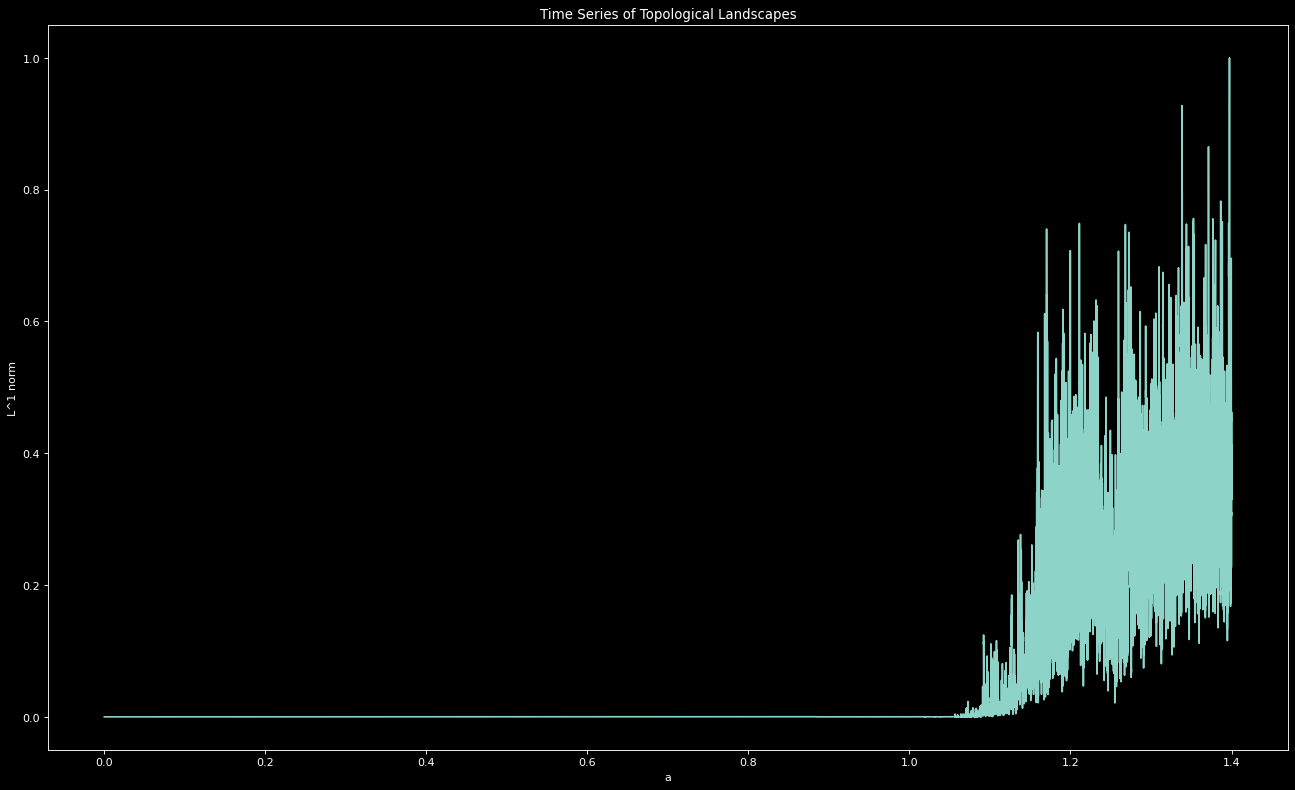

In [93]:
fig = plt.figure(figsize=(20, 12), dpi=80)
ax = fig.add_subplot()
ax.set_ylabel('L^1 norm')
ax.set_xlabel('a')
plt.plot(T[50:],norm_stand)
plt.title("Time Series of Topological Landscapes")
plt.show()

The graph below is a closer look at the $L^1$ norms as $a \rightarrow 1.06$

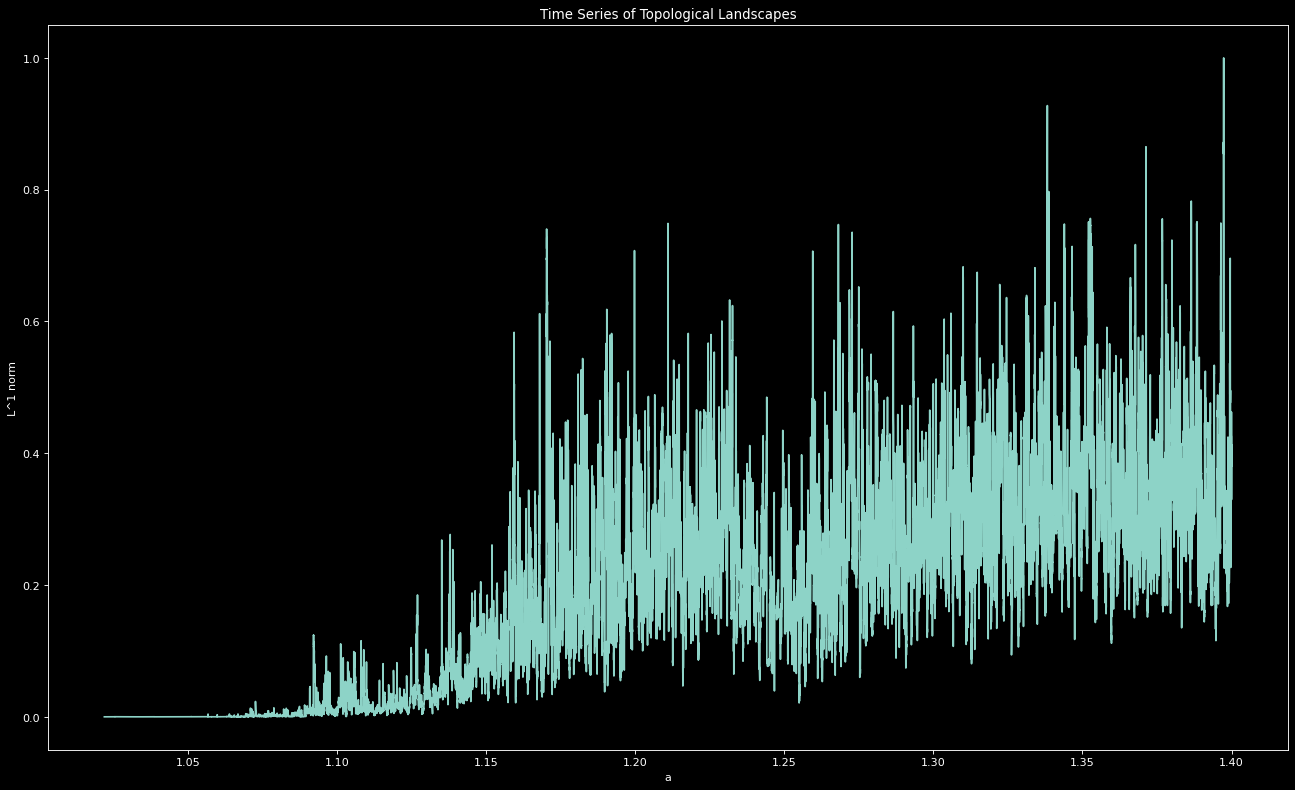

In [92]:
fig_chaos = plt.figure(figsize=(20, 12), dpi=80)
ax = fig_chaos.add_subplot()
ax.set_ylabel('L^1 norm')
ax.set_xlabel('a')
plt.plot(T[-27000:],norm_stand[-27000:])
plt.title("Time Series of Topological Landscapes")
plt.show()